# Drone Detection System Using Computer Vision

---

## Research Question

**How can drone detection in images or video frames using computer vision techniques help security, surveillance, airspace monitoring, and wildlife protection?**

---

## Expected Data Source
- **Primary Dataset**: [Roboflow Drone Detection Dataset](https://universe.roboflow.com/ahmedmohsen/drone-detection-new-peksv)
- **Local Dataset Path**: [Drone Dataset](https://github.com/atewari-bot/drone-image-classification/blob/main/data/drone-dataset-sample.zip)

---

## Expected Techniques for Analysis

### 1. **Dataset Collection and Annotation**
- Image collection from various sources
- Proper labeling and annotation of drone objects
- Quality assurance and validation

### 2. **Data Preprocessing**
- Image resizing and normalization
- Data augmentation techniques
- Noise reduction and enhancement

### 3. **Detection Framework Selection**
- **Standard CNN**: Baseline CNN Architecture
- **YOLO (You Only Look Once)**: Real-time detection
- **Faster R-CNN**: High accuracy detection
- Trade-off analysis between efficiency and accuracy

### 4. **Model Configuration and Training**
- Neural network architecture design
- Hyperparameter optimization
- Training with appropriate loss functions

### 5. **Model Evaluation**
- Classification metrics (Precision, Recall, F1-score)
- Confusion matrix analysis

### 6. **Deployment and Monitoring**
- Model deployment strategies
- Performance monitoring
- Retraining protocols

---

## Expected Results

The trained model should achieve:
- **High accuracy** in drone detection and localization
- **Strong performance metrics**: Precision, Recall, Accuracy
- **Robust detection** across various environmental conditions

---

## Importance of This Research

### Security and Safety Benefits
- **Civilian Protection**: Detecting potentially armed drones
- **Critical Infrastructure**: Safeguarding airports, government facilities
- **Privacy Protection**: Identifying unauthorized surveillance drones
- **Airspace Management**: Ensuring safe aviation operations

### Wildlife Conservation
- **Precision Detection**: Avoiding false positives that could harm wildlife
- **Conservation Monitoring**: Protecting endangered species from unauthorized surveillance
- **Habitat Preservation**: Minimizing disruption to natural environments

In [1]:
%%capture
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install tensorflow
%pip install sklearn
%pip install opencv-python
%pip install zipfile
%pip install scikit-image

In [2]:
import zipfile
import io
import os
import sys
import time
import traceback
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from matplotlib.patches import Rectangle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score
from sklearn.metrics import recall_score, f1_score, r2_score, precision_recall_curve, average_precision_score, mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

from collections import Counter, defaultdict
from scipy import stats as scipy_stats
from skimage import filters, segmentation, measure, feature
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Reshape, BatchNormalization, Dropout, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError

In [3]:
# Configuration and constants
zip_path = "data/drone-dataset-sample.zip"
train_base_folder = "drone-dataset-sample/train"
test_base_folder = "drone-dataset-sample/test"
valid_base_folder = "drone-dataset-sample/valid"
img_size = (224, 224)
MAX_BOXES = 10
class_names = ['AIRPLANE', 'DRONE', 'HELICOPTER', 'BIRD']
NUM_CLASSES = len(class_names)
EPOCHS = 50
BATCH_SIZE = 32
SMALL_BATCH_SIZE = 8
run_grid_search = True


model_training_time = []

mse_train_models = []
mae_train_models = []
acc_train_models = []
precision_train_models = []
recall_train_models = []
f1_train_models = []
r2_train_models = []

mse_val_models = []
mae_val_models = []
acc_val_models = []
precision_val_models = []
recall_val_models = []
f1_val_models = []
r2_val_models = []

mse_test_models = []
mae_test_models = []
acc_test_models = []
precision_test_models = []
recall_test_models = []
f1_test_models = []
r2_test_models = []

detection_mse_train = []
detection_mae_train = []
detection_r2_train = []
detection_coord_acc_train = []
detection_iou_train = []

detection_mse_val = []
detection_mae_val = []
detection_r2_val = []
detection_coord_acc_val = []
detection_iou_val = []

detection_mse_test = []
detection_mae_test = []
detection_r2_test = []
detection_coord_acc_test = []
detection_iou_test = []

detection_training_time = []

In [4]:
# Global declarations
# Initialize loss and metric functions
mse_loss = MeanSquaredError()
mae_loss = MeanAbsoluteError()
imbalance_ratio = 1.0
eda_results = {}

# Data Preparation

# Load data (Images and Labels)

In [5]:
# Parsing Yolo Labels
def parse_yolo_label(txt):
    '''
    Parse YOLO label format to numpy array
    '''
    boxes = []
    for line in txt.strip().split("\n"):
        if line.strip():  # Skip empty lines
            parts = line.split()
            if len(parts) >= 5:
                cls, x, y, w, h = map(float, parts[:5])
                boxes.append([cls, x, y, w, h])
    return np.array(boxes, dtype=np.float32)

# Loading images and label files from .zip dataset
def load_image_and_label(zip_ref, img_path):
    '''
    Load image and label from zip file
    '''
    if img_path.endswith(".jpg") or img_path.endswith(".png"):
        label_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".txt").replace(".png", ".txt")

        # Load and preprocess image
        try:
            with zip_ref.open(img_path) as img_file:
                image = Image.open(img_file).convert("RGB").resize(img_size)
                image_np = np.array(image) / 255.0
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        # Load and parse label
        try:
            with zip_ref.open(label_path) as label_file:
                txt = label_file.read().decode("utf-8")
                if len(txt.strip()) == 0:
                    # For empty label files, infer class from filename/path
                    if "AIRPLANE" in img_path.upper():
                        labels = np.array([[0, 0.5, 0.5, 0.3, 0.3]], dtype=np.float32)
                    elif "BIRD" in img_path.upper():
                        labels = np.array([[3, 0.5, 0.5, 0.2, 0.2]], dtype=np.float32)
                    elif "DRONE" in img_path.upper():
                        labels = np.array([[1, 0.5, 0.5, 0.25, 0.25]], dtype=np.float32)
                    elif "HELICOPTER" in img_path.upper():
                        labels = np.array([[2, 0.5, 0.5, 0.4, 0.3]], dtype=np.float32)
                    else:
                        labels = np.zeros((0, 5), dtype=np.float32)
                else:
                    labels = parse_yolo_label(txt)
        except KeyError:
            # If label file doesn't exist, try to infer from image path
            if "AIRPLANE" in img_path.upper():
                labels = np.array([[0, 0.5, 0.5, 0.3, 0.3]], dtype=np.float32)
            elif "BIRD" in img_path.upper():
                labels = np.array([[3, 0.5, 0.5, 0.2, 0.2]], dtype=np.float32)
            elif "DRONE" in img_path.upper():
                labels = np.array([[1, 0.5, 0.5, 0.25, 0.25]], dtype=np.float32)
            elif "HELICOPTER" in img_path.upper():
                labels = np.array([[2, 0.5, 0.5, 0.4, 0.3]], dtype=np.float32)
            else:
                labels = np.zeros((0, 5), dtype=np.float32)

        return image_np.astype(np.float32), labels

# Load .zip dataset from underlying filesystem
def load_dataset(zip_path, base_folder):
    '''
    Load dataset from zip file
    '''
    X = []
    Y = []

    if not os.path.exists(zip_path):
        print(f"Error: Zip file {zip_path} not found!")
        return None, None

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        # Get all image paths
        image_paths = [f for f in zip_ref.namelist()
                      if f.startswith(f"{base_folder}/images/") and f.endswith((".jpg", ".png"))]

        print(f"Found {len(image_paths)} images in {base_folder}")

        for i, path in enumerate(image_paths):
            try:
                img, label = load_image_and_label(zip_ref, path)
                if img is not None and label is not None:
                    # Pad labels to fixed length
                    padded = np.zeros((MAX_BOXES, 5), dtype=np.float32)
                    if len(label) > 0:
                        padded[:min(len(label), MAX_BOXES)] = label[:MAX_BOXES]
                    X.append(img)
                    Y.append(padded)

                    if (i + 1) % 50 == 0:
                        print(f"Processed {i + 1}/{len(image_paths)} images")

            except Exception as e:
                print(f"Error processing {path}: {e}")
                continue

    if len(X) == 0:
        print(f"No valid images found in {base_folder}")
        return None, None

    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32)

    # Validate loaded files
    if np.isnan(X).any():
        print("Warning: NaNs found in X, replacing with zeros")
        X = np.nan_to_num(X)
    if np.isnan(Y).any():
        print("Warning: NaNs found in Y, replacing with zeros")
        Y = np.nan_to_num(Y)

    print(f"Loaded {len(X)} images with shape {X.shape}")

    return X, Y

In [6]:
# Load Training Dataset
print("Loading training data...")
X_train, Y_train = load_dataset(zip_path, train_base_folder)

if X_train is None:
  print("Failed to load training data!")

Loading training data...
Found 2100 images in drone-dataset-sample/train
Processed 50/2100 images
Processed 100/2100 images
Processed 150/2100 images
Processed 200/2100 images
Processed 250/2100 images
Processed 300/2100 images
Processed 350/2100 images
Processed 400/2100 images
Processed 450/2100 images
Processed 500/2100 images
Processed 550/2100 images
Processed 600/2100 images
Processed 650/2100 images
Processed 700/2100 images
Processed 750/2100 images
Processed 800/2100 images
Processed 850/2100 images
Processed 900/2100 images
Processed 950/2100 images
Processed 1000/2100 images
Processed 1050/2100 images
Processed 1100/2100 images
Processed 1150/2100 images
Processed 1200/2100 images
Processed 1250/2100 images
Processed 1300/2100 images
Processed 1350/2100 images
Processed 1400/2100 images
Processed 1450/2100 images
Processed 1500/2100 images
Processed 1550/2100 images
Processed 1600/2100 images
Processed 1650/2100 images
Processed 1700/2100 images
Processed 1750/2100 images
Pr

In [7]:
print("Loading validation data...")
X_val, Y_val = load_dataset(zip_path, valid_base_folder)

Loading validation data...
Found 400 images in drone-dataset-sample/valid
Processed 50/400 images
Processed 100/400 images
Processed 150/400 images
Processed 200/400 images
Processed 250/400 images
Processed 300/400 images
Processed 350/400 images
Processed 400/400 images
Loaded 400 images with shape (400, 224, 224, 3)


In [8]:
print("Loading test data...")
X_test, Y_test = load_dataset(zip_path, test_base_folder)

Loading test data...
Found 400 images in drone-dataset-sample/test
Processed 50/400 images
Processed 100/400 images
Processed 150/400 images
Processed 200/400 images
Processed 250/400 images
Processed 300/400 images
Processed 350/400 images
Processed 400/400 images
Loaded 400 images with shape (400, 224, 224, 3)


## Convert object detection data into image classification data

Convert an object detection dataset (images + bounding boxes + class IDs) into a simple classification dataset, where each image gets a single label.

In [9]:
# Converts object detection data into image classification data by extracting a single class label per image
# (specifically, the class of the first detected object in each image).
def create_classification_data(X, Y):
    '''
    Convert detection data to classification data by taking the first (most confident) class
    '''
    classification_labels = []
    valid_images = []

    for i in range(len(X)):
        # Find the first non-zero box
        valid_boxes = Y[i][~np.all(Y[i] == 0, axis=1)]

        if len(valid_boxes) > 0:
            # Use the first valid box's class
            class_id = int(valid_boxes[0, 0])
            if 0 <= class_id < NUM_CLASSES:
                classification_labels.append(class_id)
                valid_images.append(X[i])

    return np.array(valid_images), np.array(classification_labels)

Create classification data for Train, Test and Validation dataset

In [10]:
print("\nPreparing classification data...")
X_train_cls, y_train_cls = create_classification_data(X_train, Y_train)
y_labels = y_train_cls

if len(X_train_cls) == 0:
    print("No valid classification data found!")

X_val_cls, y_val_cls = None, None
X_test_cls, y_test_cls = None, None

if X_val is not None:
    X_val_cls, y_val_cls = create_classification_data(X_val, Y_val)
if X_test is not None:
    X_test_cls, y_test_cls = create_classification_data(X_test, Y_test)

print(f"Classification data - Train: {len(X_train_cls)}, Val: {len(X_val_cls) if X_val_cls is not None else 0}, Test: {len(X_test_cls) if X_test_cls is not None else 0}")



Preparing classification data...
Classification data - Train: 2100, Val: 400, Test: 400


# Exploratory Data Analysis

## EDA - Class Balance

In image processing for classification or detection tasks, a class imbalance check means examining whether some classes (labels) have significantly more images or annotations than others.

In [11]:
def analyze_class_balance(y_labels, title="Class Distribution"):
    '''
    Analyze and visualize class balance
    '''
    print("="*60)
    print(f"Class Balance Analysis - {title}")
    print("="*60)

    # Count class occurrences
    class_counts = Counter(y_labels)

    # Calculate percentages
    total_samples = len(y_labels)

    # Print statistics
    print(f"Total samples: {total_samples}")
    print("\nClass distribution:")
    for cls, count in class_counts.items():
        percentage = (count/total_samples)*100
        print(f"  {class_names[cls]}: {count} samples ({percentage:.1f}%)")

    # Calculate imbalance ratio
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot
    classes = [class_names[cls] for cls in class_counts.keys()]
    counts = list(class_counts.values())
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

    ax1.bar(classes, counts, color=colors[:len(classes)])
    ax1.set_title('Class Distribution (Counts)')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)

    # Add count labels on bars
    for i, count in enumerate(counts):
        ax1.text(i, count + max(counts)*0.01, str(count), ha='center')

    # Pie chart
    ax2.pie(counts, labels=classes, autopct='%1.1f%%', colors=colors[:len(classes)])
    ax2.set_title('Class Distribution (Percentages)')

    plt.tight_layout()
    plt.savefig('images/class_distribution.png')
    plt.show()

    return class_counts, imbalance_ratio

Class Balance Analysis - Training Set
Total samples: 2100

Class distribution:
  DRONE: 834 samples (39.7%)
  HELICOPTER: 460 samples (21.9%)
  BIRD: 380 samples (18.1%)
  AIRPLANE: 426 samples (20.3%)

Imbalance ratio (max/min): 2.19


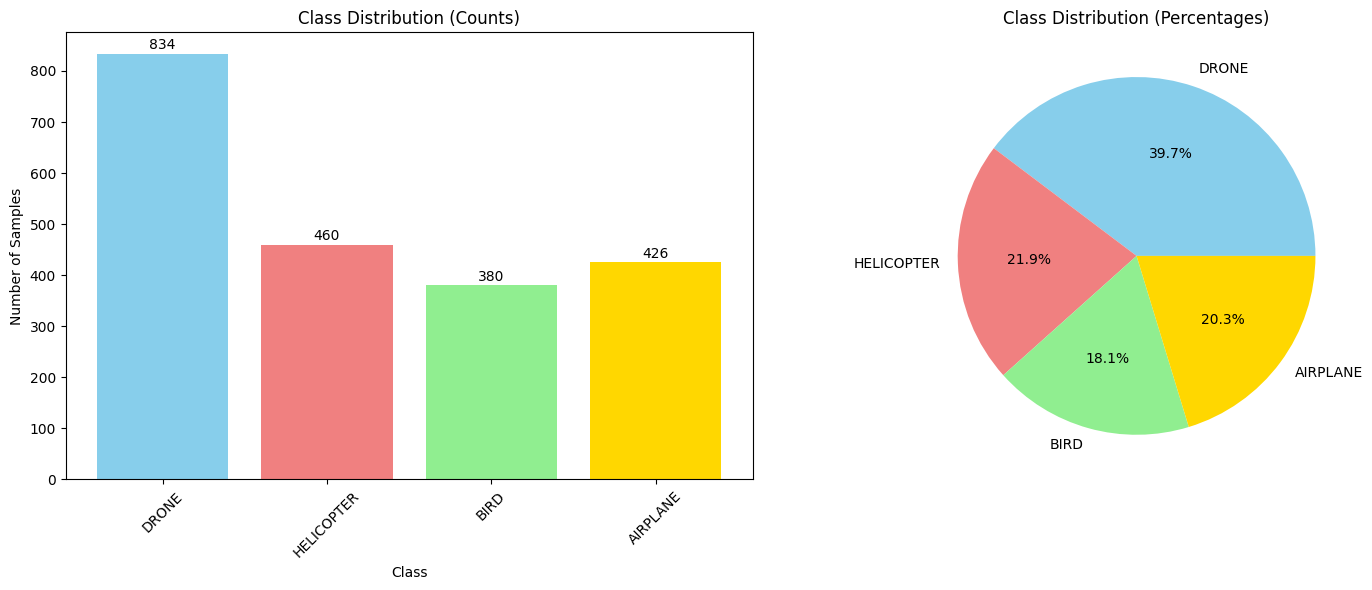

In [12]:
if y_labels is not None:
  class_counts, imbalance_ratio = analyze_class_balance(y_labels, "Training Set")
  eda_results['class_balance'] = {'counts': class_counts, 'imbalance_ratio': imbalance_ratio}

## EDA - Pixel Statistics for Images

Pixel statistics refer to summary statistics computed over the pixel values of images. They help us understand the distribution, intensity, and variation of pixel data.

Pixel statistics help understand:
* Decide whether to normalize or standardize
* Detect outliers or corruption
* Understand contrast and brightness levels
* Compare channels in RGB images

In [13]:
def compute_pixel_statistics(X, y_labels=None):
    '''
    Compute comprehensive pixel statistics for images
    '''
    print("="*60)
    print("Pixel Statistics")
    print("="*60)

    # Overall statistics
    print("Overall Image Statistics:")
    print(f"  Mean pixel value: {np.mean(X):.4f}")
    print(f"  Std pixel value: {np.std(X):.4f}")
    print(f"  Min pixel value: {np.min(X):.4f}")
    print(f"  Max pixel value: {np.max(X):.4f}")

    # Channel-wise statistics
    print("\nChannel-wise Statistics:")
    for i, channel in enumerate(['Red', 'Green', 'Blue']):
        channel_data = X[:, :, :, i]
        print(f"  {channel} channel:")
        print(f"    Mean: {np.mean(channel_data):.4f}")
        print(f"    Std: {np.std(channel_data):.4f}")
        print(f"    Min: {np.min(channel_data):.4f}")
        print(f"    Max: {np.max(channel_data):.4f}")

    # Class-wise statistics if labels provided
    if y_labels is not None:
        print("\nClass-wise Statistics:")
        for class_id in np.unique(y_labels):
            class_images = X[y_labels == class_id]
            if len(class_images) > 0:
                print(f"  {class_names[class_id]}:")
                print(f"    Mean: {np.mean(class_images):.4f}")
                print(f"    Std: {np.std(class_images):.4f}")
                print(f"    Brightness: {np.mean(class_images, axis=(1,2,3)).mean():.4f}")
                print(f"    Contrast: {np.std(class_images, axis=(1,2,3)).mean():.4f}")

    # Visualize pixel distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Overall pixel histogram
    axes[0, 0].hist(X.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Overall Pixel Distribution')
    axes[0, 0].set_xlabel('Pixel Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)

    # Channel-wise histograms
    colors = ['red', 'green', 'blue']
    for i, (channel, color) in enumerate(zip(['Red', 'Green', 'Blue'], colors)):
        axes[0, 1].hist(X[:, :, :, i].flatten(), bins=50, alpha=0.5,
                       label=channel, color=color, edgecolor='black')
    axes[0, 1].set_title('Channel-wise Pixel Distribution')
    axes[0, 1].set_xlabel('Pixel Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Brightness distribution
    brightness = np.mean(X, axis=(1, 2, 3))
    axes[1, 0].hist(brightness, bins=30, alpha=0.7, color='gold', edgecolor='black')
    axes[1, 0].set_title('Image Brightness Distribution')
    axes[1, 0].set_xlabel('Mean Brightness')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)

    # Contrast distribution
    contrast = np.std(X, axis=(1, 2, 3))
    axes[1, 1].hist(contrast, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].set_title('Image Contrast Distribution')
    axes[1, 1].set_xlabel('Standard Deviation')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/pixel_statistics.png")
    plt.show()

    return {
        'overall_stats': {'mean': np.mean(X), 'std': np.std(X), 'min': np.min(X), 'max': np.max(X)},
        'brightness': brightness,
        'contrast': contrast
    }

Pixel Statistics
Overall Image Statistics:
  Mean pixel value: 0.5217
  Std pixel value: 0.1686
  Min pixel value: 0.0000
  Max pixel value: 1.0000

Channel-wise Statistics:
  Red channel:
    Mean: 0.4159
    Std: 0.1241
    Min: 0.0000
    Max: 1.0000
  Green channel:
    Mean: 0.5131
    Std: 0.1258
    Min: 0.0000
    Max: 1.0000
  Blue channel:
    Mean: 0.6361
    Std: 0.1725
    Min: 0.0000
    Max: 1.0000

Class-wise Statistics:
  AIRPLANE:
    Mean: 0.5241
    Std: 0.1565
    Brightness: 0.5241
    Contrast: 0.1448
  DRONE:
    Mean: 0.5148
    Std: 0.1862
    Brightness: 0.5148
    Contrast: 0.1801
  HELICOPTER:
    Mean: 0.5343
    Std: 0.1446
    Brightness: 0.5343
    Contrast: 0.1162
  BIRD:
    Mean: 0.5187
    Std: 0.1673
    Brightness: 0.5187
    Contrast: 0.1614


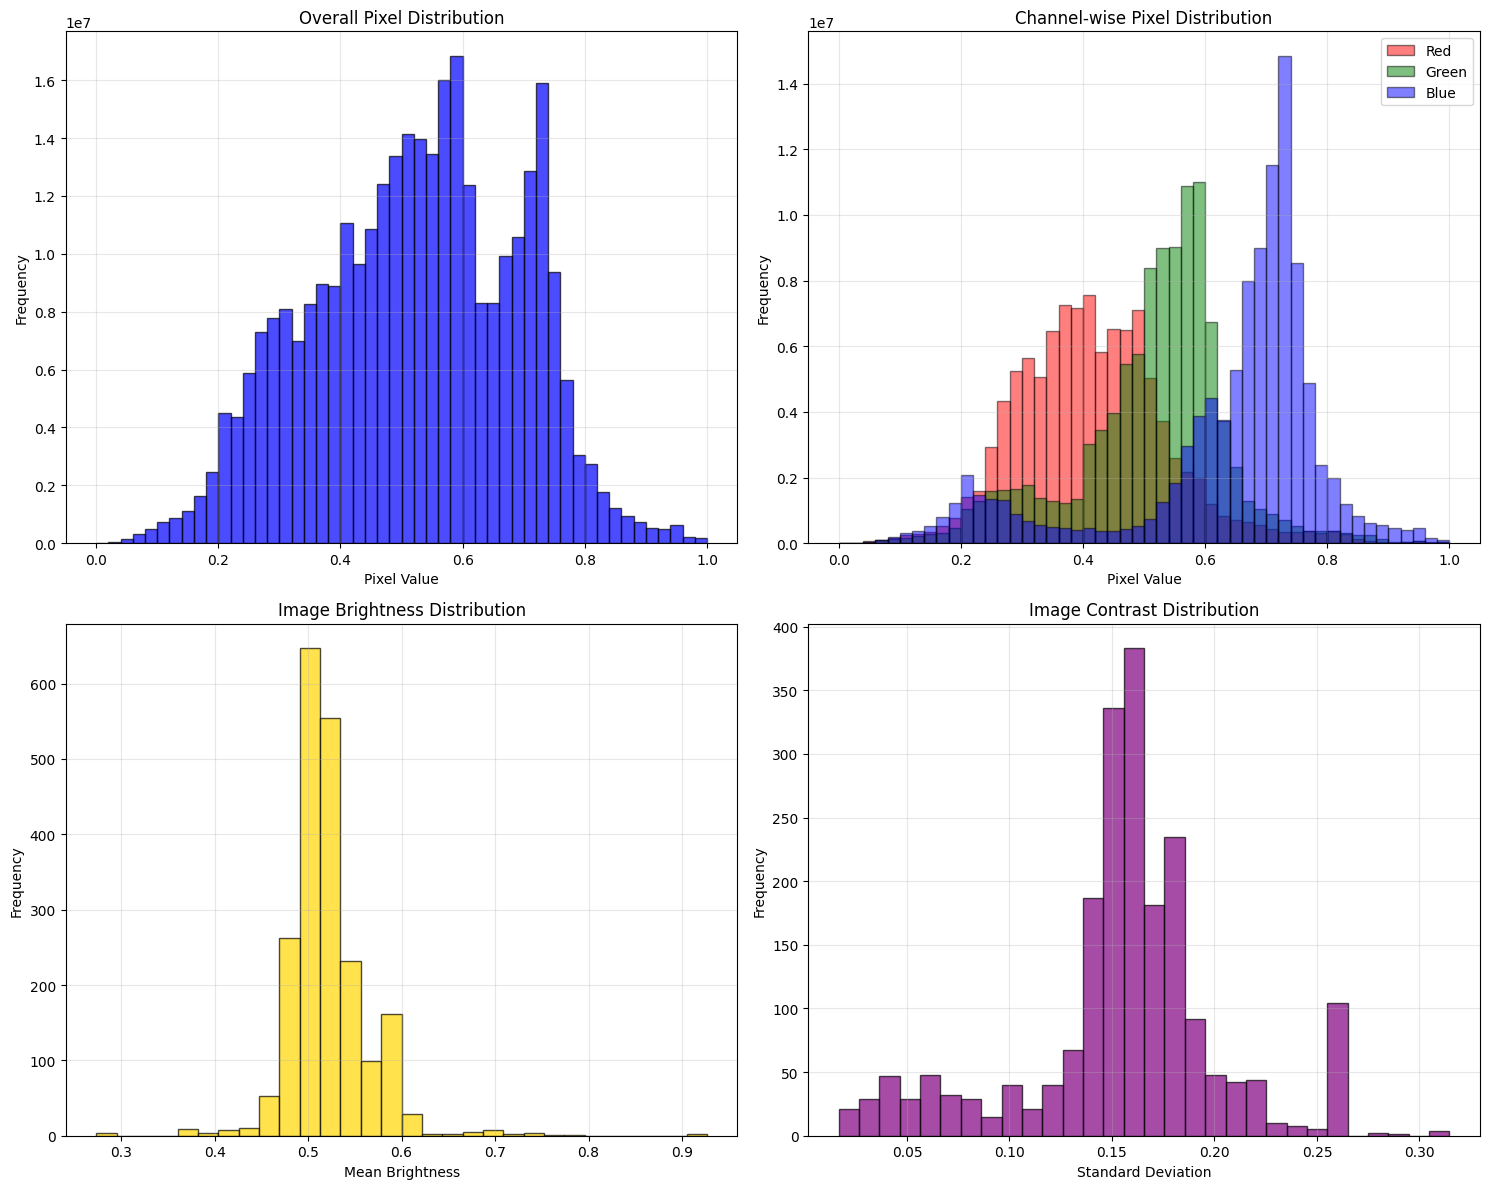

In [14]:
pixel_stats = compute_pixel_statistics(X_train_cls, y_labels)
eda_results['pixel_statistics'] = pixel_stats

### Image Pixel Statistics Summary (with Class-wise Insights)

| Category | Metric | Value | Description |
|----------|--------|-------|-------------|
| **Pixel Value Distribution** | Bimodal Distribution | Peaks at ~0.5 and ~0.7 | Distinct visual patterns across aircraft classes |
| | Full Range Coverage | 0.0-1.0 | Rich feature diversity |
| | Concentrated Range | 0.3-0.8 | Avoiding extreme dark/bright regions |

### Channel-wise Analysis

| Channel | Frequency | Peak Range | Characteristics |
|---------|-----------|------------|----------------|
| **Blue** | ~1.4×10⁷ (Highest) | 0.7-0.8 | Significant sky background across all aircraft classes |
| **Green** | Moderate | ~0.6 | Vegetation/terrain backgrounds in some images |
| **Red** | Lowest | 0.4-0.6 | Minimal red content across aircraft imagery |

### Image Quality Metrics

| Metric | Range/Value | Peak/Optimal | Quality Indicator |
|--------|-------------|--------------|------------------|
| **Mean Brightness** | 0.50-0.55 | ~650 images | Well-exposed images, standardized capture conditions |
| **Contrast (Std Dev)** | 0.05-0.30 | 0.15-0.17 | High-quality data, good contrast for feature extraction |

### Class-wise Insights

| Class | Key Characteristics | Background Context | Technical Notes |
|-------|-------------------|-------------------|-----------------|
| **AIRPLANE** | Sky dominance, size variation, consistent lighting | High-altitude captures with clear sky backgrounds | Bimodal distribution: close-up and distant shots |
| **BIRD** | Natural environment, variable contrast | Outdoor/natural backgrounds | Motion blur potential, lighting variations |
| **DRONE** | Mixed backgrounds, technical clarity | Diverse operational environments | Scale variations: detail shots and operational distance |
| **HELICOPTER** | Operational context, distinctive features | Aerial operations over varied terrain | Rotor blade visibility, environmental diversity |

### Classification Implications

| Category | Feature | Application | Benefit |
|----------|---------|-------------|---------|
| **Feature Discrimination** | Sky vs. Ground Context | Blue channel intensity analysis | Distinguish operational environments |
| | Scale Recognition | Pixel brightness distribution | Indicate relative aircraft size/distance |
| | Background Separation | Channel-wise distribution | Enable background subtraction techniques |

### Data Quality Assessment

| Quality Aspect | Status | Description |
|----------------|--------|-------------|
| **Balance** | Excellent | No class appears over/under-exposed |
| **Feature Richness** | High | Sufficient contrast across all classes for CNN feature extraction |
| **Processing** | Standardized | Consistent distributions suggest proper preprocessing |

### Model Training Considerations

| Consideration | Recommendation | Rationale |
|---------------|----------------|-----------|
| **Color Normalization** | Channel-wise normalization required | Blue channel dominance |
| **Augmentation Strategy** | Effective techniques applicable | Good base contrast |
| **Class Balance** | Balanced representation confirmed | Similar pixel distributions across classes |

### Conclusion

| Assessment | Result |
|------------|--------|
| **Dataset Quality** | High-quality dataset well-suited for multi-class aircraft classification |
| **Feature Learning** | Distinct pixel characteristics enable effective feature learning |
| **Classification Performance** | Expected good performance due to balanced and feature-rich data |

# EDA - Image Quality Metrics

Image quality metrics are quantitative measures used to assess how good or degraded an image is, often in relation to distortions like noise, blur, compression artifacts, or other imperfections introduced during acquisition, processing, or transmission. These metrics are essential for evaluating the performance of image processing algorithms, camera systems, and computer vision applications.  

We analyzed 6 types of image quality metrics:

* Brightness (mean luminance)
* Contrast (standard deviation)
* Sharpness (variance of Laplacian)
* Entropy (information content)
* Noise level (high frequency energy)
* Color richness (number of unique colors)

In [15]:
def analyze_image_quality_metrics(X, y_labels=None):
    '''
    Analyze various image quality metrics
    '''
    print("="*60)
    print("Image Quality Metrics Analysis")
    print("="*60)

    quality_metrics = {
        'brightness': [],
        'contrast': [],
        'sharpness': [],
        'entropy': [],
        'noise_level': [],
        'color_richness': []
    }

    # Analyze subset of images
    subset_size = min(200, len(X))
    subset_indices = np.random.choice(len(X), subset_size, replace=False)

    print(f"Analyzing {subset_size} images for quality metrics...")

    for i, idx in enumerate(subset_indices):
        img = X[idx]
        gray = rgb2gray(img)

        # Brightness (mean luminance)
        brightness = np.mean(gray)
        quality_metrics['brightness'].append(brightness)

        # Contrast (standard deviation)
        contrast = np.std(gray)
        quality_metrics['contrast'].append(contrast)

        # Sharpness (variance of Laplacian)
        gray_uint8 = (gray * 255).astype(np.uint8)
        laplacian_var = cv2.Laplacian(gray_uint8, cv2.CV_64F).var()
        quality_metrics['sharpness'].append(laplacian_var)

        # Entropy (information content)
        hist, _ = np.histogram(gray.flatten(), bins=256, density=True)
        # Remove zeros to avoid log(0) issues
        hist = hist[hist > 0]
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        quality_metrics['entropy'].append(entropy)

        # Noise level (high frequency energy)
        # Apply high-pass filter and measure energy
        kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        high_freq = cv2.filter2D(gray_uint8, -1, kernel)
        noise_level = np.std(high_freq)
        quality_metrics['noise_level'].append(noise_level)

        # Color richness (number of unique colors)
        img_uint8 = (img * 255).astype(np.uint8)
        # Count unique colors (simplified)
        unique_colors = len(np.unique(img_uint8.reshape(-1, 3), axis=0))
        color_richness = unique_colors / (img_size[0] * img_size[1])  # Normalize
        quality_metrics['color_richness'].append(color_richness)

        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{subset_size} images")

    # Convert to numpy arrays
    for key in quality_metrics:
        quality_metrics[key] = np.array(quality_metrics[key])

    # Print statistics
    print("\nQuality Metrics Statistics:")
    for metric, values in quality_metrics.items():
        print(f"  {metric.replace('_', ' ').title()}:")
        print(f"    Mean: {np.mean(values):.4f}")
        print(f"    Std: {np.std(values):.4f}")
        print(f"    Min: {np.min(values):.4f}")
        print(f"    Max: {np.max(values):.4f}")

    # Visualize quality metrics
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    y_subset = y_labels[subset_indices] if y_labels is not None else None
    colors = ['blue', 'red', 'green', 'orange']

    for i, (metric, values) in enumerate(quality_metrics.items()):
        ax = axes[i]

        if y_subset is not None:
            # Plot by class
            for class_id in np.unique(y_subset):
                mask = y_subset == class_id
                if np.sum(mask) > 0:
                    ax.hist(values[mask], bins=20, alpha=0.7,
                           color=colors[class_id], label=class_names[class_id])
            ax.legend()
        else:
            ax.hist(values, bins=20, alpha=0.7, color='skyblue')

        ax.set_title(f'{metric.replace("_", " ").title()} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/image_quality_metrics.png")
    plt.show()

    return quality_metrics

Image Quality Metrics Analysis
Analyzing 200 images for quality metrics...
Processed 50/200 images
Processed 100/200 images
Processed 150/200 images
Processed 200/200 images

Quality Metrics Statistics:
  Brightness:
    Mean: 0.5000
    Std: 0.0475
    Min: 0.2427
    Max: 0.7164
  Contrast:
    Mean: 0.1025
    Std: 0.0540
    Min: 0.0156
    Max: 0.2840
  Sharpness:
    Mean: 91.0893
    Std: 114.9231
    Min: 1.1766
    Max: 807.3490
  Entropy:
    Mean: -1399.3888
    Std: 1537.9019
    Min: -11503.0790
    Max: -112.1280
  Noise Level:
    Mean: 13.9279
    Std: 7.4772
    Min: 1.9035
    Max: 41.8165
  Color Richness:
    Mean: 0.1343
    Std: 0.0875
    Min: 0.0060
    Max: 0.4882


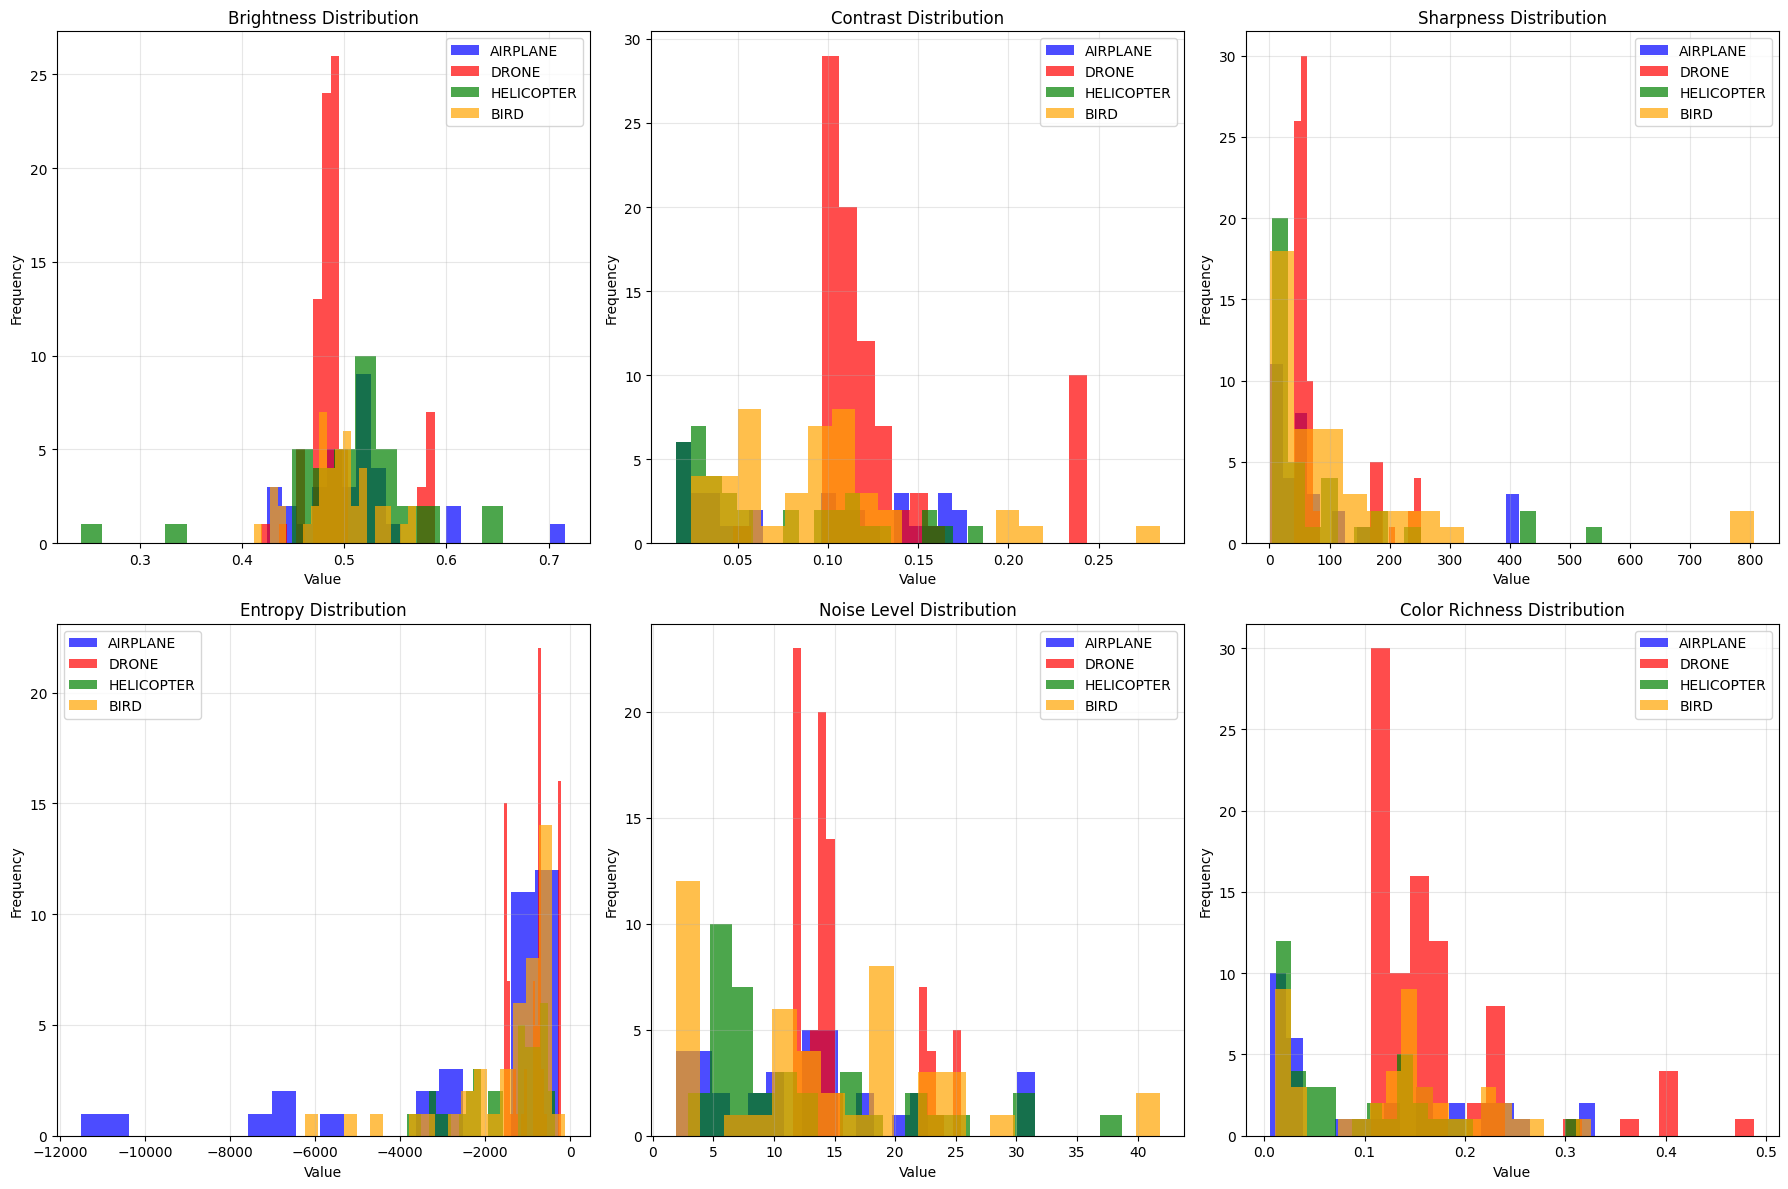

In [16]:
quality_metrics = analyze_image_quality_metrics(X_train_cls, y_labels)
eda_results['quality_metrics'] = quality_metrics

### Class-Wise Image Quality Feature Distributions

A compact overview of pixel-based quality metrics for aircraft image classification across four classes: **AIRPLANE**, **DRONE**, **HELICOPTER**, **BIRD**.

### Brightness
| Class        | Peak Range | Insights                             |
|--------------|------------|--------------------------------------|
| AIRPLANE     | 0.5–0.6    | Consistent exposure, sky backgrounds |
| DRONE        | 0.5–0.55   | Most stable lighting                 |
| HELICOPTER   | 0.4–0.6    | Varies with operational context      |
| BIRD         | 0.5–0.6    | Natural light variability            |

### Contrast
| Class        | Peak Range | Insights                                 |
|--------------|------------|------------------------------------------|
| AIRPLANE     | 0.05–0.10  | Low contrast due to sky                 |
| DRONE        | 0.08–0.12  | Strong subject separation               |
| HELICOPTER   | 0.05–0.15  | Background & rotor diversity            |
| BIRD         | 0.05–0.20  | Broad due to motion/nature variation    |

### Sharpness
| Class        | Range    | Notes                                      |
|--------------|----------|--------------------------------------------|
| AIRPLANE     | 50–100   | Atmospheric haze effect                    |
| DRONE        | 100–150  | Technically sharp, clear details           |
| HELICOPTER   | 0–100    | Motion blur from rotors                    |
| BIRD         | 50–200   | Motion artifacts, variable sharpness       |

### Entropy
| Class        | Range         | Description                        |
|--------------|---------------|------------------------------------|
| AIRPLANE     | –2000 to 0    | Moderate structure features        |
| DRONE        | –2000 to 0    | High pattern consistency           |
| HELICOPTER   | –4000 to 0    | Complex configurations             |
| BIRD         | –6000 to 0    | Rich in texture & variation        |

### Noise Level
| Class        | Range   | Observations                                 |
|--------------|---------|----------------------------------------------|
| AIRPLANE     | 5–15    | Low noise, controlled environments           |
| DRONE        | 12–18   | Consistent across diverse scenes             |
| HELICOPTER   | 8–20    | Varies with outdoor ops                      |
| BIRD         | 10–25   | High noise due to natural image capture      |

### Color Richness
| Class        | Range     | Notes                                          |
|--------------|-----------|-----------------------------------------------|
| AIRPLANE     | 0.1–0.2   | Sky blue/metallic hues                        |
| DRONE        | 0.15–0.25 | Technically diverse color range               |
| HELICOPTER   | 0.1–0.3   | Military/civil designs                        |
| BIRD         | 0.1–0.4   | Natural plumage diversity                     |

---

### Key Takeaways for Model Training

| Metric            | Best Class | Worst Class | Recommendation                        |
|------------------|------------|-------------|----------------------------------------|
| **Consistency**   | DRONE      | BIRD        | Augment BIRD class                     |
| **Contrast**      | DRONE      | AIRPLANE    | Improve edge detection for AIRPLANE    |
| **Sharpness**     | DRONE      | HELICOPTER  | Apply deblurring to HELICOPTER         |
| **Noise Level**   | AIRPLANE   | BIRD        | Use denoising on BIRD images           |
| **Richness**      | BIRD       | AIRPLANE    | Boost texture features for BIRD        |

---

### Classification Insights

- **DRONE**: Most consistent and easiest to classify
- **AIRPLANE**: Clear skies aid context, but low contrast is limiting
- **HELICOPTER**: Needs blur-resistant features due to motion
- **BIRD**: High variation requires strong augmentation and denoising

## EDA - Dimensionality Analysis

PCA (Principal Component Analysis) in image processing is a statistical technique used to reduce the dimensionality of image data while preserving as much important information as possible. In practice, this means transforming a potentially large set of correlated pixel values (features) into a smaller set of uncorrelated variables called principal components.

t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique primarily used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. Its main goal is to capture and preserve the local structure and relationships among data points, making it easier to identify patterns, clusters, or groupings that exist in the original high-dimensional space.

In [17]:
def perform_rf_dimensionality_analysis(X_features, y_labels, feature_names):
    '''
    Perform PCA analysis on features
    '''
    print("="*60)
    print("Dimensionality Reduction Analysis - RandomForest")
    print("="*60)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_features)

    # PCA Analysis
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Plot explained variance
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Explained variance ratio
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    axes[0].plot(range(1, min(51, len(explained_var)+1)),
                explained_var[:50], 'b-', linewidth=2)
    axes[0].set_title('PCA: Explained Variance Ratio')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].grid(True, alpha=0.3)

    # Cumulative explained variance
    axes[1].plot(range(1, min(51, len(cumulative_var)+1)),
                cumulative_var[:50], 'r-', linewidth=2)
    axes[1].axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% Variance')
    axes[1].set_title('PCA: Cumulative Explained Variance')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # 2D PCA visualization
    colors = ['blue', 'red', 'green', 'orange']
    for class_id in np.unique(y_labels):
        mask = y_labels == class_id
        axes[2].scatter(X_pca[mask, 0], X_pca[mask, 1],
                       c=colors[class_id], label=class_names[class_id], alpha=0.7)

    axes[2].set_title('PCA: First Two Components')
    axes[2].set_xlabel(f'PC1 ({explained_var[0]:.2%} variance)')
    axes[2].set_ylabel(f'PC2 ({explained_var[1]:.2%} variance)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/rf_pca_analysis.png")
    plt.show()

    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
    print(f"Components needed for 95% variance: {n_components_95}")

    return pca, n_components_95

### Dimensionality Reduction Analysis - CNN

These Dimensionality analysis provide complementary views on the **structure and dimensionality** of the dataset. They help answer:
- How separable are the classes?
- Can dimensionality be reduced without losing key information?

In [18]:
def perform_cnn_dimensionality_analysis(X, y_labels=None):
    '''
    Perform dimensionality reduction and visualization
    '''
    print("="*60)
    print("Dimensionality Reduction Analysis - CNN")
    print("="*60)

    # Flatten images for analysis
    X_flat = X.reshape(X.shape[0], -1)

    # Subsample for computational efficiency
    n_samples = min(500, len(X_flat))
    indices = np.random.choice(len(X_flat), n_samples, replace=False)
    X_subset = X_flat[indices]
    y_subset = y_labels[indices] if y_labels is not None else None

    print(f"Analyzing {n_samples} samples...")

    # PCA Analysis
    print("Performing PCA...")
    pca = PCA()
    X_pca = pca.fit_transform(X_subset)

    # Plot explained variance ratio
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Explained variance ratio
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    axes[0, 0].plot(range(1, min(51, len(explained_var)+1)),
                   explained_var[:50], 'b-', linewidth=2)
    axes[0, 0].set_title('PCA: Explained Variance Ratio')
    axes[0, 0].set_xlabel('Principal Component')
    axes[0, 0].set_ylabel('Explained Variance Ratio')
    axes[0, 0].grid(True, alpha=0.3)

    # Cumulative explained variance
    axes[0, 1].plot(range(1, min(51, len(cumulative_var)+1)),
                   cumulative_var[:50], 'r-', linewidth=2)
    axes[0, 1].axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% Variance')
    axes[0, 1].set_title('PCA: Cumulative Explained Variance')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
    print(f"Components needed for 95% variance: {n_components_95}")

    # 2D PCA visualization
    if y_subset is not None:
        colors = ['blue', 'red', 'green', 'orange']
        for class_id in np.unique(y_subset):
            mask = y_subset == class_id
            axes[1, 0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
        axes[1, 0].legend()
    else:
        axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

    axes[1, 0].set_title('PCA: First Two Components')
    axes[1, 0].set_xlabel(f'PC1 ({explained_var[0]:.2%} variance)')
    axes[1, 0].set_ylabel(f'PC2 ({explained_var[1]:.2%} variance)')
    axes[1, 0].grid(True, alpha=0.3)

    # t-SNE Analysis
    print("Performing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_subset[:200])
    y_tsne = y_subset[:200] if y_subset is not None else None

    if y_tsne is not None:
        for class_id in np.unique(y_tsne):
            mask = y_tsne == class_id
            axes[1, 1].scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
        axes[1, 1].legend()
    else:
        axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)

    axes[1, 1].set_title('t-SNE Visualization')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/cnn_pca_analysis.png")
    plt.show()

    return {
        'pca': pca,
        'explained_variance_ratio': explained_var,
        'n_components_95': n_components_95,
        'X_pca': X_pca,
        'X_tsne': X_tsne
    }

Dimensionality Reduction Analysis - CNN
Analyzing 500 samples...
Performing PCA...
Components needed for 95% variance: 29
Performing t-SNE...


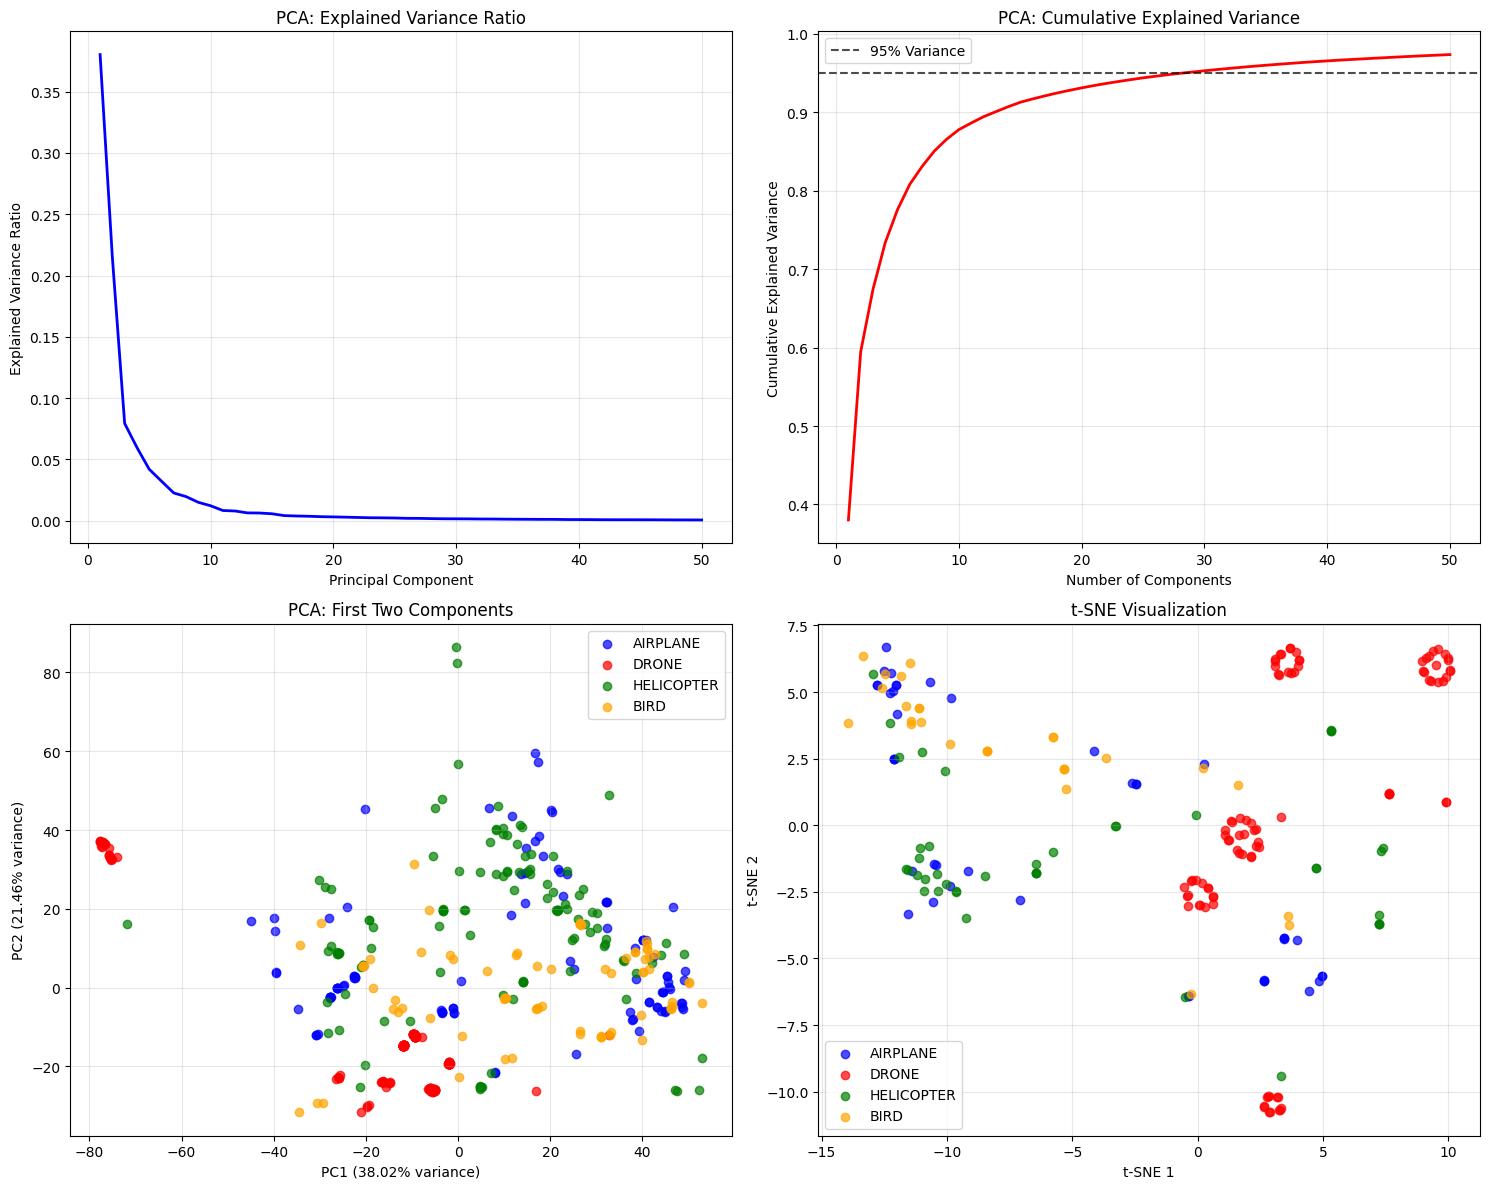

In [19]:
dim_analysis = perform_cnn_dimensionality_analysis(X_train_cls, y_labels)
eda_results['dimensionality'] = dim_analysis

### Dimensionality Reduction Visualization Summary

| Class       | t-SNE Pattern       | CNN Strategy                        | Feature Focus               | Training Needs                          | Expected Performance |
|-------------|----------------------|-------------------------------------|-----------------------------|-----------------------------------------|----------------------|
| **DRONE**   | Tight clusters       | Shallow CNN (e.g., MobileNet)       | Geometric shapes            | Fast convergence, low complexity        | Highest            |
| **AIRPLANE**| Scattered groups     | Medium-depth + spatial attention    | Sky vs background patterns  | Moderate depth, spatial pooling         | Good               |
| **HELICOPTER** | Dispersed           | Deep CNN + Ensemble (ResNet-50+)   | Rotor blade variations      | Complex features, deeper layers         | Moderate          |
| **BIRD**    | Mixed, low cohesion  | Transfer learning + augmentation    | Natural textures, poses     | Pre-trained models, heavy augmentation  | Challenging        |


**Additional Key Metrics**

| Metric                        | Value              | Implication                                |
|------------------------------|--------------------|--------------------------------------------|
| Explained Variance (PC1+2)   | 62.24%             | Strong class separability                  |
| Variance (First 10 PCs)      | ~90%               | Core CNN feature set                       |
| Optimal Dimensionality       | ~25 PCs            | Efficient compression + representation     |
| Most Challenging Class       | BIRD               | Needs advanced augmentation & transfer learning |

## EDA - Analyzing Spatial Patterns

Spatial patterns is the process of examining how objects, events, or features are distributed across space to gain insights into underlying processes or relationships.  

These pattern analysis offer a deep look into **spatial and textural characteristics** of the dataset and can inform:
- Feature selection and engineering
- Preprocessing strategies
- Neural network architecture decisions

We analyzed 6 types of spatial patterns:

* Center Region Analysis
* Gradient Magnitude Analysis
* Corner Detection Analysis (Harris corner detection)
* Symmetry Analysis
* Frequency Domain Analysis (FFT analysis)
* Texture Complexity

In [20]:
def analyze_spatial_patterns(X, y_labels=None):
    '''
    Analyze spatial patterns and object distributions
    '''
    print("="*60)
    print("Spatial Pattern Analysis")
    print("="*60)

    # Analyze object positioning from bounding boxes if available
    spatial_stats = {
        'center_positions': [],
        'object_sizes': [],
        'aspect_ratios': [],
        'edge_distances': []
    }

    # For demonstration, create some analysis of spatial patterns
    print("Analyzing spatial distributions in images...")

    # Sample images for spatial analysis
    n_samples = min(50, len(X))
    sample_indices = np.random.choice(len(X), n_samples, replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Center region analysis
    center_intensities = []
    edge_intensities = []

    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)
        h, w = gray.shape

        # Define center and edge regions
        center_region = gray[h//4:3*h//4, w//4:3*w//4]
        edge_region = np.concatenate([
            gray[:h//4, :].flatten(),
            gray[3*h//4:, :].flatten(),
            gray[:, :w//4].flatten(),
            gray[:, 3*w//4:].flatten()
        ])

        center_intensities.append(np.mean(center_region))
        edge_intensities.append(np.mean(edge_region))

    axes[0, 0].scatter(center_intensities, edge_intensities, alpha=0.7)
    axes[0, 0].plot([0, 1], [0, 1], 'r--', alpha=0.5)
    axes[0, 0].set_xlabel('Center Intensity')
    axes[0, 0].set_ylabel('Edge Intensity')
    axes[0, 0].set_title('Center vs Edge Intensity')
    axes[0, 0].grid(True, alpha=0.3)

    # Gradient magnitude analysis
    gradient_stats = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Calculate gradients
        grad_x = np.gradient(gray, axis=1)
        grad_y = np.gradient(gray, axis=0)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        gradient_stats.append(np.mean(gradient_magnitude))

    axes[0, 1].hist(gradient_stats, bins=15, alpha=0.7, color='green')
    axes[0, 1].set_xlabel('Mean Gradient Magnitude')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Gradient Magnitude Distribution')
    axes[0, 1].grid(True, alpha=0.3)

    # Corner detection analysis
    corner_counts = []
    for idx in sample_indices[:20]:  # Limit for computational efficiency
        img = X[idx]
        gray = rgb2gray(img)
        gray_uint8 = (gray * 255).astype(np.uint8)

        # Harris corner detection
        corners = cv2.cornerHarris(gray_uint8, blockSize=2, ksize=3, k=0.04)
        corner_count = np.sum(corners > 0.01 * corners.max())
        corner_counts.append(corner_count)

    axes[0, 2].hist(corner_counts, bins=10, alpha=0.7, color='orange')
    axes[0, 2].set_xlabel('Number of Corners')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Corner Detection Analysis')
    axes[0, 2].grid(True, alpha=0.3)

    # Symmetry analysis
    symmetry_scores = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Vertical symmetry
        left_half = gray[:, :gray.shape[1]//2]
        right_half = np.fliplr(gray[:, gray.shape[1]//2:])

        # Ensure same size for symmetry comparison
        min_width = min(left_half.shape[1], right_half.shape[1])
        min_height = min(left_half.shape[0], right_half.shape[0])
        left_half = left_half[:min_height, :min_width]
        right_half = right_half[:min_height, :min_width]

        symmetry_score = 1 - np.mean(np.abs(left_half - right_half))
        symmetry_scores.append(symmetry_score)

    axes[1, 0].hist(symmetry_scores, bins=15, alpha=0.7, color='purple')
    axes[1, 0].set_xlabel('Symmetry Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Vertical Symmetry Analysis')
    axes[1, 0].grid(True, alpha=0.3)

    # Frequency domain analysis
    frequency_energies = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # FFT analysis
        fft = np.fft.fft2(gray)
        fft_shift = np.fft.fftshift(fft)
        magnitude_spectrum = np.log(np.abs(fft_shift) + 1)

        # High frequency energy
        h, w = magnitude_spectrum.shape
        center_h, center_w = h//2, w//2
        high_freq_region = magnitude_spectrum.copy()
        high_freq_region[center_h-h//8:center_h+h//8, center_w-w//8:center_w+w//8] = 0

        high_freq_energy = np.sum(high_freq_region)
        frequency_energies.append(high_freq_energy)

    axes[1, 1].hist(frequency_energies, bins=15, alpha=0.7, color='red')
    axes[1, 1].set_xlabel('High Frequency Energy')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Frequency Domain Analysis')
    axes[1, 1].grid(True, alpha=0.3)

    # Texture complexity
    texture_complexity = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Calculate local variance as texture measure using a simple approach
        kernel_size = 5
        h, w = gray.shape
        local_vars = []

        for i in range(0, h-kernel_size+1, kernel_size):
            for j in range(0, w-kernel_size+1, kernel_size):
                patch = gray[i:i+kernel_size, j:j+kernel_size]
                local_vars.append(np.var(patch))

        complexity = np.mean(local_vars) if local_vars else 0
        texture_complexity.append(complexity)

    axes[1, 2].hist(texture_complexity, bins=15, alpha=0.7, color='brown')
    axes[1, 2].set_xlabel('Texture Complexity')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Texture Complexity Analysis')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/spatial_patterns_analysis.png")
    plt.show()

    return {
        'center_intensities': center_intensities,
        'edge_intensities': edge_intensities,
        'gradient_stats': gradient_stats,
        'corner_counts': corner_counts,
        'symmetry_scores': symmetry_scores,
        'frequency_energies': frequency_energies,
        'texture_complexity': texture_complexity
    }

Spatial Pattern Analysis
Analyzing spatial distributions in images...


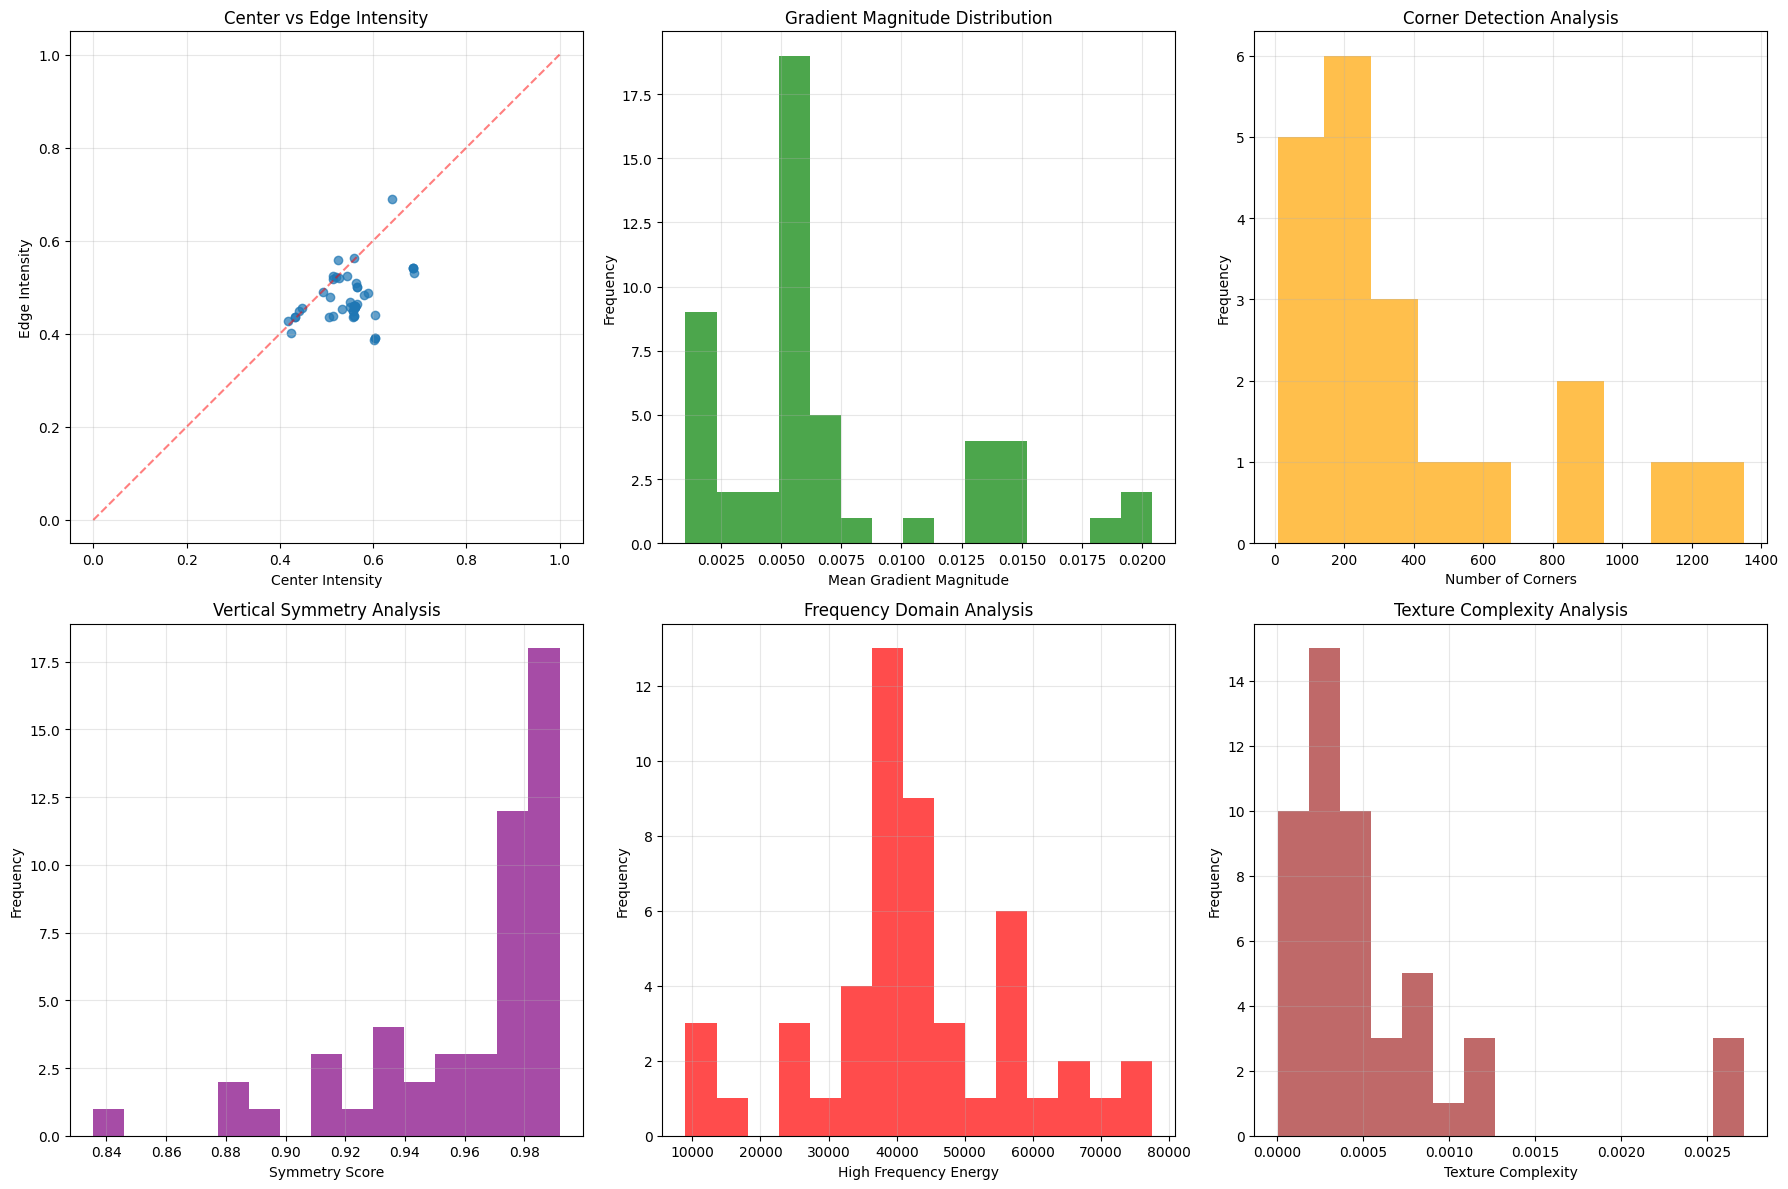

In [21]:
spatial_patterns = analyze_spatial_patterns(X_train_cls, y_labels)
eda_results['spatial_patterns'] = spatial_patterns

### Spatial Patterns Analysis Summary

| Spatial Feature        | Most Distinctive Class | Least Distinctive Class | Recommendation                          |
|------------------------|------------------------|--------------------------|------------------------------------------|
| **Center Positioning** | AIRPLANE               | BIRD                     | Use spatial attention for AIRPLANE       |
| **Edge Definition**    | DRONE                  | BIRD                     | Enhance edge detection for DRONE         |
| **Corner Features**    | BIRD                   | AIRPLANE                 | Extract corner features for BIRD         |
| **Symmetry**           | AIRPLANE               | BIRD                     | Use symmetry features for aircraft       |
| **Texture Complexity** | BIRD                   | AIRPLANE                 | Focus on texture for BIRD classification |


### Classification Strategy Implications

- **AIRPLANE**: Leverage high symmetry and center positioning
- **DRONE**: Utilize geometric corner patterns and edge definition
- **HELICOPTER**: Focus on complex rotor blade spatial patterns
- **BIRD**: Extract rich texture and natural shape variations


### Summary Table

| Class       | Most Helpful Features                     | Weakest Feature(s)       | Suggested Strategy                                      |
|-------------|--------------------------------------------|---------------------------|----------------------------------------------------------|
| **AIRPLANE**| Center Positioning, Symmetry               | Texture Complexity        | Use symmetry + spatial attention                         |
| **DRONE**   | Edge Definition                            | —                         | Enhance edge detection with geometric filters            |
| **HELICOPTER** | —                                       | —                         | Focus on unique rotor-based spatial patterns             |
| **BIRD**    | Corner Features, Texture Complexity        | Center Positioning, Symmetry | Boost texture extraction and corner detection         |


### General Observations

- **AIRPLANE** class benefits from structural uniformity (centered, symmetrical aircraft), making spatial attention and symmetry-based features particularly effective.
- **DRONE** detection thrives on strong edge features, thanks to their distinct shapes and technical structure.
- **BIRD** is the most challenging due to irregular shapes and motion blur. It relies heavily on texture and corner features to distinguish from mechanical objects.
- **HELICOPTER** shows no clear dominant spatial feature but may benefit from focusing on rotor complexity and irregular symmetry patterns.

# Image Preprocessing

## Denoising Images

Denoising is the process of removing noise (unwanted random variations or artifacts) from data — especially images, audio, or signals — to improve quality and clarity.

In image denoising, the goal is to:
* Preserve important features like edges and textures
* Eliminate unwanted variations like grain, blur, or compression artifacts

We performed 8 types of denoising techniques:

* Gaussian Blur
* Median Filter
* Bilateral Filter
* Non-local Means Denoising
* Grayscale conversion
* Edge Enhancement (Unsharp Masking)
* Histogram Equalization
* CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [22]:
def apply_denoising_techniques(X, y_labels=None, sample_idx=0):
    '''
    Apply various denoising and preprocessing techniques
    '''
    print("="*60)
    print("Denoising and Preprocessing")
    print("="*60)

    # Select a sample image for demonstration
    sample_idx = 0
    sample_img = X[sample_idx]

    # Convert to uint8 for OpenCV operations
    sample_img_uint8 = (sample_img * 255).astype(np.uint8)

    # Apply various denoising techniques
    techniques = {}

    # Gaussian Blur
    gaussian_blur = cv2.GaussianBlur(sample_img_uint8, (5, 5), 0)
    techniques['Gaussian Blur'] = gaussian_blur / 255.0

    # Median Filter
    median_filter = cv2.medianBlur(sample_img_uint8, 5)
    techniques['Median Filter'] = median_filter / 255.0

    # Bilateral Filter
    bilateral_filter = cv2.bilateralFilter(sample_img_uint8, 9, 75, 75)
    techniques['Bilateral Filter'] = bilateral_filter / 255.0

    # Non-local Means Denoising
    nlm_denoised = cv2.fastNlMeansDenoisingColored(sample_img_uint8, None, 10, 10, 7, 21)
    techniques['NLM Denoising'] = nlm_denoised / 255.0

    # Grayscale conversion
    gray_img = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2GRAY)
    techniques['Grayscale'] = gray_img / 255.0

    # Edge Enhancement (Unsharp Masking)
    gaussian = cv2.GaussianBlur(sample_img_uint8, (0, 0), 2.0)
    unsharp_mask = cv2.addWeighted(sample_img_uint8, 1.5, gaussian, -0.5, 0)
    techniques['Edge Enhanced'] = unsharp_mask / 255.0

    # Histogram Equalization
    img_yuv = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    hist_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    techniques['Histogram Equalized'] = hist_eq / 255.0

    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img_lab = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2LAB)
    img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
    clahe_img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    techniques['CLAHE'] = clahe_img / 255.0

    # Visualize all techniques
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()

    # Original image
    axes[0].imshow(sample_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Denoised images
    for i, (name, img) in enumerate(techniques.items(), 1):
        if len(img.shape) == 3:
            axes[i].imshow(img)
        else:
            axes[i].imshow(img, cmap='gray')
        axes[i].set_title(name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("images/denoised_images.png")
    plt.show()

    # Apply denoising to entire dataset
    print("\nApplying Gaussian blur to entire dataset...")
    X_denoised = np.zeros_like(X)
    for i in range(len(X)):
        img_uint8 = (X[i] * 255).astype(np.uint8)
        blurred = cv2.GaussianBlur(img_uint8, (3, 3), 0)
        X_denoised[i] = blurred / 255.0

        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(X)} images")

    return X_denoised, techniques

### Apply denoising techniques


Applying denoising techniques on Train Data...
Denoising and Preprocessing


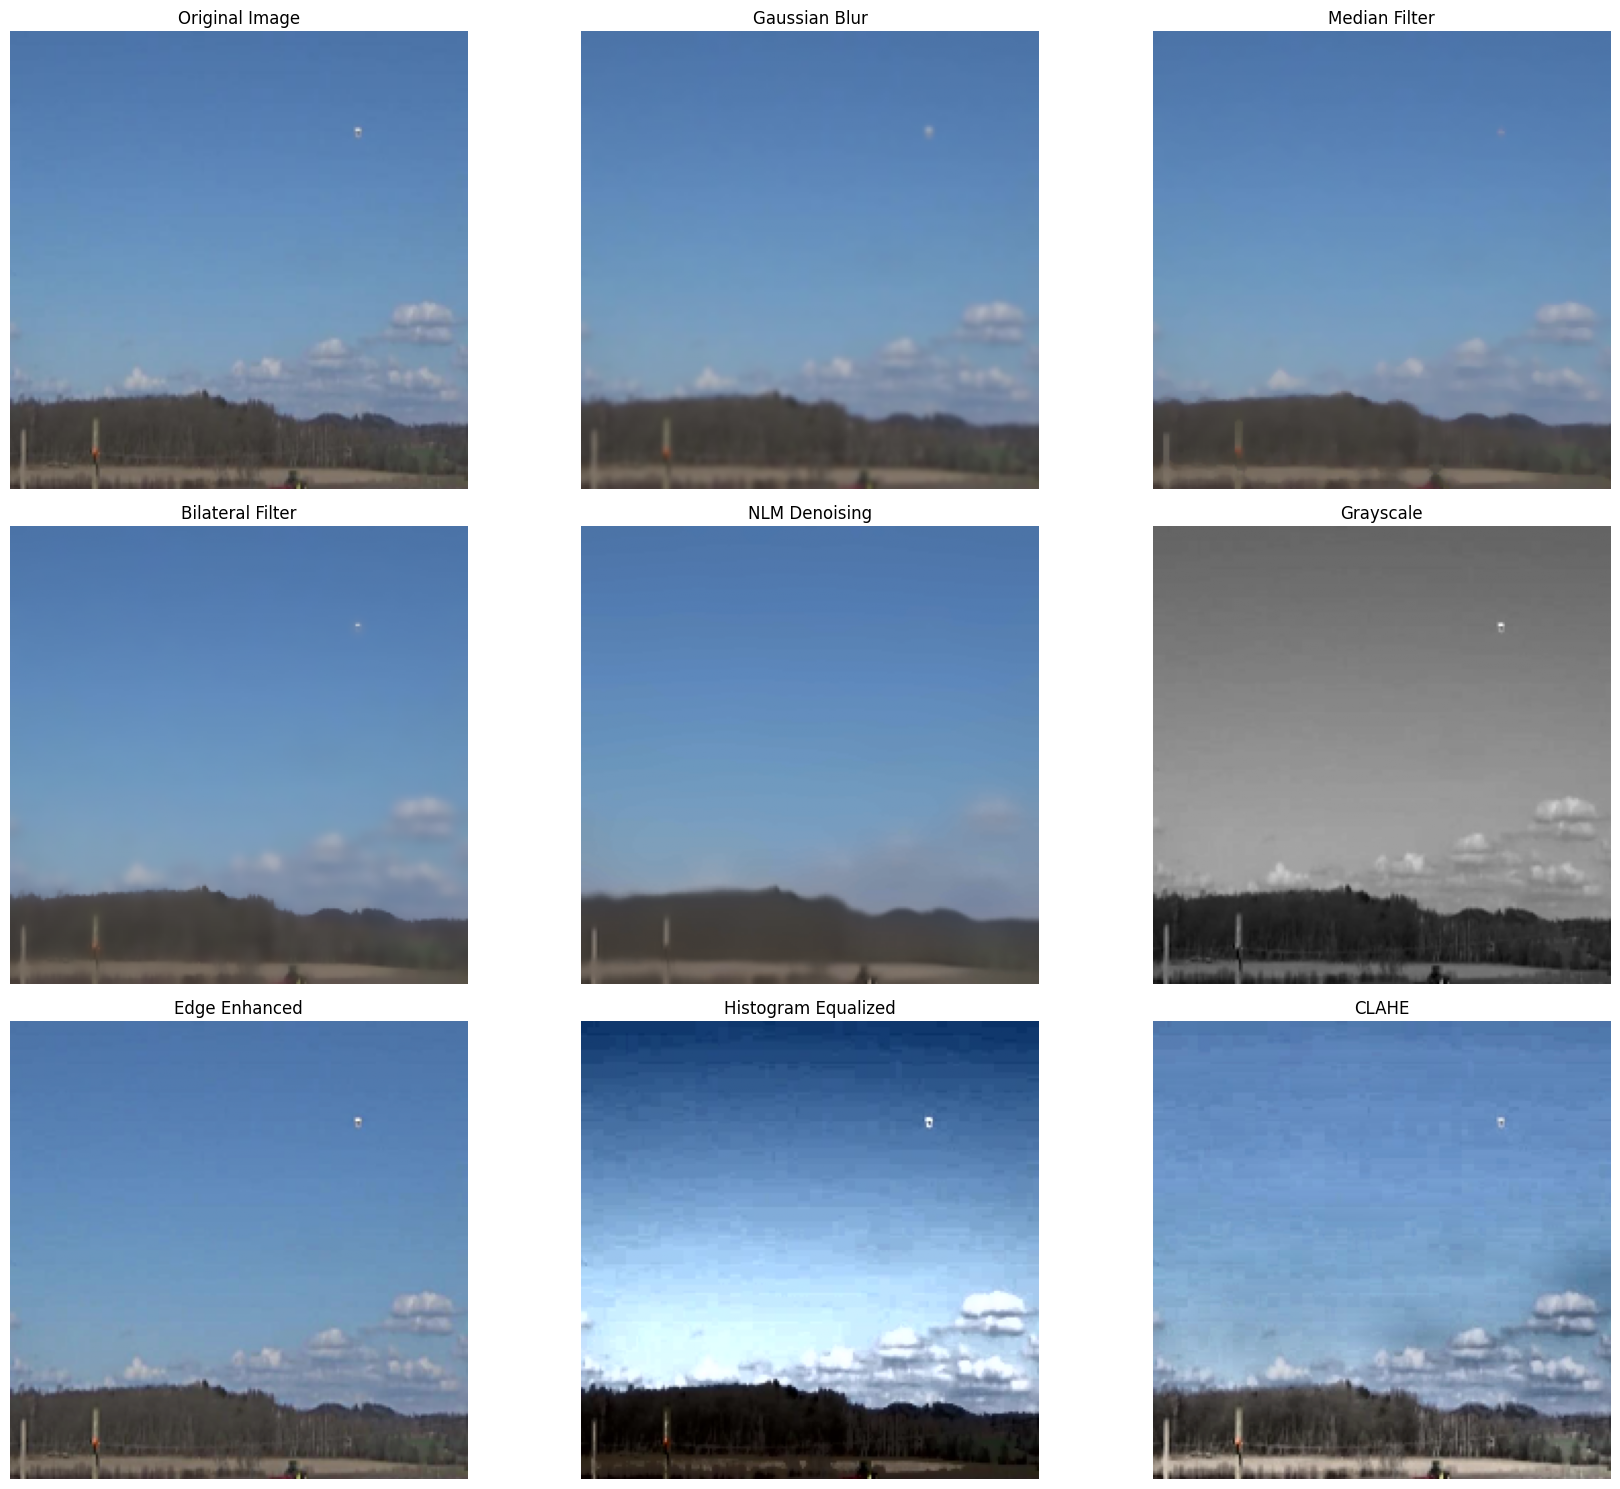


Applying Gaussian blur to entire dataset...
Processed 100/2100 images
Processed 200/2100 images
Processed 300/2100 images
Processed 400/2100 images
Processed 500/2100 images
Processed 600/2100 images
Processed 700/2100 images
Processed 800/2100 images
Processed 900/2100 images
Processed 1000/2100 images
Processed 1100/2100 images
Processed 1200/2100 images
Processed 1300/2100 images
Processed 1400/2100 images
Processed 1500/2100 images
Processed 1600/2100 images
Processed 1700/2100 images
Processed 1800/2100 images
Processed 1900/2100 images
Processed 2000/2100 images
Processed 2100/2100 images


In [23]:
print("\nApplying denoising techniques on Train Data...")
X_train_denoised, denoising_techniques = apply_denoising_techniques(X_train_cls, y_train_cls)


Applying denoising techniques on Validation Data...
Denoising and Preprocessing


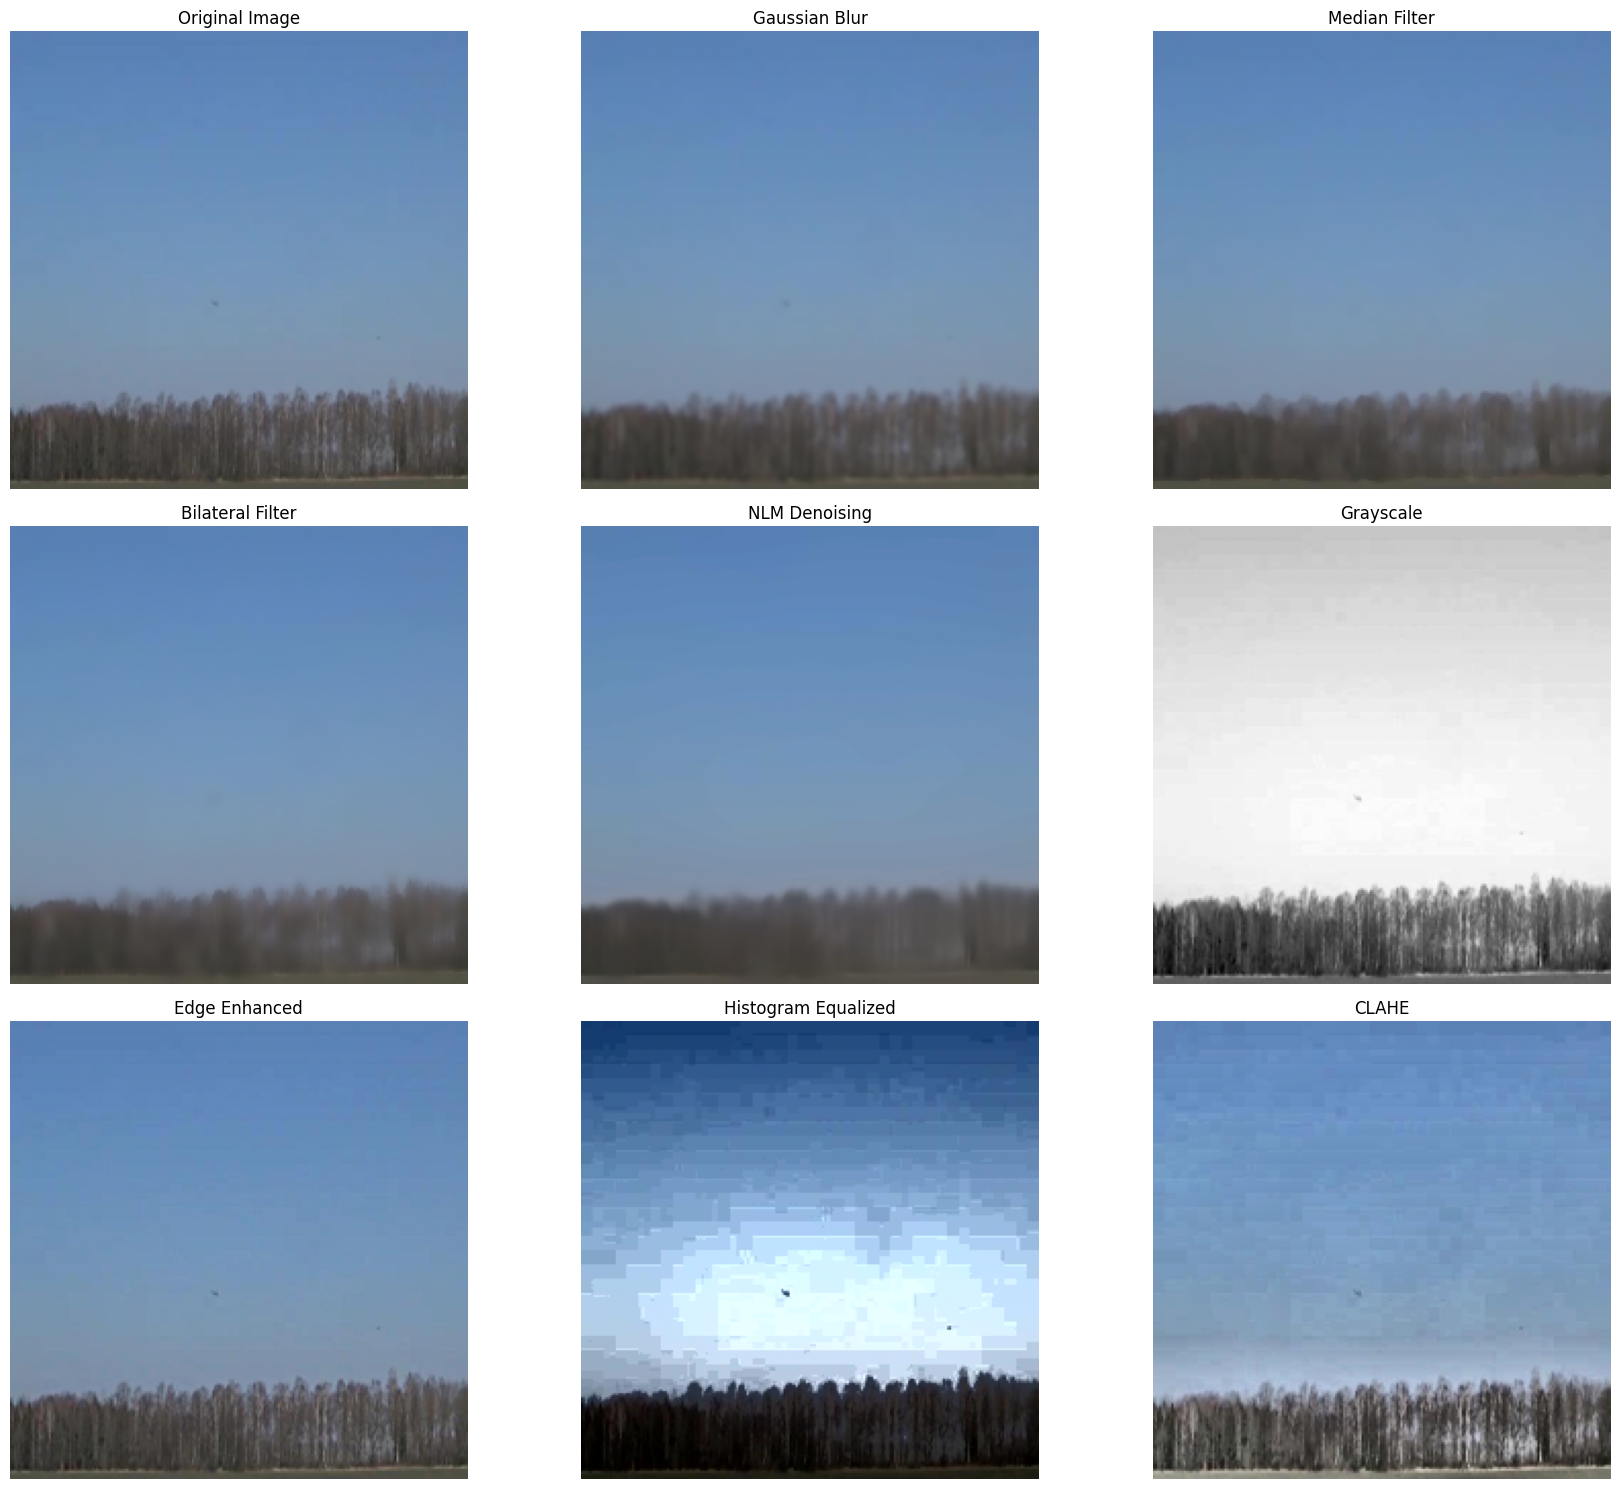


Applying Gaussian blur to entire dataset...
Processed 100/400 images
Processed 200/400 images
Processed 300/400 images
Processed 400/400 images


In [24]:
print("\nApplying denoising techniques on Validation Data...")
X_val_denoised, denoising_techniques = apply_denoising_techniques(X_val_cls, y_val_cls, sample_idx=21)

# Feature Extractions

Image Feature extraction involves transforming raw data into meaningful information that machine learning models can learn from.

## Sobel Filter Edge Detection

The Sobel filter is a edge detection operator used in image processing and computer vision to find edges based on gradients.

It highlights regions of the image with high spatial frequency — i.e., where the intensity (brightness) changes sharply. These are often boundaries or outlines of objects in the image.

In [25]:
def sobel_filter_edge_detection(image):
    '''
    Safe Sobel filter with fallback
    '''
    try:
        return filters.sobel(image)
    except:
        # Fallback: manual Sobel implementation
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

        # Apply convolution (simplified)
        grad_x = cv2.filter2D(image.astype(np.float32), -1, sobel_x)
        grad_y = cv2.filter2D(image.astype(np.float32), -1, sobel_y)

        return np.sqrt(grad_x**2 + grad_y**2)

## Feature extraction for Random Forest Classifier

**Visualize distributions of most important features for Random Forest**

In [26]:
def visualize_rf_feature_distributions(X_features, y_labels, feature_names, num_features=12):
    '''
    Visualize distributions of most important features for Random Forest
    '''
    print("="*60)
    print("Visualizing Feature Distribution - RandomForest")
    print("="*60)

    # For demonstration, show distributions of first num_features features
    features_to_show = min(num_features, len(feature_names))

    rows = (features_to_show + 2) // 3
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten()

    colors = ['blue', 'red', 'green', 'orange']

    for i in range(features_to_show):
        ax = axes[i]
        feature_data = X_features[:, i]

        # Plot histogram by class
        for class_id in np.unique(y_labels):
            mask = y_labels == class_id
            if np.sum(mask) > 0:
                ax.hist(feature_data[mask], bins=20, alpha=0.7,
                       color=colors[class_id], label=class_names[class_id])

        ax.set_title(f'{feature_names[i]}')
        ax.set_xlabel('Feature Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(features_to_show, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("images/rf_features_distribution.png")
    plt.show()

**Extract features for Random Forest model**

We extracted 7 features for Random Forest Model

* Basic Statistical Features (per channel + grayscale)
* Grayscale Statistical Features
* Color Histogram Features
* Texture Features (gradient-based)
* Local Binary Pattern Features
* Spatial Features
* HOG Features (reduced dimensionality)

In [27]:
def extract_rf_features(X, y_labels=None):
    '''
    Extract features for Random Forest model
    '''
    print("="*60)
    print("Extracting Features - RandomForest")
    print("="*60)

    n_samples = len(X)
    print(f"Extracting features from {n_samples} images...")

    all_features = []
    feature_names = []

    for i, img in enumerate(X):
        img_features = []

        # Convert to different color spaces for feature extraction
        gray = rgb2gray(img)

        # Basic Statistical Features (per channel + grayscale)
        for ch_idx, ch_name in enumerate(['R', 'G', 'B']):
            channel = img[:, :, ch_idx]
            img_features.extend([
                np.mean(channel),
                np.std(channel),
                np.min(channel),
                np.max(channel),
                np.median(channel),
                scipy_stats.skew(channel.flatten()),
                scipy_stats.kurtosis(channel.flatten()),
                np.percentile(channel, 25),
                np.percentile(channel, 75)
            ])

            if i == 0:  # Add feature names only once
                feature_names.extend([
                    f'{ch_name}_mean', f'{ch_name}_std', f'{ch_name}_min', f'{ch_name}_max',
                    f'{ch_name}_median', f'{ch_name}_skew', f'{ch_name}_kurtosis',
                    f'{ch_name}_q25', f'{ch_name}_q75'
                ])

        # Grayscale Statistical Features
        hist, _ = np.histogram(gray.flatten(), bins=256, density=True)
        hist = hist[hist > 0]
        entropy_val = -np.sum(hist * np.log2(hist + 1e-10))

        img_features.extend([
            np.mean(gray),
            np.std(gray),
            entropy_val,
            np.var(gray),
            scipy_stats.skew(gray.flatten()),
            scipy_stats.kurtosis(gray.flatten())
        ])

        if i == 0:
            feature_names.extend([
                'gray_mean', 'gray_std', 'gray_entropy', 'gray_var',
                'gray_skew', 'gray_kurtosis'
            ])

        # Color Histogram Features
        for ch_idx, ch_name in enumerate(['R', 'G', 'B']):
            channel = img[:, :, ch_idx]
            hist_ch = np.histogram(channel, bins=8, range=(0, 1))[0]
            hist_ch = hist_ch / np.sum(hist_ch + 1e-10)  # Normalize
            img_features.extend(hist_ch)

            if i == 0:
                feature_names.extend([f'{ch_name}_hist_{j}' for j in range(8)])

        # Texture Features (gradient-based)
        grad_x = np.gradient(gray, axis=1)
        grad_y = np.gradient(gray, axis=0)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Edge density
        edge_density = np.sum(sobel_filter_edge_detection(gray)) / (gray.shape[0] * gray.shape[1])

        img_features.extend([
            np.mean(gradient_magnitude),
            np.std(gradient_magnitude),
            edge_density,
            np.mean(np.abs(grad_x)),
            np.mean(np.abs(grad_y))
        ])

        if i == 0:
            feature_names.extend([
                'grad_magnitude_mean', 'grad_magnitude_std', 'edge_density',
                'grad_x_mean', 'grad_y_mean'
            ])

        # Local Binary Pattern Features
        try:
            gray_uint8 = img_as_ubyte(gray)
            lbp = local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, density=True)
            img_features.extend(lbp_hist)

            if i == 0:
                feature_names.extend([f'lbp_hist_{j}' for j in range(10)])
        except:
            # Fallback: simple texture features
            img_features.extend([0] * 10)
            if i == 0:
                feature_names.extend([f'lbp_fallback_{j}' for j in range(10)])

        # Spatial Features
        h, w = gray.shape

        # Center vs edge intensity
        center_region = gray[h//4:3*h//4, w//4:3*w//4]
        edge_regions = [
            gray[:h//4, :],  # top
            gray[3*h//4:, :],  # bottom
            gray[:, :w//4],  # left
            gray[:, 3*w//4:]  # right
        ]

        center_intensity = np.mean(center_region)
        edge_intensity = np.mean([np.mean(region) for region in edge_regions if region.size > 0])

        # Symmetry features
        left_half = gray[:, :w//2]
        right_half = np.fliplr(gray[:, w//2:])
        min_width = min(left_half.shape[1], right_half.shape[1])
        min_height = min(left_half.shape[0], right_half.shape[0])

        if min_width > 0 and min_height > 0:
            left_half = left_half[:min_height, :min_width]
            right_half = right_half[:min_height, :min_width]
            symmetry_score = 1 - np.mean(np.abs(left_half - right_half))
        else:
            symmetry_score = 0

        img_features.extend([
            center_intensity,
            edge_intensity,
            center_intensity - edge_intensity,
            symmetry_score
        ])

        if i == 0:
            feature_names.extend([
                'center_intensity', 'edge_intensity', 'center_edge_diff', 'symmetry_score'
            ])

        # HOG Features (reduced dimensionality)
        try:
            hog_features = hog(gray, orientations=6, pixels_per_cell=(16, 16),
                             cells_per_block=(2, 2), visualize=False)
            # Take only first 20 HOG features to keep dimensionality manageable
            img_features.extend(hog_features[:20])

            if i == 0:
                feature_names.extend([f'hog_{j}' for j in range(20)])
        except:
            # Fallback: zero features
            img_features.extend([0] * 20)
            if i == 0:
                feature_names.extend([f'hog_fallback_{j}' for j in range(20)])

        all_features.append(img_features)

        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{n_samples} images")

    all_features = np.array(all_features)
    print(f"Extracted {all_features.shape[1]} features from {all_features.shape[0]} images")

    return all_features, feature_names

In [28]:
# Extract features for Random Forest
print("Extracting training features...")
X_train_features, feature_names = extract_rf_features(X_train_cls, y_train_cls)

X_val_features = None
if X_val_cls is not None and len(X_val_cls) > 0:
    print("Extracting validation features...")
    X_val_features, _ = extract_rf_features(X_val_cls, y_val_cls)

X_test_features = None
if X_test_cls is not None and len(X_test_cls) > 0:
    print("Extracting test features...")
    X_test_features, _ = extract_rf_features(X_test_cls, y_test_cls)

Extracting training features...
Extracting Features - RandomForest
Extracting features from 2100 images...
Processed 100/2100 images
Processed 200/2100 images
Processed 300/2100 images
Processed 400/2100 images
Processed 500/2100 images
Processed 600/2100 images
Processed 700/2100 images
Processed 800/2100 images
Processed 900/2100 images
Processed 1000/2100 images
Processed 1100/2100 images
Processed 1200/2100 images
Processed 1300/2100 images
Processed 1400/2100 images
Processed 1500/2100 images
Processed 1600/2100 images
Processed 1700/2100 images
Processed 1800/2100 images
Processed 1900/2100 images
Processed 2000/2100 images
Processed 2100/2100 images
Extracted 96 features from 2100 images
Extracting validation features...
Extracting Features - RandomForest
Extracting features from 400 images...
Processed 100/400 images
Processed 200/400 images
Processed 300/400 images
Processed 400/400 images
Extracted 96 features from 400 images
Extracting test features...
Extracting Features - 

## Visualize feature distributions - Random Forest


RandomForestClassfier Feature Analysis
Visualizing Feature Distribution - RandomForest


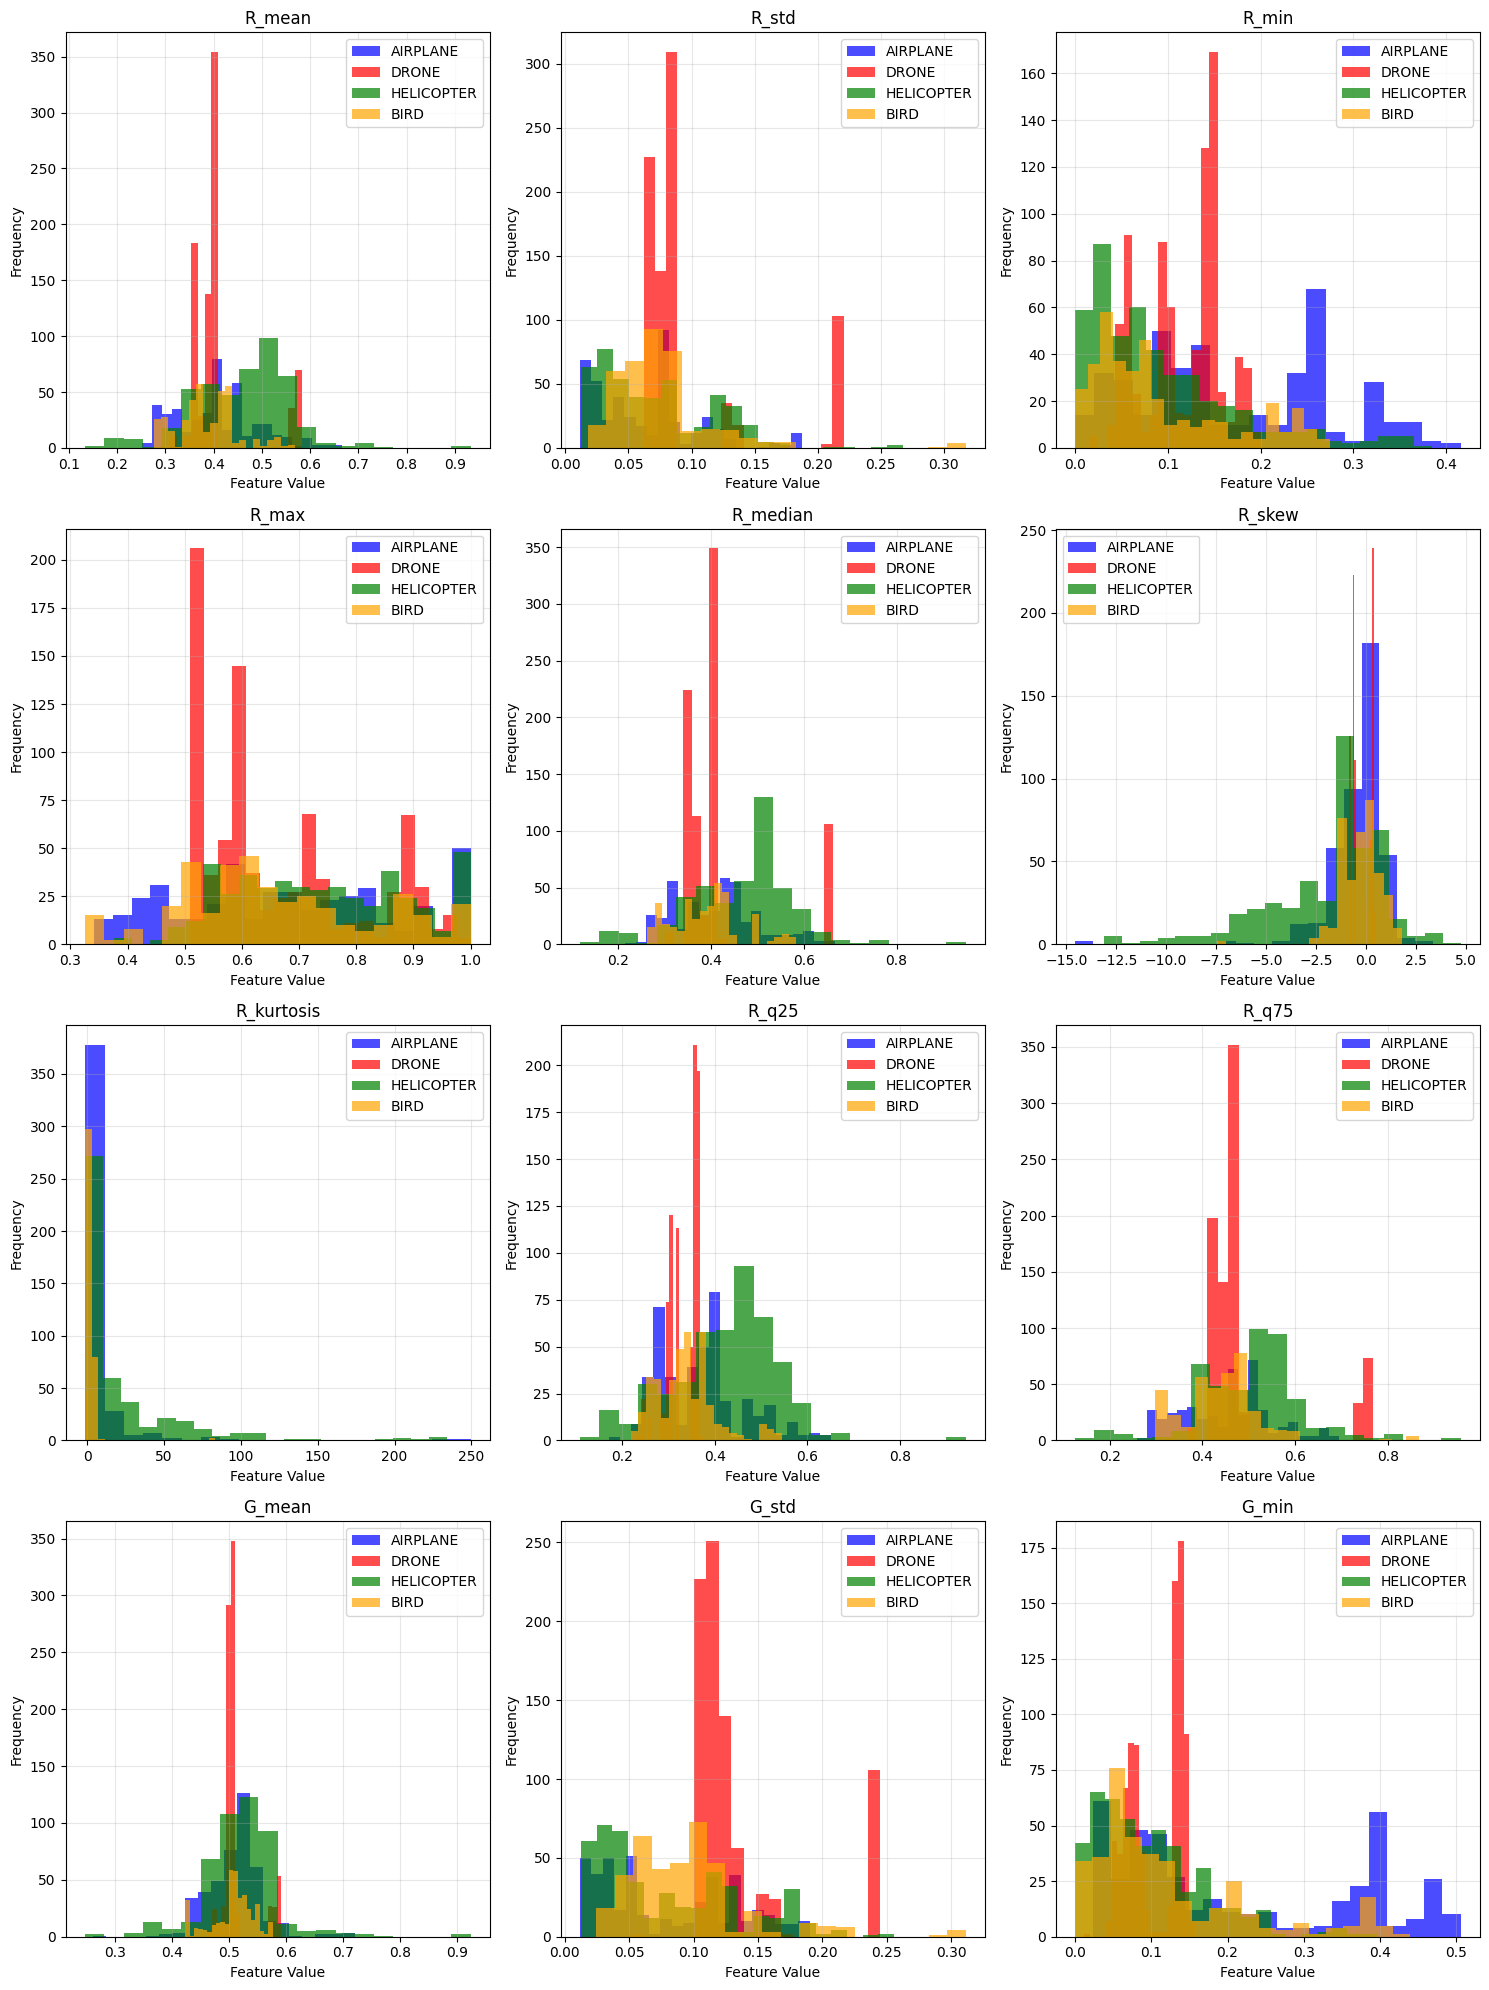

In [29]:
print("\n" + "="*80)
print("RandomForestClassfier Feature Analysis")
print("="*80)

visualize_rf_feature_distributions(X_train_features, y_train_cls, feature_names)

### Color Feature Distribution Analysis (Red & Green Channels)

Below is a summary of each feature plot and what insights we can derive from it:

| **Feature**     | **Description**                                                                 | **Insights from Plot**                                                                                                                                     |
|-----------------|----------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **R_mean**      | Mean intensity of red channel.                                                  | DRONE images (red) have a consistent narrow distribution peaking around 0.45, suggesting standardized brightness. BIRDS show more variability.            |
| **R_std**       | Standard deviation (contrast) of red channel.                                   | DRONEs again show a sharp peak around 0.05, indicating uniform red channel contrast, while other classes like BIRDs have a wider distribution.             |
| **R_min**       | Minimum red intensity in image.                                                 | AIRPLANEs and DRONEs often have lower minimums, possibly due to background. DRONEs sharply peak around 0.1.                                                |
| **R_max**       | Maximum red intensity.                                                          | DRONEs show distinct peak between 0.5–0.6, while AIRPLANEs and BIRDs stretch toward 1.0, indicating brighter red features.                                 |
| **R_median**    | Median red value (robust to outliers).                                          | DRONEs and HELICOPTERs have tight peaks, while BIRDs vary more, reflecting mixed textures/backgrounds.                                                    |
| **R_skew**      | Asymmetry in red distribution.                                                  | DRONEs skew negatively (longer tail on the left), AIRPLANEs slightly positively, suggesting image color bias differences.                                 |
| **R_kurtosis**  | Peakedness of red intensity distribution.                                       | DRONEs show a very high peak near zero, while other classes (esp. BIRDs) have longer tails, implying more outliers or textured content.                   |
| **R_q25**       | 25th percentile (lower quartile) red value.                                     | DRONEs again are tightly clustered, BIRDs show greater spread.                                                                                             |
| **R_q75**       | 75th percentile (upper quartile) red value.                                     | Helps understand spread — DRONEs are tight around 0.45, while BIRDs peak around 0.6–0.7.                                                                   |
| **G_mean**      | Mean green intensity.                                                           | DRONEs show similar pattern as R_mean: narrow, centered peak, suggesting strong color uniformity in drone images.                                          |
| **G_std**       | Standard deviation (contrast) in green channel.                                 | Similar behavior to R_std. DRONEs exhibit low variability. Other classes are broader, especially HELICOPTERs.                                              |
| **G_min**       | Minimum green intensity.                                                        | DRONEs maintain a sharp peak at lower values. AIRPLANEs have a bimodal pattern — some images have low green, others higher.                               |

---

### Key Takeaways:

- **DRONE** images show **high consistency across color stats** — tight peaks, low standard deviation, and low kurtosis. This likely reflects their typical appearance: consistent body color, often against uniform skies.
- **BIRD** and **HELICOPTER** classes exhibit **higher variability** across most features, likely due to varying backgrounds, lighting, and object shapes.
- **AIRPLANEs** fall in between — showing variation in some plots (R_max, G_min) and concentration in others (R_mean, R_q25).

---

### Implications for Modeling for Random Forests:

- These **distribution differences** make the color stats useful features for classification.
- DRONE class, being more narrowly distributed in many features, may be **easier to isolate** using decision trees or ensemble methods.
- BIRD and HELICOPTER classes may require more **complex feature combinations** due to their broader and overlapping distributions.

---

## Perform dimensionality analysis - RandomForest

Dimensionality Reduction Analysis - RandomForest


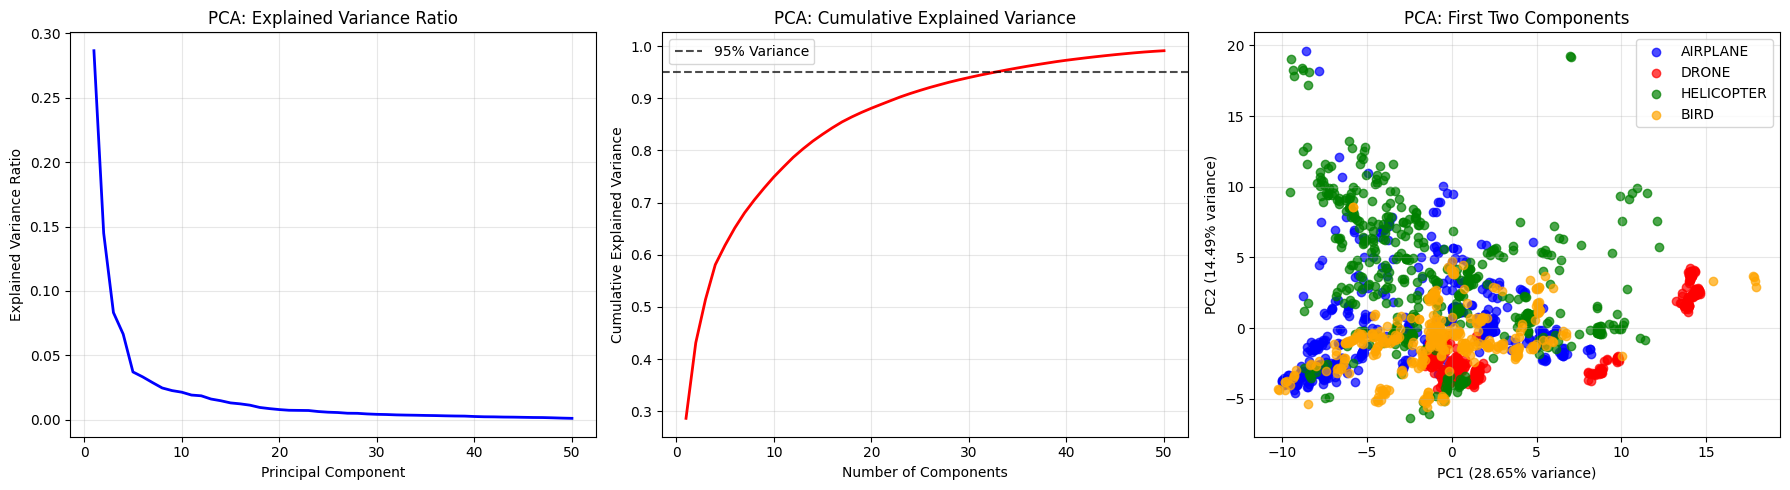

Components needed for 95% variance: 33


In [30]:
pca, n_components_95 = perform_rf_dimensionality_analysis(X_train_features, y_train_cls, feature_names)

### PCA Analysis

| Class        | Separability        | CNN Focus                     | Strategy Summary                                                   | Expected Accuracy |
|--------------|---------------------|-------------------------------|--------------------------------------------------------------------|-------------------|
| **DRONE**    | Best separated     | Geometric shapes              | Early convergence, few PCs needed, simple or shallow models work   | Highest         |
| **AIRPLANE** | Moderate overlap   | Sky-background spatial cues   | Spatial attention + augmentation helps isolate characteristics     | Good            |
| **HELICOPTER** | Widely spread      | Rotor complexity patterns     | Needs deeper CNN layers and ensemble models due to feature mix     | Moderate        |
| **BIRD**     | Most overlapped    | Natural texture variations    | Heavy augmentation + class weighting; benefits from transfer learn | Lowest          |

### Insights

- **PC1** explains **28.65%** variance → primary for class separation (esp. DRONE).
- **PC2** adds **14.49%**, taking cumulative to **43.14%**.
- **Top 10 PCs** capture **~85%** of variance → ideal for compressed feature learning.
- **~35 PCs** required to reach **95%** variance threshold → full information coverage.

### Model Design Takeaways

- **Feature Engineering**: Use first **20–25 PCs** to retain useful info, reduce noise.
- **Class Weighting**: Apply higher weights to **BIRD** and **HELICOPTER** due to overlaps.
- **CNN Architecture**:
  - Shallow, fast learners for **DRONE**
  - Attention layers for **AIRPLANE**
  - Deep, complex structures for **HELICOPTER**
  - Transfer learning + strong augmentation for **BIRD**
- **Random Forest**: Leverages many PCs well; excels on **DRONE**, challenged on **BIRD/HELICOPTER**.

## Feature Extraction for Convolutional Neural Networks (CNNs)

For images, this often means extracting things like:
 * Edges
 * Textures
 * Shapes
 * Keypoints

**Visualizing feature distributions for CNN**

In [31]:
def visualize_cnn_feature_distributions(features_dict, y_labels=None):
    '''
    Visualize distribution of extracted features
    '''
    print("Visualizing feature distributions...")

    n_features = len(features_dict)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    colors = ['blue', 'red', 'green', 'orange']

    for i, (feature_name, features) in enumerate(features_dict.items()):
        if i >= 6:  # Limit to 6 plots
            break

        ax = axes[i]

        # For high-dimensional features, show PCA
        if features.shape[1] > 50:
            # Apply PCA to reduce dimensionality
            pca = PCA(n_components=2)
            features_pca = pca.fit_transform(features)

            if y_labels is not None:
                # Plot by class
                for class_id in np.unique(y_labels):
                    mask = y_labels == class_id
                    ax.scatter(features_pca[mask, 0], features_pca[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
                ax.legend()
                ax.set_title(f'{feature_name} Features (PCA)')
            else:
                ax.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.7)
                ax.set_title(f'{feature_name} Features (PCA)')

            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')

        else:
            # For low-dimensional features, show histogram
            if y_labels is not None:
                # Plot histogram by class
                for class_id in np.unique(y_labels):
                    mask = y_labels == class_id
                    if np.sum(mask) > 0:
                        ax.hist(features[mask, 0], bins=20, alpha=0.7,
                               color=colors[class_id], label=class_names[class_id])
                ax.legend()
            else:
                ax.hist(features[:, 0], bins=20, alpha=0.7)

            ax.set_title(f'{feature_name} Features (First Dimension)')
            ax.set_xlabel('Feature Value')
            ax.set_ylabel('Frequency')

        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/cnn_features_distribution.png")
    plt.show()

**We applied below techniques to extract image features for CNN Model**

*   HOG (Histogram of Oriented Gradients) Features
*   LBP (Local Binary Pattern) Features
*   Color Histogram Features
*   Statistical Features
*   Texture Features
    * Standard deviation
    * Gradient-based texture measures
    * Local variance (texture complexity)
    * Edge density using Sobel filter

In [32]:
def extract_cnn_features(X, y_labels=None):
    '''
    Extract image features
    '''
    print("="*60)
    print("CNN Feature Extraction")
    print("="*60)

    features_dict = {}

    # Select subset for feature extraction (to avoid memory issues)
    subset_size = min(100, len(X))
    subset_indices = np.random.choice(len(X), subset_size, replace=False)
    X_subset = X[subset_indices]
    y_subset = y_labels[subset_indices] if y_labels is not None else None

    print(f"Extracting features from {subset_size} images...")

    # HOG (Histogram of Oriented Gradients) Features
    print("Extracting HOG features...")
    hog_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False)
        hog_features.append(hog_feat)

    hog_features = np.array(hog_features)
    features_dict['HOG'] = hog_features
    print(f"HOG features shape: {hog_features.shape}")

    # LBP (Local Binary Pattern) Features
    print("Extracting LBP features...")
    lbp_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)
        gray_uint8 = img_as_ubyte(gray)
        lbp = local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=10, density=True)
        lbp_features.append(hist)

    lbp_features = np.array(lbp_features)
    features_dict['LBP'] = lbp_features
    print(f"LBP features shape: {lbp_features.shape}")

    # Color Histogram Features
    print("Extracting color histogram features...")
    color_features = []
    for i, img in enumerate(X_subset):
        # RGB histograms
        hist_r = np.histogram(img[:, :, 0], bins=32, range=(0, 1))[0]
        hist_g = np.histogram(img[:, :, 1], bins=32, range=(0, 1))[0]
        hist_b = np.histogram(img[:, :, 2], bins=32, range=(0, 1))[0]

        # Normalize histograms
        hist_r = hist_r / np.sum(hist_r)
        hist_g = hist_g / np.sum(hist_g)
        hist_b = hist_b / np.sum(hist_b)

        color_feat = np.concatenate([hist_r, hist_g, hist_b])
        color_features.append(color_feat)

    color_features = np.array(color_features)
    features_dict['Color_Histogram'] = color_features
    print(f"Color histogram features shape: {color_features.shape}")

    # Statistical Features
    print("Extracting statistical features...")
    statistical_features = []
    for i, img in enumerate(X_subset):
        # Calculate various statistics
        stats = []

        # Per-channel statistics
        for ch in range(3):
            channel = img[:, :, ch]
            stats.extend([
                np.mean(channel),
                np.std(channel),
                np.min(channel),
                np.max(channel),
                np.median(channel),
                scipy_stats.skew(channel.flatten()),
                scipy_stats.kurtosis(channel.flatten())
            ])

        # Overall image statistics
        gray = rgb2gray(img)

        # Calculate entropy using histogram
        hist, _ = np.histogram(gray.flatten(), bins=256, density=True)
        # Remove zeros to avoid log(0) issues
        hist = hist[hist > 0]
        entropy_val = -np.sum(hist * np.log2(hist + 1e-10))

        # Safe edge density calculation
        edge_density = np.sum(sobel_filter_edge_detection(gray))

        stats.extend([
            np.mean(gray),
            np.std(gray),
            entropy_val,
            edge_density
        ])

        statistical_features.append(stats)

    statistical_features = np.array(statistical_features)
    features_dict['Statistical'] = statistical_features
    print(f"Statistical features shape: {statistical_features.shape}")

    # Texture Features
    print("Extracting texture features...")
    texture_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)

        # Standard deviation
        texture_std = np.std(gray)

        # Gradient-based texture measures
        grad_x = np.gradient(gray, axis=1)
        grad_y = np.gradient(gray, axis=0)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Local variance (texture complexity)
        kernel_size = 5
        h, w = gray.shape
        local_vars = []
        for row in range(0, h-kernel_size+1, kernel_size//2):
            for col in range(0, w-kernel_size+1, kernel_size//2):
                patch = gray[row:row+kernel_size, col:col+kernel_size]
                if patch.size > 0:
                    local_vars.append(np.var(patch))

        local_var_mean = np.mean(local_vars) if local_vars else 0

        # Edge density using Sobel filter
        try:
            edge_density = np.sum(filters.sobel(gray))
        except:
            # Fallback edge detection
            edge_density = np.sum(np.abs(grad_x)) + np.sum(np.abs(grad_y))

        # Combine texture features
        texture_feat = [
            texture_std,
            np.mean(gradient_magnitude),
            local_var_mean,
            edge_density / (gray.shape[0] * gray.shape[1])  # Normalize by image size
        ]

        texture_features.append(texture_feat)

    texture_features = np.array(texture_features)
    features_dict['Texture'] = texture_features
    print(f"Texture features shape: {texture_features.shape}")

    # Visualize feature distributions
    visualize_cnn_feature_distributions(features_dict, y_subset)

    return features_dict

CNN Feature Extraction
Extracting features from 100 images...
Extracting HOG features...
HOG features shape: (100, 26244)
Extracting LBP features...
LBP features shape: (100, 10)
Extracting color histogram features...
Color histogram features shape: (100, 96)
Extracting statistical features...
Statistical features shape: (100, 25)
Extracting texture features...
Texture features shape: (100, 4)
Visualizing feature distributions...


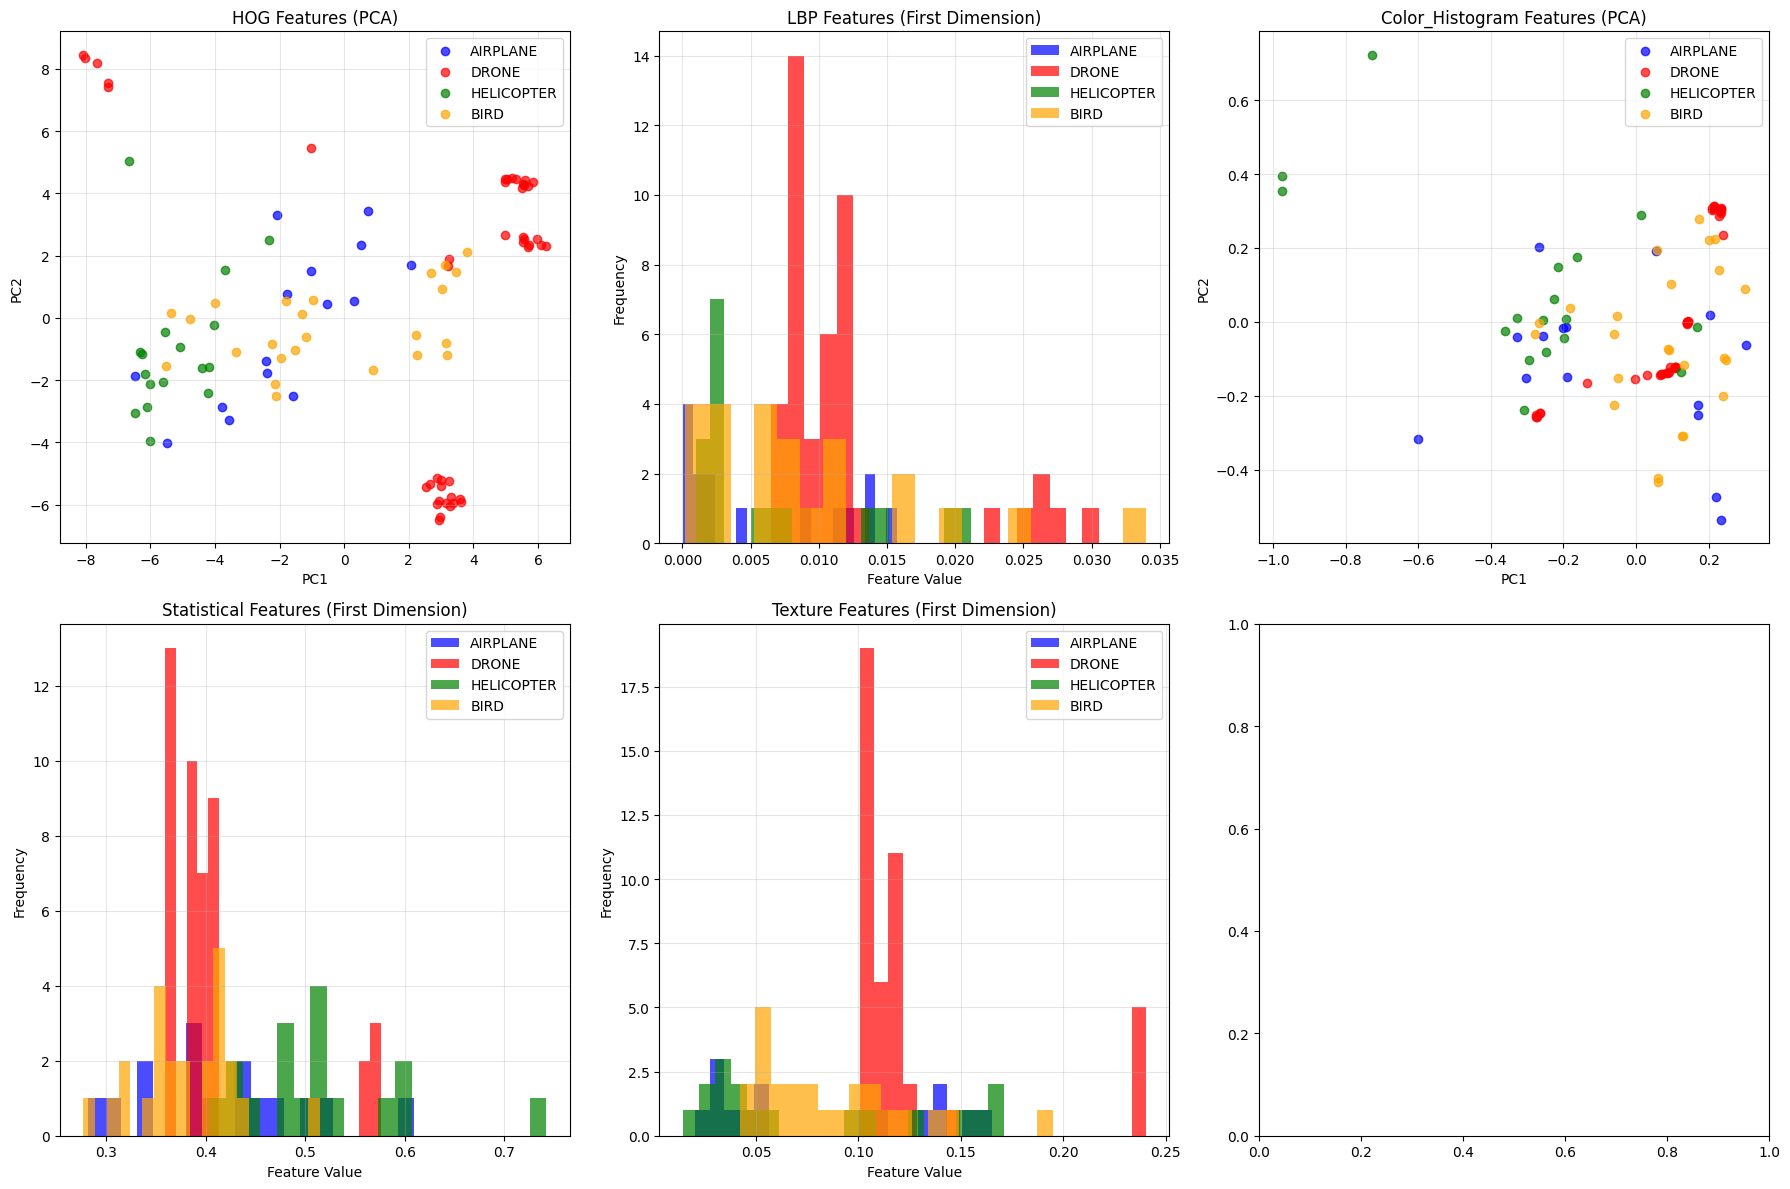

In [33]:
# Extract Image features for CNN
cnn_features = extract_cnn_features(X_train_cls, y_train_cls)

### Feature Extraction Analysis for CNN Drone Classification

| Feature Type            | Best Performance | Characteristics                                                        | Strengths                                                | Weaknesses                                      | CNN Implications                            |
|-------------------------|------------------|------------------------------------------------------------------------|-----------------------------------------------------------|------------------------------------------------|----------------------------------------------|
| HOG Features (PCA)      | AIRPLANE         | Distinct clustering for airplanes, scattered helicopters, overlapping birds | Excellent for structural/shape discrimination, consistent edge patterns | Struggles with organic vs. mechanical shapes | Use for shape-based attention mechanisms     |
| LBP Features            | DRONE            | Drones dominate 0.010–0.015 range, distributed patterns for others     | Strong texture discrimination for manufactured surfaces   | Limited distinction between airplanes/helicopters | High weight in texture feature extraction    |
| Color Histogram (PCA)   | HELICOPTER       | Widest spread for helicopters, clustered airplanes                     | Moderate discrimination, environmental context           | Less distinctive for primary classification   | Secondary feature for context enhancement    |
| Statistical Features    | DRONE/AIRPLANE   | High peaks for drones (~0.40) and airplanes (~0.45)                    | Consistent properties for manufactured objects           | Poor discrimination for complex/natural objects | Feature normalization and consistency checks |
| Texture Features        | DRONE            | Dominant frequency around 0.10–0.12 for drones                         | Excellent manufactured vs. natural distinction           | Minimal bird representation                    | Primary discriminative feature weighting     |


### Class Based Analysis:
| Category    | Distinguishing Features                                              | Classification Difficulty                   |                    |
|-------------|----------------------------------------------------------------------|----------------------------------------------|---------------------------------------------|
| AIRPLANE    | Consistent HOG clustering, moderate color clustering, clear statistical peak | Low – Well-separated in multiple features    |
| DRONE       | Dominates LBP, texture, and statistical features                     | Very Low – Most homogeneous and distinctive  |
| HELICOPTER  | High variability across all features, widest color spread            | High – High intra-class variance             |
| BIRD        | Overlaps significantly with aircraft in most features                | Very High – Organic vs. mechanical confusion |

# Record Performance Metrics

Performance Metrics for RandomForest, CNN Classifier, CNN Optimized and CNN Denoised Models

In [34]:
def record_performance_metrics(dataset_type, model, X_scaled, y_true, model_name='rf'):
    '''
    Record performance metrics for models
    '''
    # Evaluate on data set
    y_pred = model.predict(X_scaled)

    if model_name == 'cnn':
      print("Recording Performance Metrics for CNN:")
      if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)
      if y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)
    else:
      print("Recording Performance Metrics for RandomForest:")

    accuracy = accuracy_score(y_true, y_pred)
    mse = mse_loss(y_true, y_pred)
    mae = mae_loss(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    r2 = r2_score(y_true, y_pred)

    if dataset_type == 'train':
      mse_train_models.append(float(mse.numpy()))
      acc_train_models.append(accuracy)
      mae_train_models.append(float(mae.numpy()))
      precision_train_models.append(precision)
      recall_train_models.append(recall)
      f1_train_models.append(f1)
      r2_train_models.append(r2)
      print(f"\nTraining Accuracy: {accuracy:.4f}")
      print(f"Training MSE: {float(mse.numpy()):.4f}")
      print(f"Training MAE: {float(mae.numpy()):.4f}")
      print(f"Training Precision: {precision:.4f}")
      print(f"Training Recall: {recall:.4f}")
      print(f"Training F1 Score: {f1:.4f}")
      print(f"Training R2 Score: {r2:.4f}")
    elif dataset_type == 'valid':
      mse_val_models.append(float(mse.numpy()))
      acc_val_models.append(accuracy)
      mae_val_models.append(float(mae.numpy()))
      precision_val_models.append(precision)
      recall_val_models.append(recall)
      f1_val_models.append(f1)
      r2_val_models.append(r2)
      print(f"\nValidation Accuracy: {accuracy:.4f}")
      print(f"Validation MSE: {float(mse.numpy()):.4f}")
      print(f"Validation MAE: {float(mae.numpy()):.4f}")
      print(f"Validation Precision: {precision:.4f}")
      print(f"Validation Recall: {recall:.4f}")
      print(f"Validation F1 Score: {f1:.4f}")
      print(f"Validation R2 Score: {r2:.4f}")
    elif dataset_type == 'test':
      mse_test_models.append(float(mse.numpy()))
      acc_test_models.append(accuracy)
      mae_test_models.append(float(mae.numpy()))
      precision_test_models.append(precision)
      recall_test_models.append(recall)
      f1_test_models.append(f1)
      r2_test_models.append(r2)
      print(f"\nTest Accuracy: {accuracy:.4f}")
      print(f"Test MSE: {float(mse.numpy()):.4f}")
      print(f"Test MAE: {float(mae.numpy()):.4f}")
      print(f"Test Precision: {precision:.4f}")
      print(f"Test Recall: {recall:.4f}")
      print(f"Test F1 Score: {f1:.4f}")
      print(f"Test R2 Score: {r2:.4f}")
    else:
        raise ValueError("Invalid dataset_type. Must be 'train', 'val', or 'test'.")

    return accuracy

Comprehensive Performance Metrics for RandomForest, CNN Classifier, CNN Optimized, CNN Denoised and CNN Detection Models

In [35]:
def record_detection_performance_metrics(dataset_type, model, X_data, Y_true, model_name='cnn_detection'):
    '''
    Record performance metrics specifically for CNN detection model
    '''
    print(f"Recording Performance Metrics for CNN Detection Model ({dataset_type}):")

    # Make predictions
    Y_pred = model.predict(X_data, verbose=0)

    # Flatten the arrays for metric calculations
    Y_true_flat = Y_true.reshape(-1)
    Y_pred_flat = Y_pred.reshape(-1)

    # Calculate metrics
    mse = mean_squared_error(Y_true_flat, Y_pred_flat)
    mae = mean_absolute_error(Y_true_flat, Y_pred_flat)
    r2 = r2_score(Y_true_flat, Y_pred_flat)

    # For detection models, we don't have traditional accuracy, precision, recall
    # Instead, we'll use IoU-based metrics and coordinate accuracy

    # Calculate coordinate-wise accuracy (within tolerance)
    tolerance = 0.1  # 10% tolerance for coordinates
    coord_accuracy = calculate_coordinate_accuracy(Y_true, Y_pred, tolerance)

    # Calculate bounding box IoU
    avg_iou = calculate_average_iou(Y_true, Y_pred)

    # Store metrics in global lists based on dataset type
    if dataset_type == 'train':
        detection_mse_train.append(mse)
        detection_mae_train.append(mae)
        detection_r2_train.append(r2)
        detection_coord_acc_train.append(coord_accuracy)
        detection_iou_train.append(avg_iou)

        print(f"Training MSE: {mse:.4f}")
        print(f"Training MAE: {mae:.4f}")
        print(f"Training R2 Score: {r2:.4f}")
        print(f"Training Coordinate Accuracy: {coord_accuracy:.4f}")
        print(f"Training Average IoU: {avg_iou:.4f}")

    elif dataset_type == 'valid':
        detection_mse_val.append(mse)
        detection_mae_val.append(mae)
        detection_r2_val.append(r2)
        detection_coord_acc_val.append(coord_accuracy)
        detection_iou_val.append(avg_iou)

        print(f"Validation MSE: {mse:.4f}")
        print(f"Validation MAE: {mae:.4f}")
        print(f"Validation R2 Score: {r2:.4f}")
        print(f"Validation Coordinate Accuracy: {coord_accuracy:.4f}")
        print(f"Validation Average IoU: {avg_iou:.4f}")

    elif dataset_type == 'test':
        detection_mse_test.append(mse)
        detection_mae_test.append(mae)
        detection_r2_test.append(r2)
        detection_coord_acc_test.append(coord_accuracy)
        detection_iou_test.append(avg_iou)

        print(f"Test MSE: {mse:.4f}")
        print(f"Test MAE: {mae:.4f}")
        print(f"Test R2 Score: {r2:.4f}")
        print(f"Test Coordinate Accuracy: {coord_accuracy:.4f}")
        print(f"Test Average IoU: {avg_iou:.4f}")

    return coord_accuracy

**Calculate Coordinate Accuracy**

Coordinate accuracy refers to how accurately the model predicts the bounding box coordinates of the detected objects relative to their ground truth locations.

In [36]:
def calculate_coordinate_accuracy(Y_true, Y_pred, tolerance=0.1):
    '''
    Calculate coordinate accuracy for detection model
    '''
    # Only consider valid boxes (non-zero boxes)
    valid_mask = np.sum(np.abs(Y_true), axis=-1) > 0

    if np.sum(valid_mask) == 0:
        return 0.0

    # Extract valid predictions and ground truth
    valid_true = Y_true[valid_mask]
    valid_pred = Y_pred[valid_mask]

    # Calculate absolute differences
    abs_diff = np.abs(valid_true - valid_pred)

    # Check if coordinates are within tolerance
    within_tolerance = abs_diff <= tolerance

    # Calculate accuracy as percentage of coordinates within tolerance
    accuracy = np.mean(within_tolerance)

    return accuracy

**Calculate average Intersection over Union (IoU) for bounding boxes**

Average Intersection over Union (IoU) is a key metric in object detection tasks that quantifies how well the predicted bounding boxes align with the ground truth boxes over an entire dataset or a batch of predictions.

In [37]:
def calculate_average_iou(Y_true, Y_pred, threshold=0.5):
    '''
    Calculate average Intersection over Union (IoU) for bounding boxes
    '''
    ious = []

    for i in range(len(Y_true)):
        true_boxes = Y_true[i]
        pred_boxes = Y_pred[i]

        # Find valid boxes
        valid_true_mask = np.sum(np.abs(true_boxes), axis=-1) > 0
        valid_pred_mask = np.sum(np.abs(pred_boxes), axis=-1) > threshold

        valid_true_boxes = true_boxes[valid_true_mask]
        valid_pred_boxes = pred_boxes[valid_pred_mask]

        if len(valid_true_boxes) == 0 and len(valid_pred_boxes) == 0:
            ious.append(1.0)  # Perfect match when both have no boxes
        elif len(valid_true_boxes) == 0 or len(valid_pred_boxes) == 0:
            ious.append(0.0)  # No overlap when one has boxes and other doesn't
        else:
            # Calculate IoU for each true box with best matching predicted box
            sample_ious = []
            for true_box in valid_true_boxes:
                best_iou = 0.0
                for pred_box in valid_pred_boxes:
                    iou = calculate_box_iou(true_box, pred_box)
                    best_iou = max(best_iou, iou)
                sample_ious.append(best_iou)

            ious.append(np.mean(sample_ious) if sample_ious else 0.0)

    return np.mean(ious) if ious else 0.0

**Calculate IoU between two bounding boxes**

IoU (Intersection over Union) is a metric used to evaluate how closely two bounding boxes match. It is commonly used in object detection tasks to compare a predicted bounding box with a ground truth (true) bounding box.

In [38]:
def calculate_box_iou(box1, box2):
    '''
    Calculate IoU between two boxes in format [class, x_center, y_center, width, height]
    '''
    # Extract coordinates (ignore class)
    _, x1_center, y1_center, w1, h1 = box1
    _, x2_center, y2_center, w2, h2 = box2

    # Convert center coordinates to corner coordinates
    x1_min, y1_min = x1_center - w1/2, y1_center - h1/2
    x1_max, y1_max = x1_center + w1/2, y1_center + h1/2

    x2_min, y2_min = x2_center - w2/2, y2_center - h2/2
    x2_max, y2_max = x2_center + w2/2, y2_center + h2/2

    # Calculate intersection
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    if inter_x_max <= inter_x_min or inter_y_max <= inter_y_min:
        return 0.0

    intersection = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)

    # Calculate union
    area1 = w1 * h1
    area2 = w2 * h2
    union = area1 + area2 - intersection

    if union <= 0:
        return 0.0

    return intersection / union

**Comprehensive performance metrics table including CNN detection model**

In [39]:
def create_comprehensive_results_table():
    '''
    Create a comprehensive results table including CNN detection model
    '''

    # Create DataFrame with all models
    metrics_df = pd.DataFrame(index=[
        'RandomForestClassifier',
        'Optimized RandomForest',
        'CNN Classification',
        'CNN Classification Denoised',
        'CNN Detection Model'
    ], columns=[
        'Training Time (Seconds)',
        'Accuracy/Coord_Acc Train', 'Accuracy/Coord_Acc Validation', 'Accuracy/Coord_Acc Test',
        'MSE Train', 'MSE Validation', 'MSE Test',
        'MAE Train', 'MAE Validation', 'MAE Test',
        'Precision/IoU Train', 'Precision/IoU Validation', 'Precision/IoU Test',
        'Recall Train', 'Recall Validation', 'Recall Test',
        'F1-Score Train', 'F1-Score Validation', 'F1-Score Test',
        'R2 Score Train', 'R2 Score Validation', 'R2 Score Test'
    ])

    try:
        # Training times
        metrics_df.loc['RandomForestClassifier', 'Training Time (Seconds)'] = model_training_time[0] if len(model_training_time) > 0 else 0
        metrics_df.loc['Optimized RandomForest', 'Training Time (Seconds)'] = model_training_time[1] if len(model_training_time) > 1 else 0
        metrics_df.loc['CNN Classification', 'Training Time (Seconds)'] = model_training_time[2] if len(model_training_time) > 2 else 0
        metrics_df.loc['CNN Classification Denoised', 'Training Time (Seconds)'] = model_training_time[3] if len(model_training_time) > 3 else 0

        # Classification models data
        for i, model_name in enumerate(['RandomForestClassifier', 'Optimized RandomForest', 'CNN Classification', 'CNN Classification Denoised']):
            if i < len(acc_train_models):
                metrics_df.loc[model_name, 'Accuracy/Coord_Acc Train'] = acc_train_models[i]
                metrics_df.loc[model_name, 'Accuracy/Coord_Acc Validation'] = acc_val_models[i] if i < len(acc_val_models) else None
                metrics_df.loc[model_name, 'Accuracy/Coord_Acc Test'] = acc_test_models[i] if i < len(acc_test_models) else None

                metrics_df.loc[model_name, 'MSE Train'] = mse_train_models[i] if i < len(mse_train_models) else None
                metrics_df.loc[model_name, 'MSE Validation'] = mse_val_models[i] if i < len(mse_val_models) else None
                metrics_df.loc[model_name, 'MSE Test'] = mse_test_models[i] if i < len(mse_test_models) else None

                metrics_df.loc[model_name, 'MAE Train'] = mae_train_models[i] if i < len(mae_train_models) else None
                metrics_df.loc[model_name, 'MAE Validation'] = mae_val_models[i] if i < len(mae_val_models) else None
                metrics_df.loc[model_name, 'MAE Test'] = mae_test_models[i] if i < len(mae_test_models) else None

                metrics_df.loc[model_name, 'Precision/IoU Train'] = precision_train_models[i] if i < len(precision_train_models) else None
                metrics_df.loc[model_name, 'Precision/IoU Validation'] = precision_val_models[i] if i < len(precision_val_models) else None
                metrics_df.loc[model_name, 'Precision/IoU Test'] = precision_test_models[i] if i < len(precision_test_models) else None

                metrics_df.loc[model_name, 'Recall Train'] = recall_train_models[i] if i < len(recall_train_models) else None
                metrics_df.loc[model_name, 'Recall Validation'] = recall_val_models[i] if i < len(recall_val_models) else None
                metrics_df.loc[model_name, 'Recall Test'] = recall_test_models[i] if i < len(recall_test_models) else None

                metrics_df.loc[model_name, 'F1-Score Train'] = f1_train_models[i] if i < len(f1_train_models) else None
                metrics_df.loc[model_name, 'F1-Score Validation'] = f1_val_models[i] if i < len(f1_val_models) else None
                metrics_df.loc[model_name, 'F1-Score Test'] = f1_test_models[i] if i < len(f1_test_models) else None

                metrics_df.loc[model_name, 'R2 Score Train'] = r2_train_models[i] if i < len(r2_train_models) else None
                metrics_df.loc[model_name, 'R2 Score Validation'] = r2_val_models[i] if i < len(r2_val_models) else None
                metrics_df.loc[model_name, 'R2 Score Test'] = r2_test_models[i] if i < len(r2_test_models) else None
    except:
        print("Warning: Some original model metrics may not be available")

    # Fill in detection model data
    if len(detection_training_time) > 0:
        metrics_df.loc['CNN Detection Model', 'Training Time (Seconds)'] = detection_training_time[0]

        if len(detection_coord_acc_train) > 0:
            metrics_df.loc['CNN Detection Model', 'Accuracy/Coord_Acc Train'] = detection_coord_acc_train[0]
            metrics_df.loc['CNN Detection Model', 'Accuracy/Coord_Acc Validation'] = detection_coord_acc_val[0] if len(detection_coord_acc_val) > 0 else None
            metrics_df.loc['CNN Detection Model', 'Accuracy/Coord_Acc Test'] = detection_coord_acc_test[0] if len(detection_coord_acc_test) > 0 else None

            metrics_df.loc['CNN Detection Model', 'MSE Train'] = detection_mse_train[0]
            metrics_df.loc['CNN Detection Model', 'MSE Validation'] = detection_mse_val[0] if len(detection_mse_val) > 0 else None
            metrics_df.loc['CNN Detection Model', 'MSE Test'] = detection_mse_test[0] if len(detection_mse_test) > 0 else None

            metrics_df.loc['CNN Detection Model', 'MAE Train'] = detection_mae_train[0]
            metrics_df.loc['CNN Detection Model', 'MAE Validation'] = detection_mae_val[0] if len(detection_mae_val) > 0 else None
            metrics_df.loc['CNN Detection Model', 'MAE Test'] = detection_mae_test[0] if len(detection_mae_test) > 0 else None

            metrics_df.loc['CNN Detection Model', 'Precision/IoU Train'] = detection_iou_train[0]
            metrics_df.loc['CNN Detection Model', 'Precision/IoU Validation'] = detection_iou_val[0] if len(detection_iou_val) > 0 else None
            metrics_df.loc['CNN Detection Model', 'Precision/IoU Test'] = detection_iou_test[0] if len(detection_iou_test) > 0 else None

            # For detection models, Recall and F1-Score are not applicable, so we'll use placeholders
            metrics_df.loc['CNN Detection Model', 'Recall Train'] = 'N/A'
            metrics_df.loc['CNN Detection Model', 'Recall Validation'] = 'N/A'
            metrics_df.loc['CNN Detection Model', 'Recall Test'] = 'N/A'

            metrics_df.loc['CNN Detection Model', 'F1-Score Train'] = 'N/A'
            metrics_df.loc['CNN Detection Model', 'F1-Score Validation'] = 'N/A'
            metrics_df.loc['CNN Detection Model', 'F1-Score Test'] = 'N/A'

            metrics_df.loc['CNN Detection Model', 'R2 Score Train'] = detection_r2_train[0]
            metrics_df.loc['CNN Detection Model', 'R2 Score Validation'] = detection_r2_val[0] if len(detection_r2_val) > 0 else None
            metrics_df.loc['CNN Detection Model', 'R2 Score Test'] = detection_r2_test[0] if len(detection_r2_test) > 0 else None

    return metrics_df

In [40]:
def display_performance_summary():
    '''
    Display a comprehensive performance summary
    '''
    print("="*100)
    print("Comprehensive Model Performance Summary")
    print("="*100)

    metrics_df = create_comprehensive_results_table()

    # Round numerical values for better display
    numeric_columns = metrics_df.select_dtypes(include=[np.number]).columns
    metrics_df[numeric_columns] = metrics_df[numeric_columns].round(4)

    print("\nDetailed Performance Metrics:")
    print("-" * 100)
    print(metrics_df.to_string())

    # Create summary table with key metrics
    summary_df = pd.DataFrame(index=metrics_df.index, columns=[
        'Training Time (s)', 'Test Accuracy/Coord_Acc', 'Test MSE', 'Test MAE', 'Test R2'
    ])

    summary_df['Training Time (s)'] = metrics_df['Training Time (Seconds)']
    summary_df['Test Accuracy/Coord_Acc'] = metrics_df['Accuracy/Coord_Acc Test']
    summary_df['Test MSE'] = metrics_df['MSE Test']
    summary_df['Test MAE'] = metrics_df['MAE Test']
    summary_df['Test R2'] = metrics_df['R2 Score Test']

    print("\n" + "="*80)
    print("Key Performance Metrics Summary")
    print("="*80)
    print(summary_df.to_string())

    return metrics_df, summary_df

In [41]:
def run_detection_model_evaluation():
    '''
    Function to run the evaluation of the detection model
    '''
    print("Running CNN Detection Model evaluation...")

    try:
        metrics_df, summary_df = display_performance_summary()
        return metrics_df, summary_df
    except Exception as e:
        print(f"Error in detection model evaluation: {e}")
        return None, None

print("CNN Detection Model Performance Metrics Extension loaded successfully!")

CNN Detection Model Performance Metrics Extension loaded successfully!


# Model Training

## Random Forest Classifier

In [42]:
def visualize_grid_search_results(results_df, param_grid):
    '''
    Visualize GridSearchCV results to understand parameter importance
    '''
    print("\nVisualizing GridSearchCV Results...")

    # Select parameters with multiple values for visualization
    params_to_plot = []
    for param, values in param_grid.items():
        if len(values) > 1:
            params_to_plot.append(param)

    # Limit to 6 most interesting parameters for visualization
    params_to_plot = params_to_plot[:6]

    if len(params_to_plot) == 0:
        print("No parameters with multiple values to visualize")
        return

    # Create subplots
    n_params = len(params_to_plot)
    cols = min(3, n_params)
    rows = (n_params + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1) if n_params > 1 else [axes]
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    for i, param in enumerate(params_to_plot):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]

        # Group by parameter value and calculate mean score
        param_scores = []
        param_values = []

        for value in param_grid[param]:
            mask = results_df['param_' + param] == value
            if mask.any():
                scores = results_df.loc[mask, 'mean_test_score']
                param_scores.append(scores.mean())
                param_values.append(str(value))

        if param_scores:
            # Create bar plot
            colors = sns.color_palette("husl", len(param_values))
            bars = ax.bar(range(len(param_values)), param_scores, alpha=0.7, color=colors)
            ax.set_xlabel(param)
            ax.set_ylabel('Mean CV Score')
            ax.set_title(f'Effect of {param}')
            ax.set_xticks(range(len(param_values)))
            ax.set_xticklabels(param_values, rotation=45, ha='right')

            # Add value labels on bars
            for j, (bar, score) in enumerate(zip(bars, param_scores)):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                       f'{score:.3f}', ha='center', va='bottom', fontsize=8)

            ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(n_params, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Effect of Parameters on Model Performance', fontsize=16)
    plt.savefig('images/grid_search_param_effect.png')
    plt.show()

In [43]:
def train_baseline_random_forest(X_train_features, y_train, feature_names, X_val_features, y_val, X_test_features, y_test):
    '''
    Train baseline Random Forest model for comparison with GridSearchCV
    '''
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    X_val_scaled = scaler.transform(X_val_features)
    X_test_scaled = scaler.transform(X_test_features)

    print(f"Training samples: {len(X_train_scaled)}")
    print(f"Validation samples: {len(X_val_scaled)}")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")

    # Baseline parameters
    baseline_params = {
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'class_weight': 'balanced',
        'bootstrap': True
    }

    print("Baseline Parameters:")
    for param, value in baseline_params.items():
        print(f"  {param}: {value}")

    # Train baseline Random Forest
    baseline_rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **baseline_params
    )

    baseline_rf.fit(X_train_scaled, y_train)

    # Evaluate on train set
    train_accuracy = record_performance_metrics('train', baseline_rf, X_train_scaled, y_train)
    # Evaluate on validation set
    valid_accuracy = record_performance_metrics('valid', baseline_rf, X_val_scaled, y_val)
    # Evaluate on test set
    test_accuracy = record_performance_metrics('test', baseline_rf, X_test_scaled, y_test)


    return baseline_rf, scaler, train_accuracy, valid_accuracy, test_accuracy, baseline_params

In [44]:
%%time
print("\n" + "="*80)
print("Training Baseline RandomForest")

# Train baseline model for comparison
rf_base_start_time = time.time()
try:
    baseline_rf, baseline_scaler, train_accuracy, valid_accuracy, test_accuracy, baseline_params = train_baseline_random_forest(
        X_train_features, y_train_cls, feature_names, X_val_features, y_val_cls, X_test_features, y_test_cls
    )

    print(f"Baseline Random Forest Training Accuracy: {train_accuracy:.4f}")
    print(f"Baseline Random Forest Validation Accuracy: {valid_accuracy:.4f}")
    print(f"Baseline Random Forest Test Accuracy: {test_accuracy:.4f}")

except Exception as e:
    print(f"Error during baseline Random Forest training: {e}")
    traceback.print_exc()
rf_base_end_time = time.time()
model_training_time.append(rf_base_end_time - rf_base_start_time)


Training Baseline RandomForest
Training samples: 2100
Validation samples: 400
Feature dimension: 96
Baseline Parameters:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  class_weight: balanced
  bootstrap: True
Recording Performance Metrics for RandomForest:

Training Accuracy: 1.0000
Training MSE: 0.0000
Training MAE: 0.0000
Training Precision: 1.0000
Training Recall: 1.0000
Training F1 Score: 1.0000
Training R2 Score: 1.0000
Recording Performance Metrics for RandomForest:

Validation Accuracy: 0.9650
Validation MSE: 0.1550
Validation MAE: 0.0350
Validation Precision: 0.9668
Validation Recall: 0.9650
Validation F1 Score: 0.9651
Validation R2 Score: 0.8501
Recording Performance Metrics for RandomForest:

Test Accuracy: 0.9825
Test MSE: 0.0750
Test MAE: 0.0350
Test Precision: 0.9829
Test Recall: 0.9825
Test F1 Score: 0.9824
Test R2 Score: 0.9286
Baseline Random Forest Training Accuracy: 1.0000
Baseline Random Forest Validation Ac

In [45]:
def perform_grid_search(X_train_features, y_train, feature_names, cv_folds=3, n_jobs=-1):
    '''
    Perform comprehensive GridSearchCV for Random Forest hyperparameter tuning
    '''
    # Scale features for grid search
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    # X_val_scaled = scaler.fit_transform(X_val_features)

    print(f"Training samples: {len(X_train_scaled)}")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")
    print(f"Classes distribution: {Counter(y_train)}")
    print(f"Cross-validation folds: {cv_folds}")

    class_counts = Counter(y_train)
    total_samples = len(y_train)
    class_weights = {cls: total_samples / (len(class_counts) * count)
                    for cls, count in class_counts.items()}

    print(f"Calculated class weights: {class_weights}")

    param_grid = {
        # Number of trees
        'n_estimators': [150, 300, 500],
        # Tree depth - prevent overfitting while capturing complexity
        'max_depth': [15, 20, None],
        # Split criteria
        'criterion': ['gini', 'entropy'],
        # Minimum samples to split - control overfitting
        'min_samples_split': [2, 5, 10],
        # Minimum samples per leaf - generalization control
        'min_samples_leaf': [1, 2, 4],
        # Feature selection strategy
        'max_features': ['sqrt', 'log2'],
        # Sampling strategy
        'bootstrap': [True],
        # Class balancing
        'class_weight': [class_weights],
        # Maximum leaf nodes - tree complexity control
        'max_leaf_nodes': [None, 50, 100]
    }

    # Calculate total combinations
    total_combinations = 1
    for param, values in param_grid.items():
        total_combinations *= len(values)

    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total CV fits: {total_combinations * cv_folds}")
    print("This may take several minutes to complete...")

    # Create Random Forest classifier
    rf = RandomForestClassifier(random_state=42, n_jobs=1)  # Set n_jobs=1 for GridSearch to control parallelism

    # Create stratified cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Create GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=n_jobs,
        verbose=1,
        return_train_score=True
    )

    # Perform grid search
    grid_search.fit(X_train_scaled, y_train)

    # Extract results
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_

    print(f"\nBest Cross-Validation Score: {best_score:.4f}")
    print("\nBest Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Analyze grid search results
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Top 10 parameter combinations
    top_10_results = results_df.nlargest(10, 'mean_test_score')[
        ['mean_test_score', 'std_test_score', 'params']
    ]

    print("\nTop 10 Parameter Combinations:")
    for i, (idx, row) in enumerate(top_10_results.iterrows()):
        print(f"\n{i+1:2d}. Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
        for param, value in row['params'].items():
            print(f"    {param}: {value}")

    return grid_search, scaler, best_params, best_score, results_df, param_grid

In [46]:
%%time
print("\n" + "="*80)
print("RandomForest + GridSearch Hyperparameter Optimization")
print("="*80)

# Perform GridSearchCV
rf_grid_start_time = time.time()
try:
    if run_grid_search:
      grid_search, grid_scaler, best_params, best_score, results_df, param_grid = perform_grid_search(
          X_train_features, y_train_cls, feature_names, cv_folds=3, n_jobs=-1
      )

      print(f"GridSearchCV Best Cross-Validation Score: {best_score:.4f}")
except Exception as e:
    print(f"Error during GridSearchCV: {e}")
    traceback.print_exc()
rf_grid_end_time = time.time()


RandomForest + GridSearch Hyperparameter Optimization
Training samples: 2100
Feature dimension: 96
Classes distribution: Counter({np.int64(1): 834, np.int64(2): 460, np.int64(0): 426, np.int64(3): 380})
Cross-validation folds: 3
Calculated class weights: {np.int64(1): 0.6294964028776978, np.int64(2): 1.141304347826087, np.int64(3): 1.381578947368421, np.int64(0): 1.232394366197183}
Total parameter combinations: 972
Total CV fits: 2916
This may take several minutes to complete...
Fitting 3 folds for each of 972 candidates, totalling 2916 fits

Best Cross-Validation Score: 0.9776

Best Parameters:
  bootstrap: True
  class_weight: {np.int64(1): 0.6294964028776978, np.int64(2): 1.141304347826087, np.int64(3): 1.381578947368421, np.int64(0): 1.232394366197183}
  criterion: entropy
  max_depth: 15
  max_features: sqrt
  max_leaf_nodes: None
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 300

Top 10 Parameter Combinations:

 1. Score: 0.9776 (±0.0060)
    bootstrap: True
    c

**Visualize GridSearch Hyperparameters Importance**


Visualizing GridSearchCV Results...


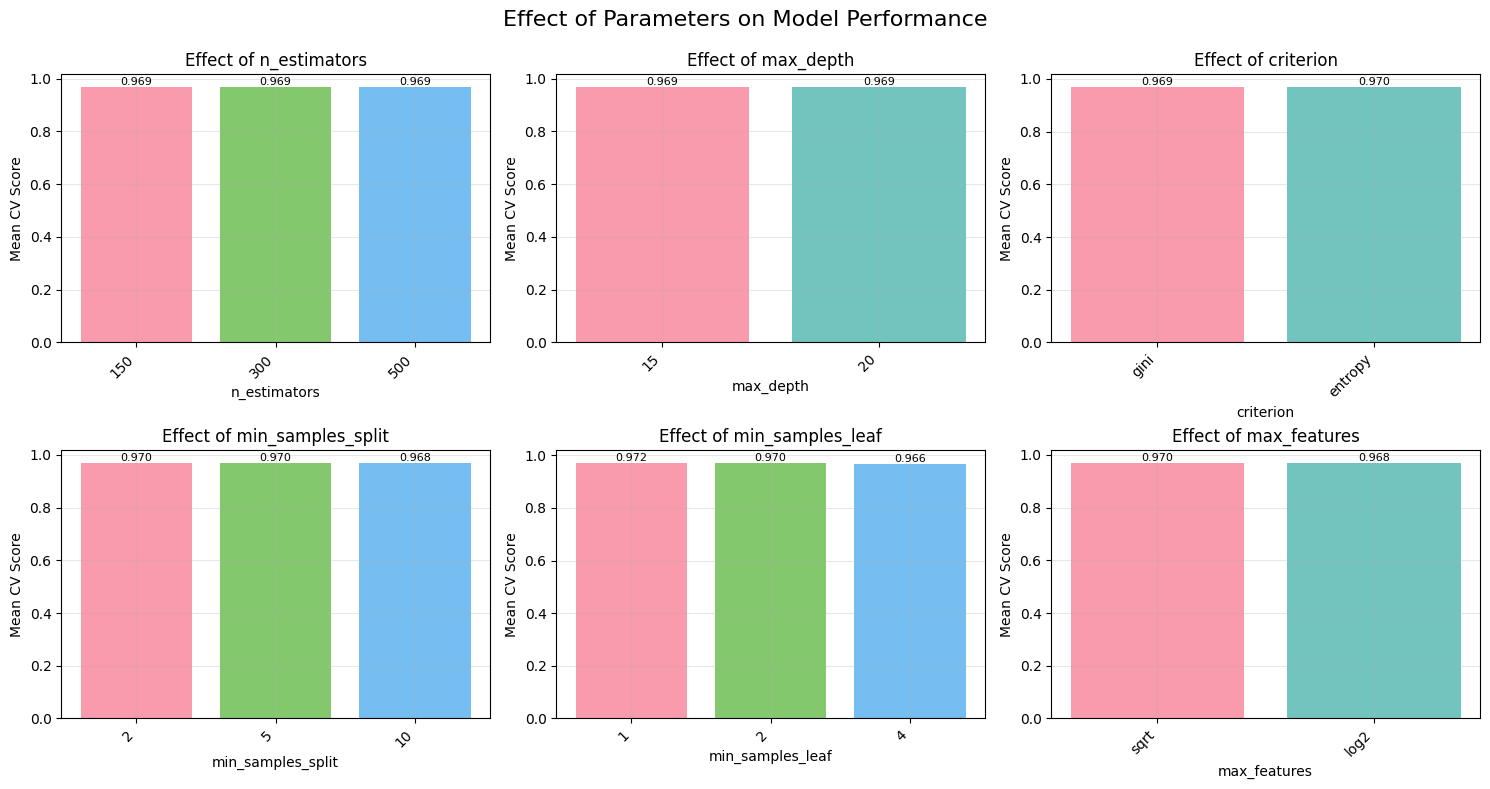

In [47]:
# Visualize parameter importance
visualize_grid_search_results(results_df, param_grid)

In [48]:
def create_feature_importance_df(top_features, top_importance):
    """
    Create DataFrame with feature categories
    """

    def categorize_feature(feature_name):
        feature_lower = feature_name.lower()
        if any(x in feature_lower for x in ['_r_', 'r_mean', 'r_std', 'r_min', 'r_max', 'r_median', 'r_skew', 'r_kurtosis', 'r_q25', 'r_q75', 'r_hist']):
            return 'Red Channel'
        elif any(x in feature_lower for x in ['_g_', 'g_mean', 'g_std', 'g_min', 'g_max', 'g_median', 'g_skew', 'g_kurtosis', 'g_q25', 'g_q75', 'g_hist']):
            return 'Green Channel'
        elif any(x in feature_lower for x in ['_b_', 'b_mean', 'b_std', 'b_min', 'b_max', 'b_median', 'b_skew', 'b_kurtosis', 'b_q25', 'b_q75', 'b_hist']):
            return 'Blue Channel'
        elif 'gray' in feature_lower:
            return 'Grayscale'
        elif any(x in feature_lower for x in ['lbp', 'local_binary']):
            return 'Texture (LBP)'
        elif any(x in feature_lower for x in ['grad', 'edge']):
            return 'Gradient/Edge'
        elif any(x in feature_lower for x in ['center', 'symmetry', 'spatial']):
            return 'Spatial'
        elif 'hog' in feature_lower:
            return 'HOG'
        else:
            return 'Other'

    df = pd.DataFrame({
        'Feature': top_features,
        'Importance': top_importance,
        'Category': [categorize_feature(feat) for feat in top_features]
    })

    df = df.sort_values('Importance', ascending=True)
    return df

In [49]:
def plot_most_important_features(top_features, top_importance):
    '''
    Plot the most important features
    '''
    feature_df = create_feature_importance_df(top_features, top_importance)

    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")

    custom_palette = {
        'Red Channel': '#FF6B6B',
        'Green Channel': '#4ECDC4',
        'Blue Channel': '#45B7D1',
        'Grayscale': '#95A5A6',
        'Texture (LBP)': '#9B59B6',
        'Gradient/Edge': '#2ECC71',
        'Spatial': '#F39C12',
        'HOG': '#E74C3C',
        'Other': '#34495E'
    }

    ax = sns.barplot(
        data=feature_df,
        y='Feature',
        x='Importance',
        hue='Category',
        palette=custom_palette,
        orient='h',
        dodge=False,
        alpha=0.8
    )

    print("\nTop 20 Most Important Features:")
    for feat, imp in zip(reversed(top_features), reversed(top_importance)):
        print(f"  {feat}: {imp:.4f}")

    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title('Top 20 Feature Importance (Optimized Random Forest)', fontsize=14, fontweight='bold', pad=20)
    for i, (idx, row) in enumerate(feature_df.iterrows()):
        plt.text(row['Importance'] + 0.001, i, f'{row["Importance"]:.3f}',
                va='center', fontsize=9, fontweight='bold')
    plt.legend(title='Feature Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    sns.despine()
    plt.tight_layout()
    plt.savefig("images/opti_rf_features_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

In [50]:
def train_optimized_random_forest_model(X_train_features, y_train, best_params, feature_names,
                                       X_val_features, y_val, X_test_features, y_test):
    '''
    Train Random Forest model with optimized hyperparameters
    '''
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    X_val_scaled = scaler.transform(X_val_features)
    X_test_scaled = scaler.transform(X_test_features)

    print(f"Training samples: {len(X_train_scaled)}")
    print(f"Validation samples: {len(X_val_scaled)}")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")
    print(f"Classes distribution in training: {Counter(y_train)}")

    print("\nOptimized Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Train Random Forest with optimized parameters
    rf_model = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **best_params
    )

    rf_model.fit(X_train_scaled, y_train)

    # Evaluate on validation set
    y_val_pred = rf_model.predict(X_val_scaled)

    # Evaluate on train set
    train_accuracy = record_performance_metrics('train', rf_model, X_train_scaled, y_train)
    # Evaluate on validation set
    valid_accuracy = record_performance_metrics('valid', rf_model, X_val_scaled, y_val)
    # Evaluate on test set
    test_accuracy = record_performance_metrics('test', rf_model, X_test_scaled, y_test)

    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=class_names))

    feature_importance = rf_model.feature_importances_

    # Get top 20 most important features
    top_indices = np.argsort(feature_importance)[-20:]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = feature_importance[top_indices]

    print(f"Optimized Random Forest Test Accuracy: {test_accuracy:.4f}")
    print(f"Optimized Random Forest Training Accuracy: {train_accuracy:.4f}")
    print(f"Optimized Random Forest Validation Accuracy: {valid_accuracy:.4f}")
    return rf_model, scaler, y_val_pred, valid_accuracy, feature_importance, top_features, top_importance

In [51]:
%%time
print("\n" + "="*80)
print("Training Optimized RandomForest")
print("="*80)

# Train optimized model with best parameters
rf_opti_start_time = time.time()
try:
    optimized_rf, optimized_scaler, y_val_pred, optimized_valid_accuracy, feature_importance, top_features, top_importance = train_optimized_random_forest_model(
        X_train_features, y_train_cls, best_params, feature_names, X_val_features, y_val_cls, X_test_features, y_test_cls
    )

except Exception as e:
    print(f"Error during optimized Random Forest training: {e}")
    traceback.print_exc()
rf_opti_end_time = time.time()

model_training_time.append(rf_opti_end_time - rf_opti_start_time)


Training Optimized RandomForest
Training samples: 2100
Validation samples: 400
Feature dimension: 96
Classes distribution in training: Counter({np.int64(1): 834, np.int64(2): 460, np.int64(0): 426, np.int64(3): 380})

Optimized Parameters:
  bootstrap: True
  class_weight: {np.int64(1): 0.6294964028776978, np.int64(2): 1.141304347826087, np.int64(3): 1.381578947368421, np.int64(0): 1.232394366197183}
  criterion: entropy
  max_depth: 15
  max_features: sqrt
  max_leaf_nodes: None
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 300
Recording Performance Metrics for RandomForest:

Training Accuracy: 0.9995
Training MSE: 0.0019
Training MAE: 0.0265
Training Precision: 0.9995
Training Recall: 0.9995
Training F1 Score: 0.9995
Training R2 Score: 0.9981
Recording Performance Metrics for RandomForest:

Validation Accuracy: 0.9725
Validation MSE: 0.1275
Validation MAE: 0.0327
Validation Precision: 0.9736
Validation Recall: 0.9725
Validation F1 Score: 0.9725
Validation R2 Score: 0.

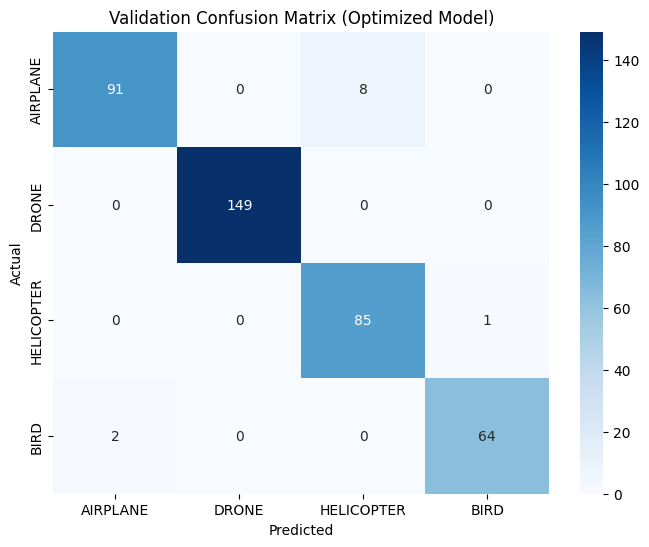

In [52]:
def plot_confusion_matrix(y_val, y_val_pred):
    '''
    Plot confusion matrix
    '''
    # Confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Validation Confusion Matrix (Optimized Model)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("images/opti_rf_confusion_matrix.png")
    plt.show()

plot_confusion_matrix(y_val_cls, y_val_pred)


Top 20 Most Important Features:
  B_hist_1: 0.0505
  center_edge_diff: 0.0407
  G_hist_2: 0.0344
  B_std: 0.0338
  G_hist_1: 0.0314
  R_hist_2: 0.0300
  R_kurtosis: 0.0278
  B_q75: 0.0263
  G_std: 0.0223
  B_hist_4: 0.0210
  R_q25: 0.0205
  gray_var: 0.0196
  R_hist_4: 0.0195
  gray_std: 0.0176
  B_hist_3: 0.0174
  B_hist_2: 0.0170
  grad_x_mean: 0.0155
  R_min: 0.0151
  B_q25: 0.0147
  R_skew: 0.0146


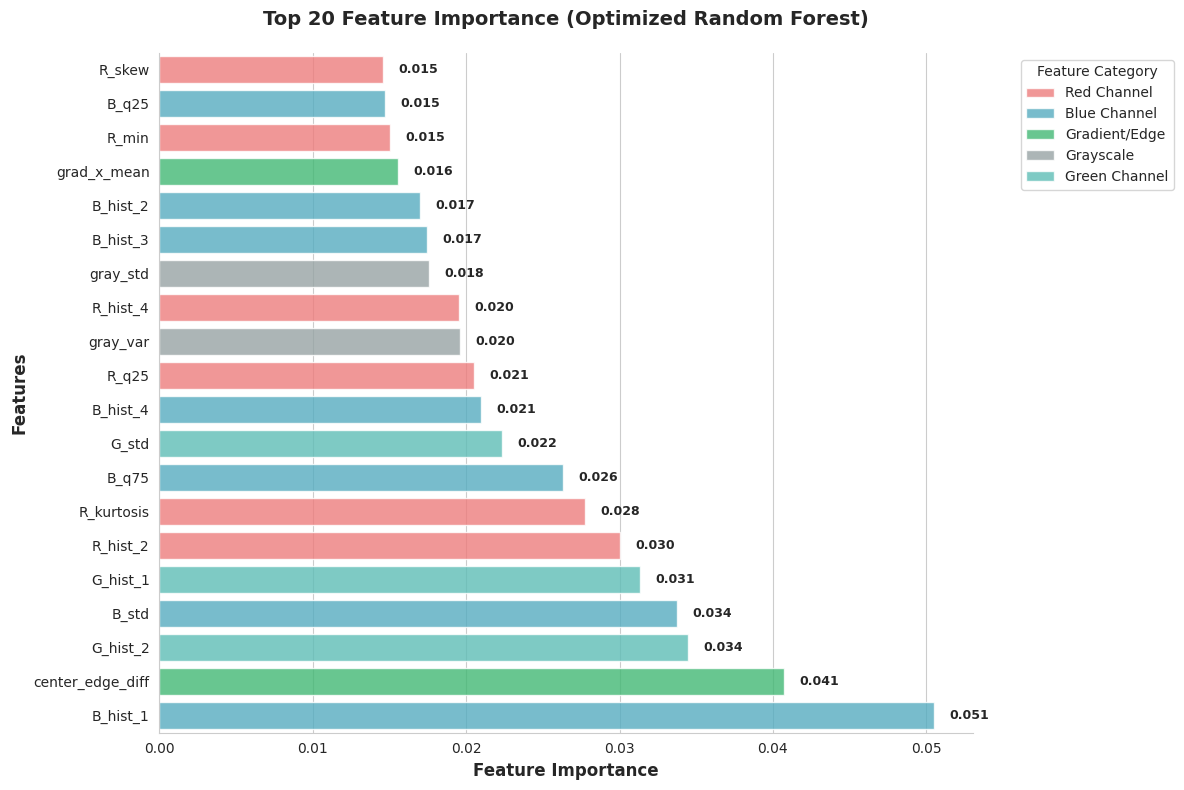

In [53]:
# Visualize feature importance
plot_most_important_features(top_features, top_importance)

## RandomForest Model Comparision

In [54]:
def compare_baseline_vs_optimized(baseline_accuracy, optimized_accuracy, baseline_params, best_params):
    '''
    Compare baseline Random Forest vs GridSearchCV optimized model
    '''
    improvement = optimized_accuracy - baseline_accuracy
    improvement_pct = (improvement / baseline_accuracy) * 100

    print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")
    print(f"Optimized Model Accuracy: {optimized_accuracy:.4f}")
    print(f"Improvement: {improvement:.4f} ({improvement_pct:+.2f}%)")

    if improvement > 0:
        print("✅ GridSearchCV improved model performance!")
    elif improvement == 0:
        print("➡️ GridSearchCV maintained baseline performance")
    else:
        print("⚠️ GridSearchCV resulted in lower performance (possible overfitting)")

    print("\nParameter Comparison:")
    print("Baseline Parameters:")
    for param, value in baseline_params.items():
        print(f"  {param}: {value}")

    print("\nOptimized Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualize comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy comparison
    models = ['Baseline', 'Optimized']
    accuracies = [baseline_accuracy, optimized_accuracy]
    colors = ['lightcoral', 'lightgreen']

    bars = ax1.bar(models, accuracies, color=colors, alpha=0.7)
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Performance Comparison')
    ax1.set_ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

    ax1.grid(True, alpha=0.3, axis='y')

    # Improvement visualization
    if improvement != 0:
        ax2.bar(['Improvement'], [improvement_pct],
                color='green' if improvement > 0 else 'red', alpha=0.7)
        ax2.set_ylabel('Improvement (%)')
        ax2.set_title('Performance Improvement')
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.text(0, improvement_pct + (0.1 if improvement_pct > 0 else -0.1),
                f'{improvement_pct:+.2f}%', ha='center', va='bottom' if improvement_pct > 0 else 'top',
                fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
    else:
        ax2.text(0.5, 0.5, 'No Change', ha='center', va='center',
                fontsize=16, fontweight='bold', transform=ax2.transAxes)
        ax2.set_xlim([0, 1])
        ax2.set_ylim([0, 1])
        ax2.axis('off')

    plt.tight_layout()
    plt.savefig("images/rf_baseline_vs_optimized_performance.png")
    plt.show()


Baseline Vs Optimized Model Comparision
Baseline Model Accuracy: 0.9650
Optimized Model Accuracy: 0.9725
Improvement: 0.0075 (+0.78%)
✅ GridSearchCV improved model performance!

Parameter Comparison:
Baseline Parameters:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  class_weight: balanced
  bootstrap: True

Optimized Parameters:
  bootstrap: True
  class_weight: {np.int64(1): 0.6294964028776978, np.int64(2): 1.141304347826087, np.int64(3): 1.381578947368421, np.int64(0): 1.232394366197183}
  criterion: entropy
  max_depth: 15
  max_features: sqrt
  max_leaf_nodes: None
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 300


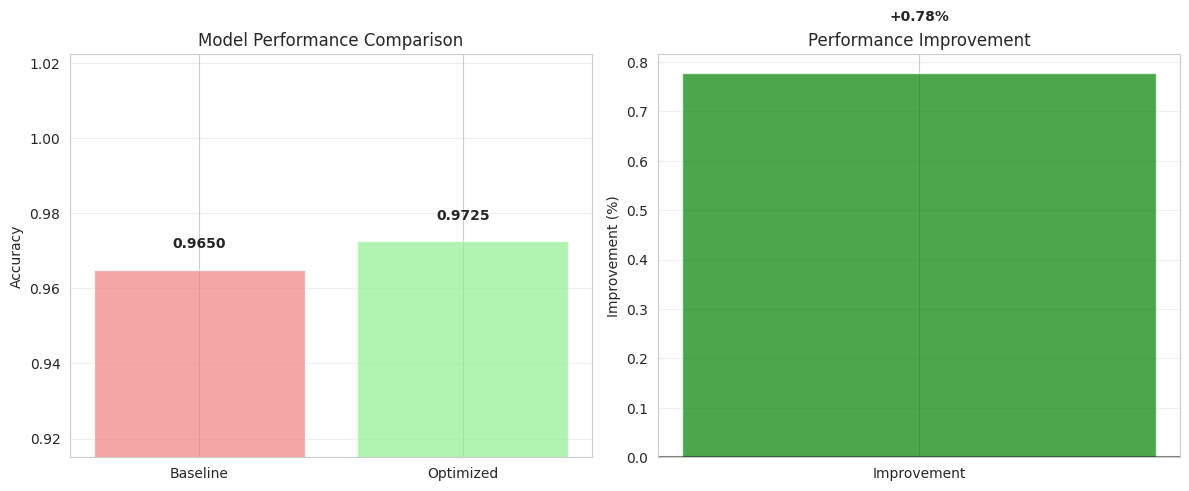

In [55]:
print("\n" + "="*80)
print("Baseline Vs Optimized Model Comparision")
print("="*80)

# Compare baseline vs optimized model
compare_baseline_vs_optimized(valid_accuracy, optimized_valid_accuracy, baseline_params, best_params)

## RandomForest Model Evaluation

In [56]:
def evaluate_random_forest_model(model, scaler, X_test_features, y_test, feature_names):
    '''
    Evaluate Random Forest model on test set
    '''
    # Scale test features
    X_test_scaled = scaler.transform(X_test_features)

    # Make predictions
    y_test_pred = model.predict(X_test_scaled)
    y_test_proba = model.predict_proba(X_test_scaled)

    # Classification report
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Test Confusion Matrix (Optimized Model)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("images/rf_optimized_confusion_matrix.png")
    plt.show()

    # Per-class accuracy
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = (y_test == i)
        if np.sum(class_mask) > 0:
            class_accuracy = accuracy_score(y_test[class_mask], y_test_pred[class_mask])
            print(f"  {class_name}: {class_accuracy:.4f} ({np.sum(class_mask)} samples)")

    return test_accuracy, y_test_pred, y_test_proba

**RandomForest - Analyze and visualize prediction errors**

In [57]:
def analyze_prediction_errors(X_test, y_test, y_pred, y_proba, num_samples=8):
    '''
    Analyze and visualize prediction errors
    '''
    print("="*60)
    print("Analyzing Prediction Errors")
    print("="*60)

    # Find misclassified samples
    misclassified_mask = (y_test != y_pred)
    misclassified_indices = np.where(misclassified_mask)[0]

    if len(misclassified_indices) == 0:
        print("No misclassifications found!")
        return

    print(f"Found {len(misclassified_indices)} misclassified samples out of {len(y_test)}")

    # Select random misclassified samples for visualization
    sample_indices = np.random.choice(misclassified_indices,
                                     min(num_samples, len(misclassified_indices)),
                                     replace=False)

    # Visualize misclassified samples
    rows = (num_samples + 3) // 4
    cols = min(4, num_samples)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(sample_indices):
        row = i // cols
        col = i % cols

        # Display image
        axes[row, col].imshow(X_test[idx])
        axes[row, col].set_title(
            f'True: {class_names[y_test[idx]]}\n'
            f'Pred: {class_names[y_pred[idx]]}\n'
            f'Conf: {y_proba[idx, y_pred[idx]]:.3f}'
        )
        axes[row, col].axis('off')

    # Hide unused subplots
    for i in range(len(sample_indices), rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')

    plt.suptitle('Misclassified Samples (Optimized Model)', fontsize=16)
    plt.tight_layout()
    plt.savefig("images/rf_optimized_prediction_errors_analysis.png")
    plt.show()

    # Analyze error patterns
    error_analysis = {}
    for true_class in range(NUM_CLASSES):
        for pred_class in range(NUM_CLASSES):
            if true_class != pred_class:
                mask = (y_test == true_class) & (y_pred == pred_class)
                count = np.sum(mask)
                if count > 0:
                    error_analysis[f'{class_names[true_class]} → {class_names[pred_class]}'] = count

    if error_analysis:
        print("\nMost Common Error Patterns:")
        sorted_errors = sorted(error_analysis.items(), key=lambda x: x[1], reverse=True)
        for pattern, count in sorted_errors[:5]:
            print(f"  {pattern}: {count} cases")


RandomForest Model Evaluation

Test Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.99      0.95      0.97        92
       DRONE       0.98      1.00      0.99       159
  HELICOPTER       0.94      1.00      0.97        75
        BIRD       1.00      0.95      0.97        74

    accuracy                           0.98       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.98      0.98       400



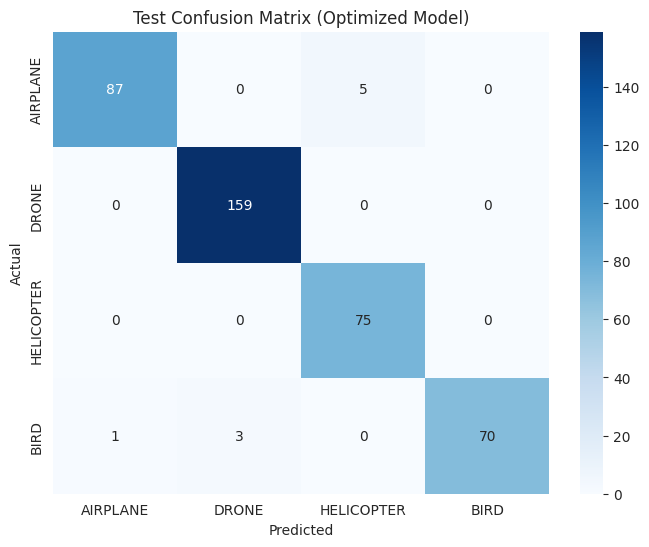


Per-class Accuracy:
  AIRPLANE: 0.9457 (92 samples)
  DRONE: 1.0000 (159 samples)
  HELICOPTER: 1.0000 (75 samples)
  BIRD: 0.9459 (74 samples)
Optimized Random Forest Test Accuracy: 0.9825
Analyzing Prediction Errors
Found 9 misclassified samples out of 400


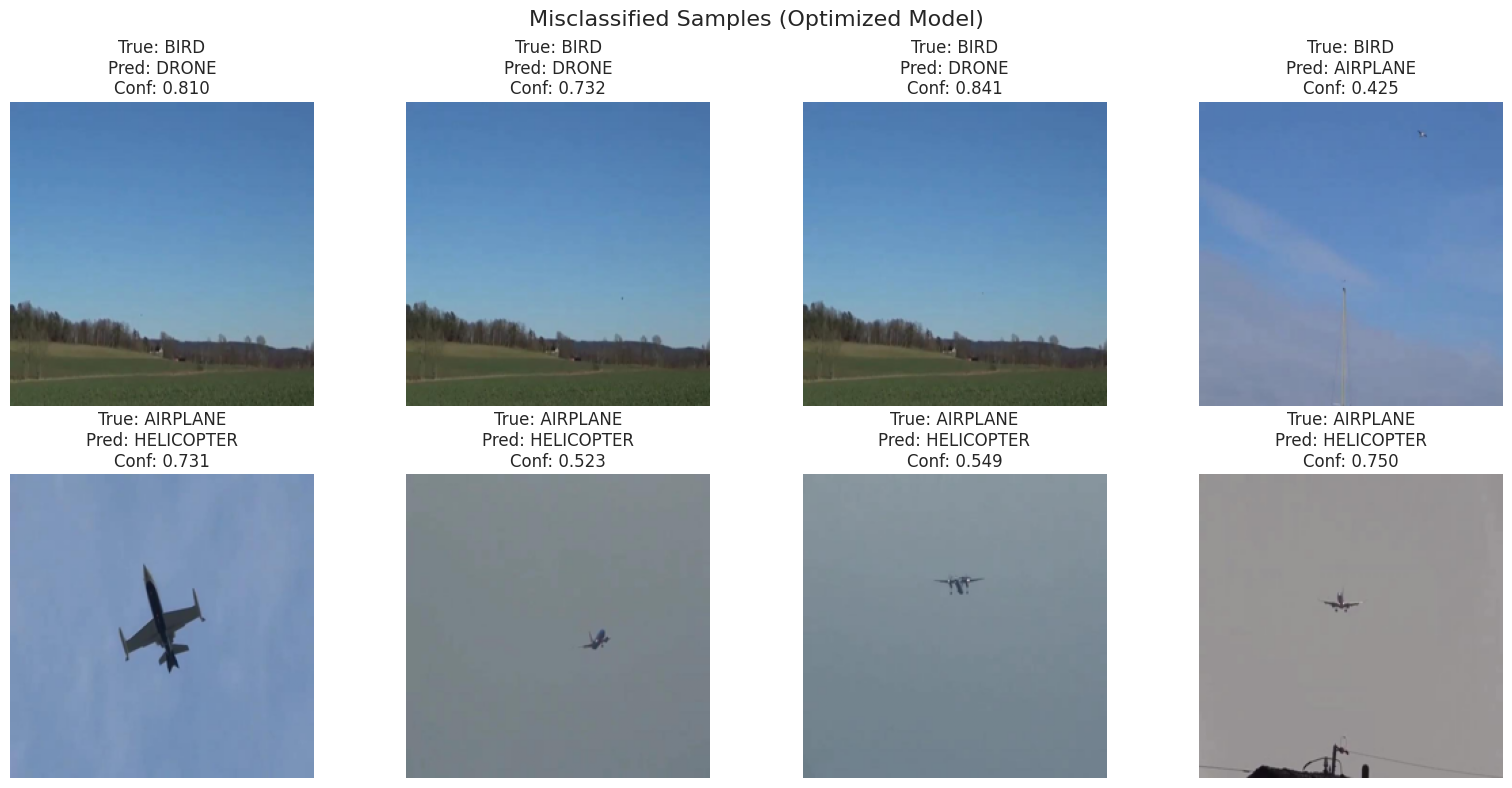


Most Common Error Patterns:
  AIRPLANE → HELICOPTER: 5 cases
  BIRD → DRONE: 3 cases
  BIRD → AIRPLANE: 1 cases


In [58]:
print("\n" + "="*80)
print("RandomForest Model Evaluation")
print("="*80)

# Evaluate on test set
if X_test_features is not None and len(X_test_cls) > 0:
    test_accuracy, y_test_pred, y_test_proba = evaluate_random_forest_model(
        optimized_rf, optimized_scaler, X_test_features, y_test_cls, feature_names
    )

    print(f"Optimized Random Forest Test Accuracy: {test_accuracy:.4f}")

    # Analyze prediction errors
    analyze_prediction_errors(X_test_cls, y_test_cls, y_test_pred, y_test_proba)

else:
    test_accuracy = optimized_valid_accuracy
    y_test_pred = None
    y_test_proba = None
    print("Using validation accuracy as final score (no test set available)")

## Concolutional Neural Networks (CNNs) Model Training

In [59]:
def create_classification_model(input_shape=(224, 224, 3), num_classes=4):
    '''
    Create a classification model
    '''
    model = Sequential([
        InputLayer(input_shape=input_shape),

        # Feature extraction
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Global average pooling
        tf.keras.layers.GlobalAveragePooling2D(),

        # Dense layers
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [60]:
def train_classification_model(X_train, y_train, X_val=None, y_val=None, X_test=None, y_test=None):
    '''
    Train classification model
    '''
    print("="*60)
    print("Training CNN Classification Model")
    print("="*60)

    model = create_classification_model()

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
        ModelCheckpoint('best_classification_model.h5', save_best_only=True, monitor='val_loss')
    ]

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Classes distribution in training: {Counter(y_train)}")

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    training_accuracy = record_performance_metrics('train', model, X_train, y_train, model_name='cnn')
    if X_val is not None and len(X_val) > 0:
      validation_accuracy = record_performance_metrics('valid', model, X_val, y_val, model_name='cnn')
      print(f"Validation Accuracy - CNN: {validation_accuracy:.4f}")
    if X_test is not None and len(X_test) > 0:
      test_accuracy = record_performance_metrics('test', model, X_test, y_test, model_name='cnn')
      print(f"Test Accuracy - CNN: {test_accuracy:.4f}")

    print(f"Training Accuracy - CNN: {training_accuracy:.4f}")


    return model, history

In [61]:
def plot_training_history(history, title="Training History", filename='cnn_training_history'):
    '''
    Plot training history
    '''
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracy (if available)
    if 'accuracy' in history.history:
        axes[1].plot(history.history['accuracy'], label='Training Accuracy')
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Model Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True)
    else:
        # Plot MAE for detection model
        if 'mae' in history.history:
            axes[1].plot(history.history['mae'], label='Training MAE')
            axes[1].plot(history.history['val_mae'], label='Validation MAE')
            axes[1].set_title('Model MAE')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('MAE')
            axes[1].legend()
            axes[1].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f"images/{filename}.png")
    plt.show()

In [62]:
def evaluate_classification_model(model, X_test, y_test, filename="cnn_confusion_matrix"):
    '''
    Evaluate classification model
    '''
    print("="*60)
    print("Evaluating CNN Classfication Model")
    print("="*60)

    # Make predictions
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = np.mean(predicted_classes == y_test)
    print(f"Test Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, predicted_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"images/{filename}.png")
    plt.show()

    return accuracy

## Train classification model on original data


Starting classification model training on original data...
Training CNN Classification Model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,276 (2.50 MB)

 Trainable params: 653,316 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2100
Validation samples: 400
Classes distribution in training: Counter({np.int64(1): 834, np.int64(2): 460, np.int64(0): 426, np.int64(3): 380})
Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5895 - loss: 1.0333

66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 266ms/step - accuracy: 0.5904 - loss: 1.0311 - val_accuracy: 0.1900 - val_loss: 2.6775 - learning_rate: 0.0010
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7332 - loss: 0.6597 - val_accuracy: 0.1675 - val_loss: 4.3056 - learning_rate: 0.0010
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7762 - loss: 0.5257 - val_accuracy: 0.2350 - val_loss: 4.1085 - learning_rate: 0.0010
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8387 - loss: 0.4294 - val_accuracy: 0.2400 - val_loss: 4.8116 - learning_rate: 0.0010
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8388 - loss: 0.4039 - val_accuracy: 0.2975 - val_loss: 3.8032 - learning_rate: 0.0010
Epoch 6/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8228 - loss: 0.4751

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8232 - loss: 0.4738 - val_accuracy: 0.2300 - val_loss: 2.6700 - learning_rate: 0.0010
Epoch 7/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8763 - loss: 0.3342

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8761 - loss: 0.3343 - val_accuracy: 0.3300 - val_loss: 2.4127 - learning_rate: 0.0010
Epoch 8/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8654 - loss: 0.3188

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8658 - loss: 0.3183 - val_accuracy: 0.6200 - val_loss: 1.0041 - learning_rate: 0.0010
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8900 - loss: 0.2927 - val_accuracy: 0.2375 - val_loss: 6.5223 - learning_rate: 0.0010
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8822 - loss: 0.3404 - val_accuracy: 0.2975 - val_loss: 3.4199 - learning_rate: 0.0010
Epoch 11/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8964 - loss: 0.2645 - val_accuracy: 0.3700 - val_loss: 2.5262 - learning_rate: 0.0010
Epoch 12/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8996 - loss: 0.2839 - val_accuracy: 0.3050 - val_loss: 6.4220 - learning_rate: 0.0010
Epoch 13/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9056 - loss: 0.2334

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9055 - loss: 0.2337 - val_accuracy: 0.7375 - val_loss: 0.8035 - learning_rate: 0.0010
Epoch 14/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9097 - loss: 0.2430

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9097 - loss: 0.2428 - val_accuracy: 0.8025 - val_loss: 0.5130 - learning_rate: 0.0010
Epoch 15/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8972 - loss: 0.2526

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8975 - loss: 0.2522 - val_accuracy: 0.8100 - val_loss: 0.4925 - learning_rate: 0.0010
Epoch 16/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9205 - loss: 0.1950 - val_accuracy: 0.7400 - val_loss: 0.6435 - learning_rate: 0.0010
Epoch 17/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9238 - loss: 0.1913 - val_accuracy: 0.5350 - val_loss: 2.6938 - learning_rate: 0.0010
Epoch 18/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9044 - loss: 0.2517 - val_accuracy: 0.6725 - val_loss: 0.8006 - learning_rate: 0.0010
Epoch 19/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9279 - loss: 0.2001 - val_accuracy: 0.3725 - val_loss: 4.3110 - learning_rate: 0.0010
Epoch 20/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9112 - loss: 0.2207 - val_accuracy: 0.5325 - val_loss: 2.0431 - learning_rate: 0.0010
Epoch 21/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9217 - loss: 0.1963 - val_accuracy

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9336 - loss: 0.1555 - val_accuracy: 0.8925 - val_loss: 0.2604 - learning_rate: 5.0000e-04
Epoch 23/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9448 - loss: 0.1418 - val_accuracy: 0.8575 - val_loss: 0.3144 - learning_rate: 5.0000e-04
Epoch 24/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9531 - loss: 0.1277

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9529 - loss: 0.1280 - val_accuracy: 0.9075 - val_loss: 0.2497 - learning_rate: 5.0000e-04
Epoch 25/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9516 - loss: 0.1225 - val_accuracy: 0.8400 - val_loss: 0.4400 - learning_rate: 5.0000e-04
Epoch 26/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9624 - loss: 0.1077 - val_accuracy: 0.8600 - val_loss: 0.3244 - learning_rate: 5.0000e-04
Epoch 27/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9431 - loss: 0.1193

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9431 - loss: 0.1194 - val_accuracy: 0.9225 - val_loss: 0.2173 - learning_rate: 5.0000e-04
Epoch 28/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9599 - loss: 0.1125 - val_accuracy: 0.8200 - val_loss: 0.4315 - learning_rate: 5.0000e-04
Epoch 29/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9538 - loss: 0.1162 - val_accuracy: 0.9175 - val_loss: 0.2356 - learning_rate: 5.0000e-04
Epoch 30/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9509 - loss: 0.1192 - val_accuracy: 0.8900 - val_loss: 0.3233 - learning_rate: 5.0000e-04
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step
Recording Performance Metrics for CNN:

Training Accuracy: 0.9600
Training MSE: 0.2176
Training MAE: 0.0431
Training Precision: 0.9614
Training Recall: 0.9600
Training F1 Score: 0.9600
Training R2 Score: 0.7830
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Recording Performance Metrics for CNN:

Validation Accuracy: 0.9225
Validation MSE: 0.3825
Valida

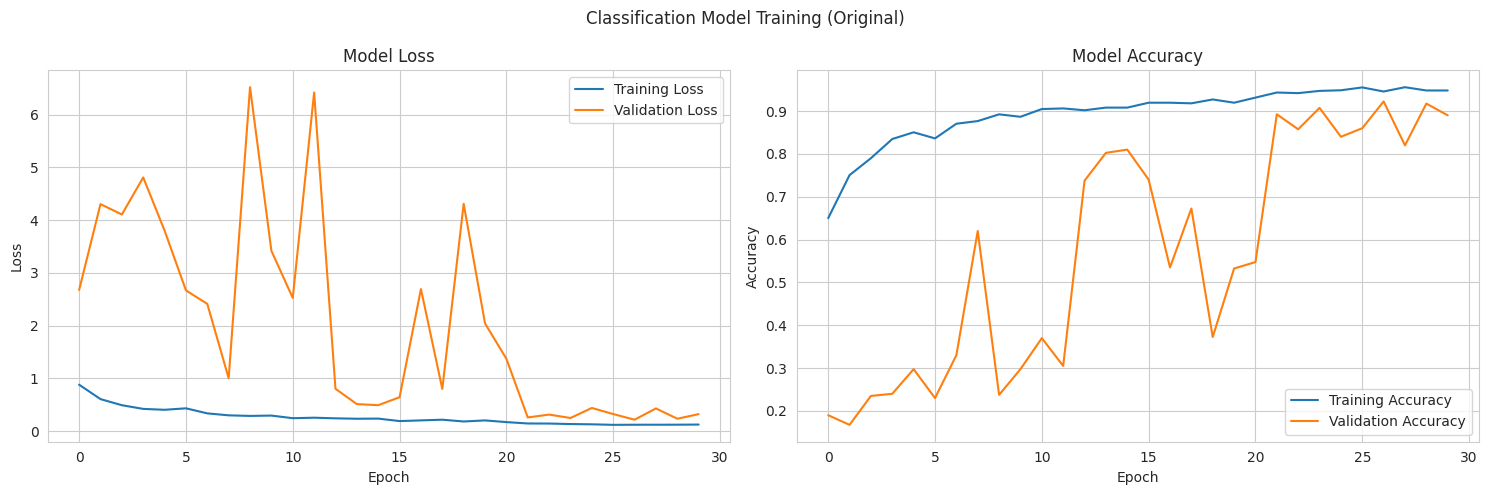

Evaluating CNN Classfication Model
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test Accuracy: 0.9400

Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.88      0.89      0.89        92
       DRONE       0.98      1.00      0.99       159
  HELICOPTER       0.88      0.97      0.92        75
        BIRD       1.00      0.84      0.91        74

    accuracy                           0.94       400
   macro avg       0.94      0.93      0.93       400
weighted avg       0.94      0.94      0.94       400



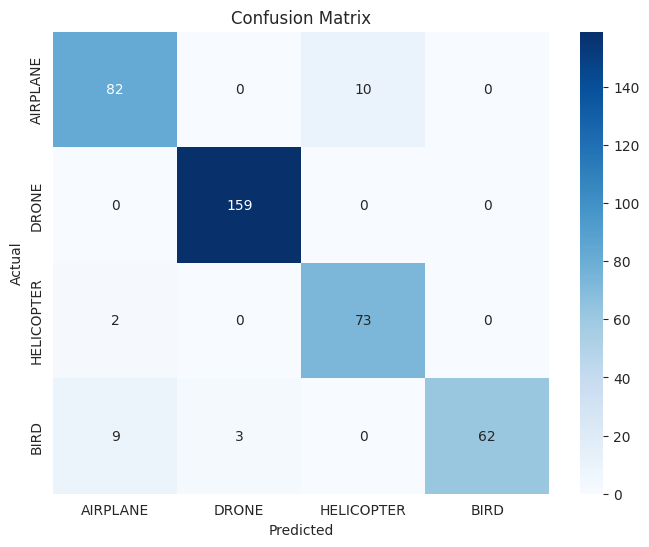

Final Classification Test Accuracy (Original): 0.9400
CPU times: user 2min 10s, sys: 5.42 s, total: 2min 15s
Wall time: 2min 12s


In [63]:
%%time
# Train classification model on original data
def train_classification_model_original(X_train, y_train, X_val=None, y_val=None):
    '''
    Train classification model on original data
    '''
    print("\nStarting classification model training on original data...")
    try:
        if X_val is not None:
          X_val_cls, y_val_cls = create_classification_data(X_val, Y_val)
        cls_model, cls_history = train_classification_model(
            X_train_cls, y_train_cls, X_val_cls, y_val_cls, X_test_cls, y_test_cls
        )

        # Plot training history
        plot_training_history(cls_history, "Classification Model Training (Original)")

        # Evaluate on test set
        if X_test_cls is not None and len(X_test_cls) > 0:
            accuracy_original = evaluate_classification_model(cls_model, X_test_cls, y_test_cls)
            print(f"Final Classification Test Accuracy (Original): {accuracy_original:.4f}")
        return cls_model, cls_history
    except Exception as e:
        print(f"Error during classification training: {e}")
        traceback.print_exc()
        cls_model = None

cnn_start_time = time.time()
cls_model, cls_history = train_classification_model_original(X_train_cls, y_train_cls, X_val_cls, y_val_cls)
cnn_end_time = time.time()
model_training_time.append(cnn_end_time - cnn_start_time)

## Train Classification Model Denoised


Starting classification model training on denoised data...
Training CNN Classification Model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,276 (2.50 MB)

 Trainable params: 653,316 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2100
Validation samples: 400
Classes distribution in training: Counter({np.int64(1): 834, np.int64(2): 460, np.int64(0): 426, np.int64(3): 380})
Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5599 - loss: 1.0450

66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.5614 - loss: 1.0418 - val_accuracy: 0.2150 - val_loss: 2.4518 - learning_rate: 0.0010
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7495 - loss: 0.6373 - val_accuracy: 0.2550 - val_loss: 3.1351 - learning_rate: 0.0010
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7749 - loss: 0.5687 - val_accuracy: 0.2125 - val_loss: 3.9645 - learning_rate: 0.0010
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8440 - loss: 0.4207 - val_accuracy: 0.2200 - val_loss: 3.7354 - learning_rate: 0.0010
Epoch 5/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8393 - loss: 0.4109

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8394 - loss: 0.4108 - val_accuracy: 0.3400 - val_loss: 2.0348 - learning_rate: 0.0010
Epoch 6/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8671 - loss: 0.3529

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8668 - loss: 0.3534 - val_accuracy: 0.3725 - val_loss: 1.8890 - learning_rate: 0.0010
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8484 - loss: 0.3670 - val_accuracy: 0.2575 - val_loss: 4.2903 - learning_rate: 0.0010
Epoch 8/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8926 - loss: 0.2950

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8924 - loss: 0.2954 - val_accuracy: 0.7050 - val_loss: 0.8483 - learning_rate: 0.0010
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8864 - loss: 0.3013 - val_accuracy: 0.4875 - val_loss: 1.3980 - learning_rate: 0.0010
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8697 - loss: 0.3431 - val_accuracy: 0.6200 - val_loss: 2.3865 - learning_rate: 0.0010
Epoch 11/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8944 - loss: 0.2512 - val_accuracy: 0.6600 - val_loss: 1.5460 - learning_rate: 0.0010
Epoch 12/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9002 - loss: 0.2548

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9003 - loss: 0.2546 - val_accuracy: 0.7525 - val_loss: 0.6983 - learning_rate: 0.0010
Epoch 13/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9237 - loss: 0.2124

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9234 - loss: 0.2125 - val_accuracy: 0.7775 - val_loss: 0.6485 - learning_rate: 0.0010
Epoch 14/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9067 - loss: 0.2434 - val_accuracy: 0.7375 - val_loss: 0.7294 - learning_rate: 0.0010
Epoch 15/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9213 - loss: 0.2229 - val_accuracy: 0.5000 - val_loss: 1.4401 - learning_rate: 0.0010
Epoch 16/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9133 - loss: 0.2072 - val_accuracy: 0.7350 - val_loss: 0.7888 - learning_rate: 0.0010
Epoch 17/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9150 - loss: 0.2264 - val_accuracy: 0.6575 - val_loss: 1.0235 - learning_rate: 0.0010
Epoch 18/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8911 - loss: 0.3161 - val_accuracy: 0.2175 - val_loss: 11.9634 - learning_rate: 0.0010
Epoch 19/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9181 - loss: 0.2127 - val_accurac

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9314 - loss: 0.1642 - val_accuracy: 0.9025 - val_loss: 0.2349 - learning_rate: 5.0000e-04
Epoch 22/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9395 - loss: 0.1480

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9394 - loss: 0.1482 - val_accuracy: 0.9000 - val_loss: 0.2246 - learning_rate: 5.0000e-04
Epoch 23/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9345 - loss: 0.1598 - val_accuracy: 0.8750 - val_loss: 0.2464 - learning_rate: 5.0000e-04
Epoch 24/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9445 - loss: 0.1442 - val_accuracy: 0.8600 - val_loss: 0.2847 - learning_rate: 5.0000e-04
Epoch 25/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9439 - loss: 0.1319 - val_accuracy: 0.8025 - val_loss: 0.5368 - learning_rate: 5.0000e-04
Epoch 26/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9285 - loss: 0.1674 - val_accuracy: 0.8850 - val_loss: 0.2583 - learning_rate: 5.0000e-04
Epoch 27/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9420 - loss: 0.1414 - val_accuracy: 0.9000 - val_loss: 0.2631 - learning_rate: 5.0000e-04
Epoch 28/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9450 - los

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9452 - loss: 0.1319 - val_accuracy: 0.9250 - val_loss: 0.2101 - learning_rate: 2.5000e-04
Epoch 29/30
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9446 - loss: 0.1287

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9448 - loss: 0.1283 - val_accuracy: 0.9350 - val_loss: 0.1793 - learning_rate: 2.5000e-04
Epoch 30/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9570 - loss: 0.1156 - val_accuracy: 0.9100 - val_loss: 0.2137 - learning_rate: 2.5000e-04
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
Recording Performance Metrics for CNN:

Training Accuracy: 0.9648
Training MSE: 0.2148
Training MAE: 0.0697
Training Precision: 0.9658
Training Recall: 0.9648
Training F1 Score: 0.9647
Training R2 Score: 0.7858
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Recording Performance Metrics for CNN:

Validation Accuracy: 0.9350
Validation MSE: 0.3325
Validation MAE: 0.0763
Validation Precision: 0.9416
Validation Recall: 0.9350
Validation F1 Score: 0.9349
Validation R2 Score: 0.6784
Validation Accuracy - CNN: 0.9350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Recording Performance Metrics for CNN:

Test Accuracy: 0.9450
Test MSE: 0.3250
Test MAE: 0.0808
Test Precision

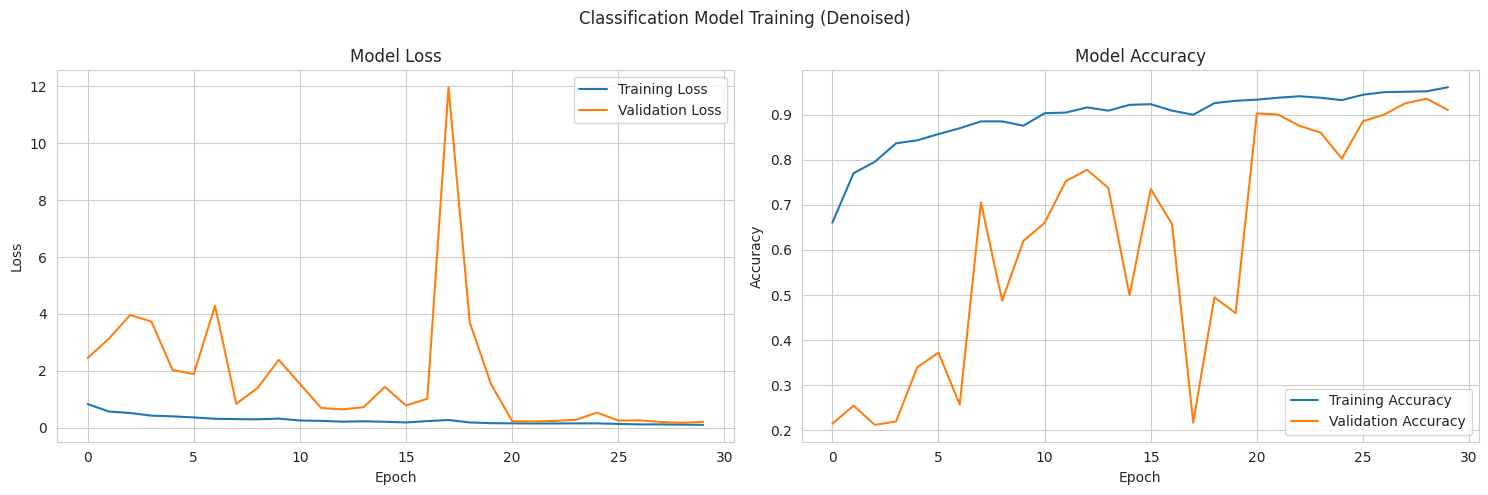

Evaluating CNN Classfication Model
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test Accuracy: 0.9450

Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.89      0.91      0.90        92
       DRONE       0.98      1.00      0.99       159
  HELICOPTER       0.89      0.99      0.94        75
        BIRD       1.00      0.82      0.90        74

    accuracy                           0.94       400
   macro avg       0.94      0.93      0.93       400
weighted avg       0.95      0.94      0.94       400



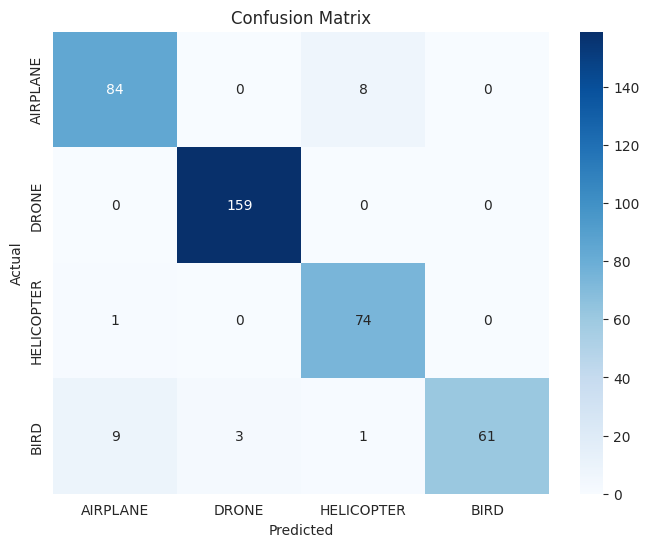

Final Classification Test Accuracy (Denoised): 0.9450
CPU times: user 1min 2s, sys: 4.64 s, total: 1min 6s
Wall time: 1min 53s


In [64]:
%%time
# Train classification model on denoised data
def train_classification_model_denoised(X_train_denoised, y_train):
    '''
    Train classification model on denoised data
    '''
    print("\nStarting classification model training on denoised data...")
    try:
      # Evaluate on test set
        if X_test_cls is not None and len(X_test_cls) > 0:
            # Apply denoising to test set
            X_test_denoised = np.zeros_like(X_test_cls)
            for i in range(len(X_test_cls)):
                img_uint8 = (X_test_cls[i] * 255).astype(np.uint8)
                blurred = cv2.GaussianBlur(img_uint8, (3, 3), 0)
                X_test_denoised[i] = blurred / 255.0

        cls_model_denoised, cls_history_denoised = train_classification_model(
            X_train_denoised, y_train_cls, X_val_denoised, y_val_cls, X_test_denoised, y_test_cls
        )

        # Plot training history
        plot_training_history(cls_history_denoised, "Classification Model Training (Denoised)", "cnn_denoised_training_history")

        accuracy_denoised = evaluate_classification_model(cls_model_denoised, X_test_denoised, y_test_cls, "cnn_denoised_confusion_matrix")
        print(f"Final Classification Test Accuracy (Denoised): {accuracy_denoised:.4f}")

        return cls_model_denoised, cls_history_denoised
    except Exception as e:
        print(f"Error during denoised classification training: {e}")
        traceback.print_exc()
        cls_model_denoised = None

cnn_denoised_start_time = time.time()
cls_model_denoised, cls_history_denoised = train_classification_model_denoised(X_train_denoised, y_train_cls)
cnn_denoised_end_time = time.time()
model_training_time.append(cnn_denoised_end_time - cnn_denoised_start_time)

## Train Detection Model

**Detection model creation function**

In [65]:
# Detection model creation function
def create_detection_model(input_shape=(224, 224, 3), num_classes=4, max_boxes=10):
    '''
    Create a simplified detection model that predicts class + bounding box for multiple objects
    '''
    inputs = Input(shape=input_shape)

    # Feature extraction backbone
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Dense layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer for multiple object detection
    # Output shape: (batch_size, max_boxes * 5) where each box has [class, x, y, w, h]
    x = Dense(max_boxes * 5, activation='linear')(x)

    # Reshape to (batch_size, max_boxes, 5)
    outputs = Reshape((max_boxes, 5), name='detection_output')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

**Visualize detection model predictions**

In [66]:
def visualize_detection_predictions(X_test, Y_true, Y_pred, num_samples=12):
    '''
    Visualize detection predictions
    '''
    fig, axes = plt.subplots(4, 3, figsize=(18, 12))
    fig.suptitle('Detection Model Predictions vs Ground Truth', fontsize=16, fontweight='bold')
    axes = axes.flatten()

    # Select random samples
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)

    for i, idx in enumerate(indices):
        if i >= num_samples:
            break

        img = X_test[idx]
        true_boxes = Y_true[idx]
        pred_boxes = Y_pred[idx]

        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f'Image {idx}')
        axes[i].axis('off')

        img_height, img_width = img.shape[:2]

        # Draw ground truth boxes in blue
        for j, box in enumerate(true_boxes):
            if np.sum(np.abs(box)) > 0:  # Valid box
                class_id, x_center, y_center, width, height = box

                # Convert to pixel coordinates
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height

                # Calculate top-left corner
                x1 = x_center - width / 2
                y1 = y_center - height / 2

                # Draw ground truth rectangle (blue)
                rect = Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor='blue', facecolor='none')
                axes[i].add_patch(rect)

                # Add class label
                if int(class_id) < len(class_names):
                    axes[i].text(x1, y1-5, f'GT: {class_names[int(class_id)]}',
                               color='blue', fontsize=8, fontweight='bold',
                               bbox=dict(facecolor='white', alpha=0.8, pad=1))

        # Draw predicted boxes in red
        for j, box in enumerate(pred_boxes):
            if np.sum(np.abs(box)) > 0.1:
                class_id, x_center, y_center, width, height = box

                # Convert to pixel coordinates
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height

                # Calculate top-left corner
                x1 = x_center - width / 2
                y1 = y_center - height / 2

                # Draw prediction rectangle (red)
                rect = Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
                axes[i].add_patch(rect)

                # Add class label
                pred_class = int(np.round(class_id))
                if 0 <= pred_class < len(class_names):
                    axes[i].text(x1, y1+height+5, f'Pred: {class_names[pred_class]}',
                               color='red', fontsize=8, fontweight='bold',
                               bbox=dict(facecolor='white', alpha=0.8, pad=1))

    plt.tight_layout()
    plt.savefig("images/detection_predictions.png")
    plt.show()

**Detection model loss using MSE**

In [67]:
def detection_loss(y_true, y_pred):
    '''
    Detection loss using MSE
    '''
    # Calculate MSE loss between predictions and ground truth
    loss = mse_loss(y_true, y_pred)

    # Create mask for valid boxes
    valid_mask = tf.reduce_sum(tf.abs(y_true), axis=-1) > 0
    valid_mask_float = tf.cast(valid_mask, tf.float32)

    # Apply mask and return mean loss
    masked_loss = loss * valid_mask_float

    # Calculate mean only over valid samples
    num_valid = tf.reduce_sum(valid_mask_float, axis=-1)
    num_valid = tf.maximum(num_valid, 1.0)

    sample_loss = tf.reduce_sum(masked_loss, axis=-1) / num_valid

    return tf.reduce_mean(sample_loss)

Train CNN detection model

In [68]:
def train_detection_model(X_train, Y_train, X_val, Y_val):
    '''
    Train detection model
    '''
    print("="*60)
    print("Training Detection Model")
    print("="*60)

    model = create_detection_model()

    # Compile model with simplified loss
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
        loss=detection_loss,
        metrics=['accuracy', 'mse', 'mae']
    )

    # Print model summary
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-8),
        ModelCheckpoint('best_detection_model.h5', save_best_only=True, monitor='val_loss')
    ]

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Input shape: {X_train.shape}")
    print(f"Output shape: {Y_train.shape}")

    # Train model
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=EPOCHS,
        batch_size=SMALL_BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    return model, history

**Train and evaluate CNN detection model**

In [69]:
%%time
# Train and evaluate detection model
def train_and_evaluate_detection_model(X_train, Y_train, X_val, Y_val):
    '''
    Train detection model
    '''
    print("\nStarting detection model training...")
    try:
        det_model, det_history = train_detection_model(
            X_train, Y_train, X_val, Y_val
        )

        return det_model, det_history
    except Exception as e:
        print(f"Error during detection training: {e}")
        traceback.print_exc()
        det_model = None

cnn_detection_start_time = time.time()
det_model, det_history = train_and_evaluate_detection_model(X_train, Y_train, X_val, Y_val)
cnn_detection_end_time = time.time()


Starting detection model training...
Training Detection Model


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ detection_output (Reshape)      │ (None, 10, 5)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,098 (2.54 MB)

 Trainable params: 665,138 (2.54 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2100
Validation samples: 400
Input shape: (2100, 224, 224, 3)
Output shape: (2100, 10, 5)
Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2070 - loss: 0.1311 - mae: 0.2272 - mse: 0.1311

263/263 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - accuracy: 0.2070 - loss: 0.1309 - mae: 0.2269 - mse: 0.1309 - val_accuracy: 0.1805 - val_loss: 0.0698 - val_mae: 0.1831 - val_mse: 0.0698 - learning_rate: 1.0000e-04
Epoch 2/30
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2496 - loss: 0.0335 - mae: 0.1023 - mse: 0.0335

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2497 - loss: 0.0335 - mae: 0.1022 - mse: 0.0335 - val_accuracy: 0.1837 - val_loss: 0.0375 - val_mae: 0.0989 - val_mse: 0.0375 - learning_rate: 1.0000e-04
Epoch 3/30
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2522 - loss: 0.0272 - mae: 0.0870 - mse: 0.0272

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2523 - loss: 0.0272 - mae: 0.0870 - mse: 0.0272 - val_accuracy: 0.2750 - val_loss: 0.0195 - val_mae: 0.0405 - val_mse: 0.0195 - learning_rate: 1.0000e-04
Epoch 4/30
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2569 - loss: 0.0241 - mae: 0.0770 - mse: 0.0241

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2569 - loss: 0.0241 - mae: 0.0770 - mse: 0.0241 - val_accuracy: 0.3043 - val_loss: 0.0175 - val_mae: 0.0388 - val_mse: 0.0175 - learning_rate: 1.0000e-04
Epoch 5/30
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2680 - loss: 0.0211 - mae: 0.0708 - mse: 0.0211

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2680 - loss: 0.0211 - mae: 0.0708 - mse: 0.0211 - val_accuracy: 0.2430 - val_loss: 0.0161 - val_mae: 0.0342 - val_mse: 0.0161 - learning_rate: 1.0000e-04
Epoch 6/30
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2665 - loss: 0.0197 - mae: 0.0660 - mse: 0.0197

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2666 - loss: 0.0197 - mae: 0.0660 - mse: 0.0197 - val_accuracy: 0.2535 - val_loss: 0.0143 - val_mae: 0.0320 - val_mse: 0.0143 - learning_rate: 1.0000e-04
Epoch 7/30
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2677 - loss: 0.0191 - mae: 0.0633 - mse: 0.0191

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2678 - loss: 0.0190 - mae: 0.0632 - mse: 0.0190 - val_accuracy: 0.2777 - val_loss: 0.0140 - val_mae: 0.0300 - val_mse: 0.0140 - learning_rate: 1.0000e-04
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2624 - loss: 0.0171 - mae: 0.0581 - mse: 0.0171 - val_accuracy: 0.3010 - val_loss: 0.0180 - val_mae: 0.0329 - val_mse: 0.0180 - learning_rate: 1.0000e-04
Epoch 9/30
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2633 - loss: 0.0171 - mae: 0.0549 - mse: 0.0171

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2634 - loss: 0.0171 - mae: 0.0549 - mse: 0.0171 - val_accuracy: 0.2830 - val_loss: 0.0133 - val_mae: 0.0285 - val_mse: 0.0133 - learning_rate: 1.0000e-04
Epoch 10/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2752 - loss: 0.0155 - mae: 0.0530 - mse: 0.0155 - val_accuracy: 0.2900 - val_loss: 0.0135 - val_mae: 0.0279 - val_mse: 0.0135 - learning_rate: 1.0000e-04
Epoch 11/30
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2773 - loss: 0.0156 - mae: 0.0514 - mse: 0.0156

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2773 - loss: 0.0156 - mae: 0.0514 - mse: 0.0156 - val_accuracy: 0.3080 - val_loss: 0.0122 - val_mae: 0.0265 - val_mse: 0.0122 - learning_rate: 1.0000e-04
Epoch 12/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2842 - loss: 0.0143 - mae: 0.0480 - mse: 0.0143 - val_accuracy: 0.3300 - val_loss: 0.0159 - val_mae: 0.0300 - val_mse: 0.0159 - learning_rate: 1.0000e-04
Epoch 13/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2779 - loss: 0.0143 - mae: 0.0459 - mse: 0.0143 - val_accuracy: 0.2558 - val_loss: 0.0126 - val_mae: 0.0257 - val_mse: 0.0126 - learning_rate: 1.0000e-04
Epoch 14/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2747 - loss: 0.0141 - mae: 0.0443 - mse: 0.0141 - val_accuracy: 0.3010 - val_loss: 0.0152 - val_mae: 0.0292 - val_mse: 0.0152 - learning_rate: 1.0000e-04
Epoch 15/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2742 - loss: 0.0131 - mae: 0.0426 - mse: 0.0131 - val_ac

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2879 - loss: 0.0116 - mae: 0.0372 - mse: 0.0116 - val_accuracy: 0.3175 - val_loss: 0.0107 - val_mae: 0.0213 - val_mse: 0.0107 - learning_rate: 5.0000e-05
Epoch 20/30
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2907 - loss: 0.0116 - mae: 0.0360 - mse: 0.0116

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2907 - loss: 0.0116 - mae: 0.0360 - mse: 0.0116 - val_accuracy: 0.3392 - val_loss: 0.0104 - val_mae: 0.0208 - val_mse: 0.0104 - learning_rate: 5.0000e-05
Epoch 21/30
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2946 - loss: 0.0115 - mae: 0.0359 - mse: 0.0115

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2945 - loss: 0.0115 - mae: 0.0359 - mse: 0.0115 - val_accuracy: 0.3783 - val_loss: 0.0092 - val_mae: 0.0192 - val_mse: 0.0092 - learning_rate: 5.0000e-05
Epoch 22/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2864 - loss: 0.0104 - mae: 0.0341 - mse: 0.0104 - val_accuracy: 0.3563 - val_loss: 0.0103 - val_mae: 0.0207 - val_mse: 0.0103 - learning_rate: 5.0000e-05
Epoch 23/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2912 - loss: 0.0099 - mae: 0.0330 - mse: 0.0099 - val_accuracy: 0.3300 - val_loss: 0.0095 - val_mae: 0.0197 - val_mse: 0.0095 - learning_rate: 5.0000e-05
Epoch 24/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2966 - loss: 0.0092 - mae: 0.0326 - mse: 0.0092 - val_accuracy: 0.4170 - val_loss: 0.0107 - val_mae: 0.0202 - val_mse: 0.0107 - learning_rate: 5.0000e-05
Epoch 25/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3035 - loss: 0.0105 - mae: 0.0324 - mse: 0.0105 - val_ac

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2890 - loss: 0.0095 - mae: 0.0309 - mse: 0.0095 - val_accuracy: 0.3057 - val_loss: 0.0087 - val_mae: 0.0183 - val_mse: 0.0087 - learning_rate: 5.0000e-05
Epoch 28/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2940 - loss: 0.0093 - mae: 0.0308 - mse: 0.0093 - val_accuracy: 0.3978 - val_loss: 0.0089 - val_mae: 0.0186 - val_mse: 0.0089 - learning_rate: 5.0000e-05
Epoch 29/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2960 - loss: 0.0081 - mae: 0.0286 - mse: 0.0081 - val_accuracy: 0.3625 - val_loss: 0.0090 - val_mae: 0.0185 - val_mse: 0.0090 - learning_rate: 5.0000e-05
Epoch 30/30
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3035 - loss: 0.0095 - mae: 0.0293 - mse: 0.0095

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3035 - loss: 0.0095 - mae: 0.0293 - mse: 0.0095 - val_accuracy: 0.3997 - val_loss: 0.0080 - val_mae: 0.0177 - val_mse: 0.0080 - learning_rate: 5.0000e-05
CPU times: user 2min, sys: 5.19 s, total: 2min 5s
Wall time: 1min 55s


### Plot detection model training history

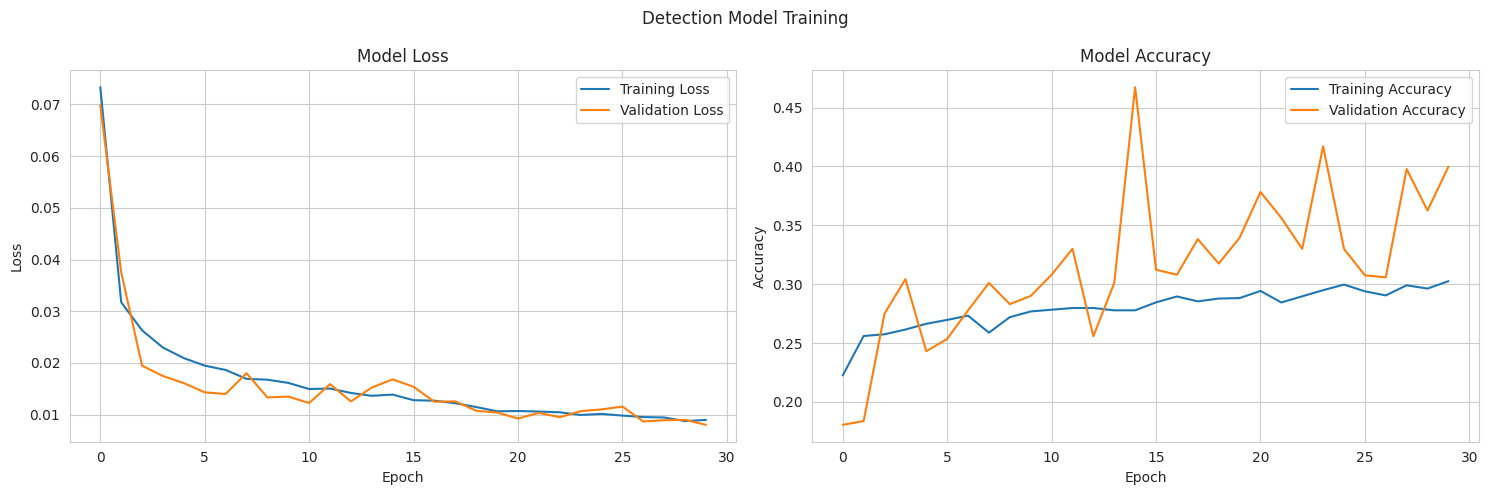

In [70]:
plot_training_history(det_history, "Detection Model Training", "cnn_detection_training_history")

### Evaluate CNN detection model

In [71]:
print("\n" + "="*80)
print("CNN Detection Model Evaluation")
print("="*80)

# Calculate the actual training time for detection model
detection_model_training_time = cnn_detection_end_time - cnn_detection_start_time

# Evaluate detection model
if det_model is not None:
    try:
        # Evaluate on all datasets
        print("\n--- Training Set Evaluation ---")
        train_coord_acc = record_detection_performance_metrics('train', det_model, X_train, Y_train)

        print("\n--- Validation Set Evaluation ---")
        val_coord_acc = record_detection_performance_metrics('valid', det_model, X_val, Y_val)

        print("\n--- Test Set Evaluation ---")
        test_coord_acc = record_detection_performance_metrics('test', det_model, X_test, Y_test)


        # Store training time
        detection_training_time.append(detection_model_training_time)

        print(f"\nDetection Model Training Time: {detection_model_training_time:.2f} seconds")
        print(f"Final Detection Coordinate Accuracy (Test): {test_coord_acc:.4f}")

    except Exception as e:
        print(f"Error in detection model evaluation: {e}")
        traceback.print_exc()


CNN Detection Model Evaluation

--- Training Set Evaluation ---
Recording Performance Metrics for CNN Detection Model (train):
Training MSE: 0.0057
Training MAE: 0.0161
Training R2 Score: 0.9152
Training Coordinate Accuracy: 0.7087
Training Average IoU: 0.1421

--- Validation Set Evaluation ---
Recording Performance Metrics for CNN Detection Model (valid):
Validation MSE: 0.0080
Validation MAE: 0.0177
Validation R2 Score: 0.8742
Validation Coordinate Accuracy: 0.7040
Validation Average IoU: 0.1335

--- Test Set Evaluation ---
Recording Performance Metrics for CNN Detection Model (test):
Test MSE: 0.0079
Test MAE: 0.0172
Test R2 Score: 0.8802
Test Coordinate Accuracy: 0.7069
Test Average IoU: 0.1435

Detection Model Training Time: 115.74 seconds
Final Detection Coordinate Accuracy (Test): 0.7069


In [72]:
run_detection_model_evaluation()

Running CNN Detection Model evaluation...
Comprehensive Model Performance Summary

Detailed Performance Metrics:
----------------------------------------------------------------------------------------------------
                            Training Time (Seconds) Accuracy/Coord_Acc Train Accuracy/Coord_Acc Validation Accuracy/Coord_Acc Test MSE Train MSE Validation  MSE Test MAE Train MAE Validation  MAE Test Precision/IoU Train Precision/IoU Validation Precision/IoU Test Recall Train Recall Validation Recall Test F1-Score Train F1-Score Validation F1-Score Test R2 Score Train R2 Score Validation R2 Score Test
RandomForestClassifier                     1.000022                      1.0                         0.965                  0.9825       0.0          0.155     0.075       0.0          0.035     0.035                 1.0                 0.966808             0.9829          1.0             0.965      0.9825            1.0            0.965093       0.98237            1.0         

(                            Training Time (Seconds) Accuracy/Coord_Acc Train  \
 RandomForestClassifier                     1.000022                      1.0   
 Optimized RandomForest                     1.214784                 0.999524   
 CNN Classification                       132.873303                     0.96   
 CNN Classification Denoised               113.96926                 0.964762   
 CNN Detection Model                      115.736416                  0.70869   
 
                             Accuracy/Coord_Acc Validation  \
 RandomForestClassifier                              0.965   
 Optimized RandomForest                             0.9725   
 CNN Classification                                 0.9225   
 CNN Classification Denoised                         0.935   
 CNN Detection Model                               0.70398   
 
                             Accuracy/Coord_Acc Test MSE Train MSE Validation  \
 RandomForestClassifier                       0.9825     

In [73]:
# Create and display results including CNN Detection Model
print("\n" + "="*100)
print("Model Performance Comparision")
print("="*100)

try:
    results_df = create_comprehensive_results_table()

    # Round numerical values for better display
    numeric_columns = results_df.select_dtypes(include=[np.number]).columns
    results_df[numeric_columns] = results_df[numeric_columns].round(4)

    transposed_df = results_df.T
    print(transposed_df.to_string())

    # Create and display summary table
    print("\n" + "="*80)
    print("Key Performance Metrics Summary")
    print("="*80)

    summary_metrics = ['Training Time (Seconds)', 'Accuracy/Coord_Acc Test', 'MSE Test', 'MAE Test', 'R2 Score Test']
    summary_df = results_df[summary_metrics].copy()

    print(summary_df.to_string())

    # Save results
    results_df.to_csv('data/comprehensive_model_results.csv')
    summary_df.to_csv('data/model_performance_summary.csv')
    print("\nResults saved to CSV files")

except Exception as e:
    print(f"Error creating comprehensive results table: {e}")
    traceback.print_exc()


Model Performance Comparision
                              RandomForestClassifier Optimized RandomForest CNN Classification CNN Classification Denoised CNN Detection Model
Training Time (Seconds)                     1.000022               1.214784         132.873303                   113.96926          115.736416
Accuracy/Coord_Acc Train                         1.0               0.999524               0.96                    0.964762             0.70869
Accuracy/Coord_Acc Validation                  0.965                 0.9725             0.9225                       0.935             0.70398
Accuracy/Coord_Acc Test                       0.9825                 0.9775               0.94                       0.945            0.706897
MSE Train                                        0.0               0.001905           0.217619                    0.214762             0.00575
MSE Validation                                 0.155                 0.1275             0.3825                 

In [80]:
# Create Line Plot for Error Metrics for all models
def plot_models_loss_function(df, ax, params):
    ylabel, title, metric_train, metric_test, metric_valid = params
    ax.plot(df.index, df[metric_train], marker='o', linestyle='-', label=metric_train, color='#1f77b4', linewidth=2, markersize=6)
    ax.plot(df.index, df[metric_test], marker='s', linestyle='--', label=metric_test, color='#d62728', linewidth=2, markersize=6)
    ax.plot(df.index, df[metric_valid], marker='^', linestyle='-', label=metric_valid, color='#2ca02c', linewidth=2, markersize=6)

    # Add Labels & Title
    ax.set_facecolor('#f7f7f7')  # light gray background
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_xlabel("Models", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(frameon=True, framealpha=0.9, facecolor='white', fontsize=10)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=10)
    plt.savefig('images/loss_function_metrics.png')

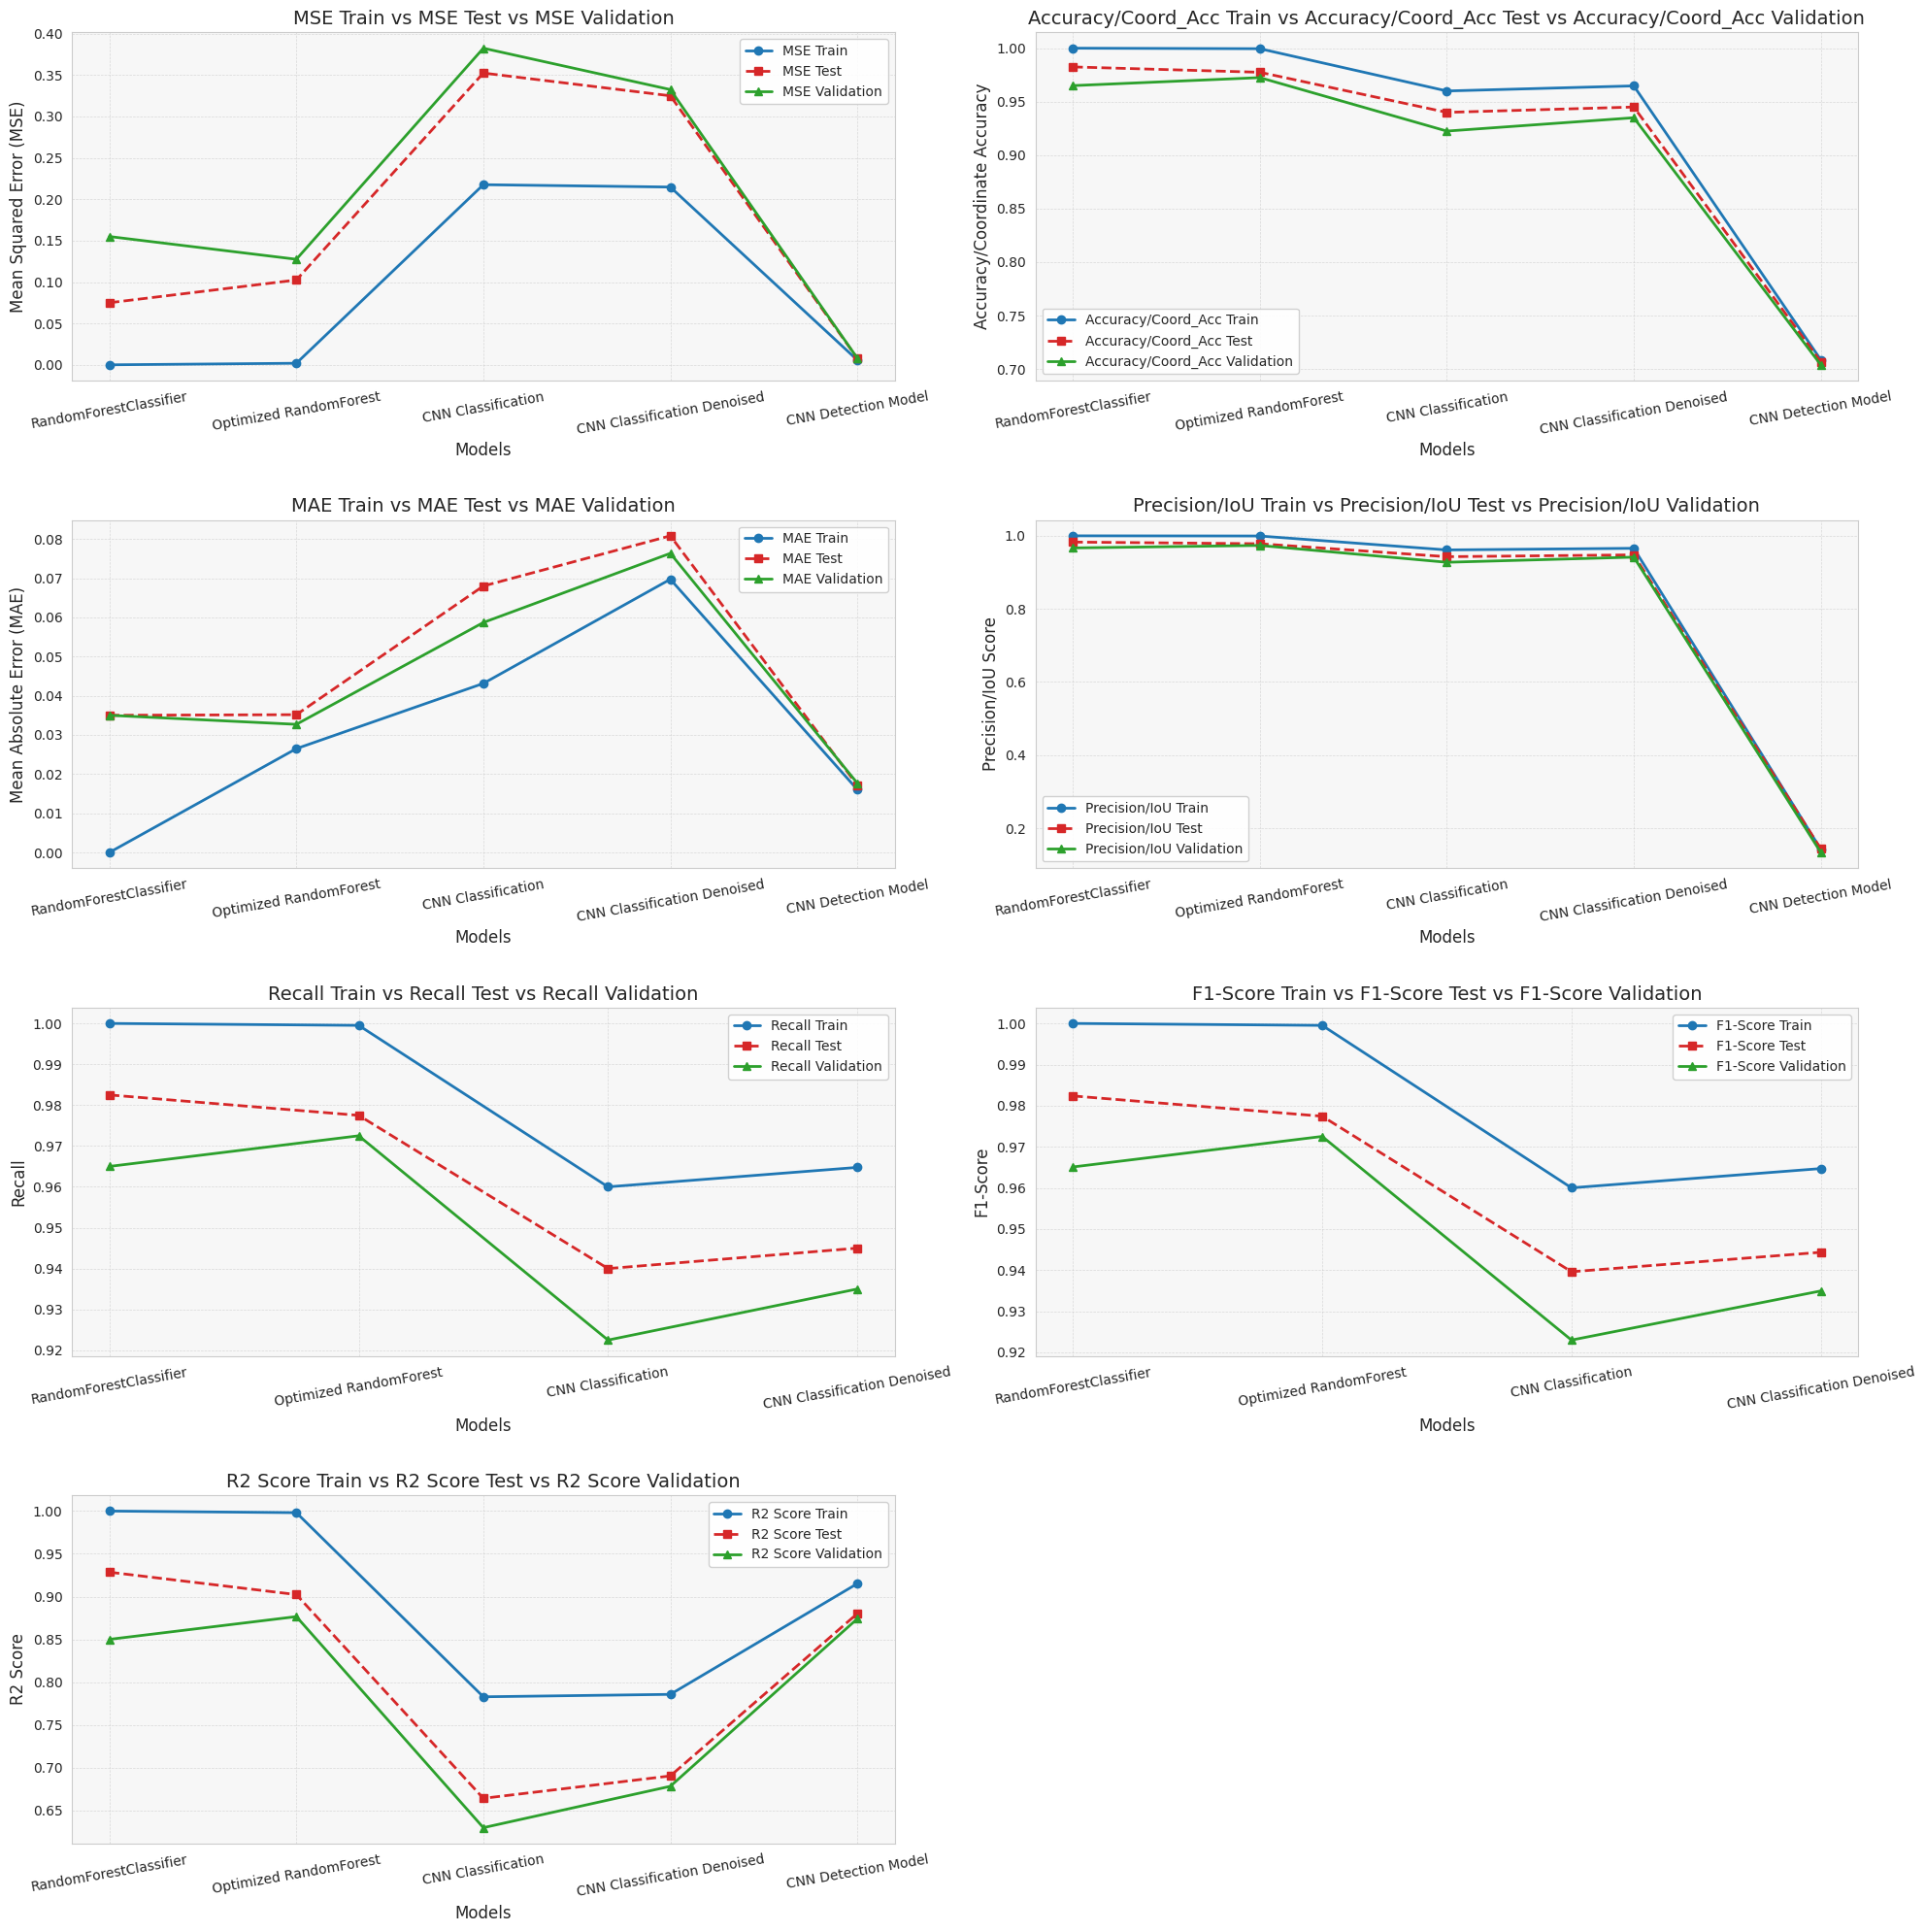

In [82]:
plot_params = [
    ['Mean Squared Error (MSE)', 'MSE Train vs MSE Test vs MSE Validation', 'MSE Train', 'MSE Test', 'MSE Validation'],
    ['Accuracy/Coordinate Accuracy', 'Accuracy/Coord_Acc Train vs Accuracy/Coord_Acc Test vs Accuracy/Coord_Acc Validation', 'Accuracy/Coord_Acc Train', 'Accuracy/Coord_Acc Test', 'Accuracy/Coord_Acc Validation'],
    ['Mean Absolute Error (MAE)', 'MAE Train vs MAE Test vs MAE Validation', 'MAE Train', 'MAE Test', 'MAE Validation'],
    ['Precision/IoU Score', 'Precision/IoU Train vs Precision/IoU Test vs Precision/IoU Validation', 'Precision/IoU Train', 'Precision/IoU Test', 'Precision/IoU Validation'],
    ['Recall', 'Recall Train vs Recall Test vs Recall Validation', 'Recall Train', 'Recall Test', 'Recall Validation'],
    ['F1-Score', 'F1-Score Train vs F1-Score Test vs F1-Score Validation', 'F1-Score Train', 'F1-Score Test', 'F1-Score Validation'],
    ['R2 Score', 'R2 Score Train vs R2 Score Test vs R2 Score Validation', 'R2 Score Train', 'R2 Score Test', 'R2 Score Validation']
]
fig, axs = plt.subplots(4,2,figsize=(20,20), constrained_layout=False)
axs = axs.flatten()
index = 0

for i, ax in enumerate(axs):
  if index < len(plot_params):
    if plot_params[index][0] == 'Recall' or plot_params[index][0] == 'F1-Score':
      plot_models_loss_function(results_df[:-1], ax, params=plot_params[index])
    else:
      plot_models_loss_function(results_df, ax, params=plot_params[index])
    index += 1
  else:
    ax.axis('off')
    ax.grid(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()